In [1]:
from dataclasses import dataclass
from datetime import datetime

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets
from torchvision.transforms import v2
from tqdm.auto import tqdm

In [44]:
writer = SummaryWriter(f'runs/mnist/vae_{datetime.now().strftime("%Y%m%d-%H%M%S")}')
writer_2 = SummaryWriter(f'runs_2/mnist/vae_{datetime.now().strftime("%Y%m%d-%H%M%S")}')
writer_3 = SummaryWriter(f'runs_3/mnist/vae_{datetime.now().strftime("%Y%m%d-%H%M%S")}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 128
learning_rate = 1e-3
weight_decay = 1e-2
num_epochs = 50
latent_dim = 2
hidden_dim = 512

In [3]:
transform = v2.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Lambda(lambda x: x.view(-1) - 0.5),
])

In [4]:
# Download and load the training data
train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform=transform,
)
len(train_data)

60000

In [5]:

test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=transform,
)
len(test_data)
print(test_data[0])

(tensor([-0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000,
        -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000,
        -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000,
        -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000,
        -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000,
        -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000,
        -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000,
        -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000,
        -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000,
        -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000,
        -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000,
        -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000,
        -0.5000, -0.5000, -0.5000, -0.5

In [6]:
# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)

In [7]:
@dataclass
class VAEOutput:
    """
    Dataclass for VAE output.
    
    Attributes:
        z_dist (torch.distributions.Distribution): The distribution of the latent variable z.
        z_sample (torch.Tensor): The sampled value of the latent variable z.
        x_recon (torch.Tensor): The reconstructed output from the VAE.
        loss (torch.Tensor): The overall loss of the VAE.
        loss_recon (torch.Tensor): The reconstruction loss component of the VAE loss.
        loss_kl (torch.Tensor): The KL divergence component of the VAE loss.
    """
    z_dist: torch.distributions.Distribution
    z_sample: torch.Tensor
    x_recon: torch.Tensor
    
    loss: torch.Tensor
    loss_recon: torch.Tensor
    loss_kl: torch.Tensor

In [8]:
class VAE(nn.Module):
    """
    Variational Autoencoder (VAE) class.
    
    Args:
        input_dim (int): Dimensionality of the input data.
        hidden_dim (int): Dimensionality of the hidden layer.
        latent_dim (int): Dimensionality of the latent space.
    """
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
                
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.SiLU(),  
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.SiLU(),  
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.SiLU(),  
            nn.Linear(hidden_dim // 4, hidden_dim // 8),
            nn.SiLU(),  
            nn.Linear(hidden_dim // 8, 2 * latent_dim), # 2 for mean and variance.
        )
        self.softplus = nn.Softplus()
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 8),
            nn.SiLU(),  
            nn.Linear(hidden_dim // 8, hidden_dim // 4),
            nn.SiLU(),  
            nn.Linear(hidden_dim // 4, hidden_dim // 2),
            nn.SiLU(),  
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.SiLU(),  
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid(),
        )
        
    def encode(self, x, eps: float = 1e-8):
        """
        Encodes the input data into the latent space.
        
        Args:
            x (torch.Tensor): Input data.
            eps (float): Small value to avoid numerical instability.
        
        Returns:
            torch.distributions.MultivariateNormal: Normal distribution of the encoded data.
        """
        x = self.encoder(x)
        mu, logvar = torch.chunk(x, 2, dim=-1)
        scale = self.softplus(logvar) + eps
        scale_tril = torch.diag_embed(scale)
        
        return torch.distributions.MultivariateNormal(mu, scale_tril=scale_tril)
        
    def reparameterize(self, dist):
        """
        Reparameterizes the encoded data to sample from the latent space.
        
        Args:
            dist (torch.distributions.MultivariateNormal): Normal distribution of the encoded data.

        Returns:
            torch.Tensor: Sampled data from the latent space.
        """
        return dist.rsample()
    
    def decode(self, z):
        """
        Decodes the data from the latent space to the original input space.
        
        Args:
            z (torch.Tensor): Data in the latent space.
        
        Returns:
            torch.Tensor: Reconstructed data in the original input space.
        """
        return self.decoder(z)
    
    def forward(self, x, compute_loss: bool = True):
        """
        Performs a forward pass of the VAE.
        
        Args:
            x (torch.Tensor): Input data.
            compute_loss (bool): Whether to compute the loss or not.
        
        Returns:
            VAEOutput: VAE output dataclass.
        """
        dist = self.encode(x)
        z = self.reparameterize(dist)
        recon_x = self.decode(z)
        
        if not compute_loss:
            return VAEOutput(
                z_dist=dist,
                z_sample=z,
                x_recon=recon_x,
                loss=None,
                loss_recon=None,
                loss_kl=None,
            )
        
        # compute loss terms 
        loss_recon = F.binary_cross_entropy(recon_x, x + 0.5, reduction='none').sum(-1).mean()
        std_normal = torch.distributions.MultivariateNormal(
            torch.zeros_like(z, device=z.device),
            scale_tril=torch.eye(z.shape[-1], device=z.device).unsqueeze(0).expand(z.shape[0], -1, -1),
        )
        loss_kl = torch.distributions.kl.kl_divergence(dist, std_normal).mean()
                
        loss = loss_recon + loss_kl
        
        return VAEOutput(
            z_dist=dist,
            z_sample=z,
            x_recon=recon_x,
            loss=loss,
            loss_recon=loss_recon,
            loss_kl=loss_kl,
        )

In [9]:
model = VAE(input_dim=784, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')

model

Number of parameters: 1,149,972


VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): SiLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): SiLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): SiLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): SiLU()
    (8): Linear(in_features=64, out_features=4, bias=True)
  )
  (softplus): Softplus(beta=1.0, threshold=20.0)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): SiLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): SiLU()
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): SiLU()
    (6): Linear(in_features=256, out_features=512, bias=True)
    (7): SiLU()
    (8): Linear(in_features=512, out_features=784, bias=True)
    (9): Sigmoid()
  )
)

In [10]:
# create an optimizer object
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


In [11]:
def train(model, dataloader, optimizer, prev_updates, writer=None):
    """
    Trains the model on the given data.
    
    Args:
        model (nn.Module): The model to train.
        dataloader (torch.utils.data.DataLoader): The data loader.
        loss_fn: The loss function.
        optimizer: The optimizer.
    """
    model.train()  # Set the model to training mode
    for batch_idx, (data, target) in enumerate(tqdm(dataloader)):
        n_upd = prev_updates + batch_idx
        
        data = data.to(device)
        
        optimizer.zero_grad()  # Zero the gradients
        
        output = model(data)  # Forward pass
        loss = output.loss
        
        loss.backward()
        
        if n_upd % 100 == 0:
            print("len data")
            print(batch_idx, len(data), len(target))
            # Calculate and log gradient norms
            total_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** (1. / 2)
        
            print(f'Step {n_upd:,} (N samples: {n_upd*batch_size:,}), Loss: {loss.item():.4f} (Recon: {output.loss_recon.item():.4f}, KL: {output.loss_kl.item():.4f}) Grad: {total_norm:.4f}')

            if writer is not None:
                global_step = n_upd
                writer.add_scalar('Loss/Train', loss.item(), global_step)
                writer.add_scalar('Loss/Train/BCE', output.loss_recon.item(), global_step)
                writer.add_scalar('Loss/Train/KLD', output.loss_kl.item(), global_step)
                writer.add_scalar('GradNorm/Train', total_norm, global_step)
            
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)    
        
        optimizer.step()  # Update the model parameters
        
    return prev_updates + len(dataloader)

In [12]:
def test(model, dataloader, cur_step, writer=None):
    """
    Tests the model on the given data.
    
    Args:
        model (nn.Module): The model to test.
        dataloader (torch.utils.data.DataLoader): The data loader.
        cur_step (int): The current step.
        writer: The TensorBoard writer.
    """
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    test_recon_loss = 0
    test_kl_loss = 0
    
    with torch.no_grad():
        for data, target in tqdm(dataloader, desc='Testing'):
            data = data.to(device)
            data = data.view(data.size(0), -1)  # Flatten the data
            
            output = model(data, compute_loss=True)  # Forward pass
            
            test_loss += output.loss.item()
            test_recon_loss += output.loss_recon.item()
            test_kl_loss += output.loss_kl.item()
            
    test_loss /= len(dataloader)
    test_recon_loss /= len(dataloader)
    test_kl_loss /= len(dataloader)
    print(f'====> Test set loss: {test_loss:.4f} (BCE: {test_recon_loss:.4f}, KLD: {test_kl_loss:.4f})')
    
    if writer is not None:
        writer.add_scalar('Loss/Test', test_loss, global_step=cur_step)
        writer.add_scalar('Loss/Test/BCE', output.loss_recon.item(), global_step=cur_step)
        writer.add_scalar('Loss/Test/KLD', output.loss_kl.item(), global_step=cur_step)
        
        # Log reconstructions
        writer.add_images('Test/Reconstructions', output.x_recon.view(-1, 1, 28, 28), global_step=cur_step)
        writer.add_images('Test/Originals', data.view(-1, 1, 28, 28), global_step=cur_step)
        
        # Log random samples from the latent space
        z = torch.randn(16, latent_dim).to(device)
        samples = model.decode(z)
        writer.add_images('Test/Samples', samples.view(-1, 1, 28, 28), global_step=cur_step)

In [13]:
import torch
from torch.utils.data import DataLoader, Dataset


prev_updates = 0
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    prev_updates = train(model, train_loader, optimizer, prev_updates, writer=writer)
    test(model, test_loader, prev_updates, writer=writer)




Epoch 1/50


  0%|          | 0/469 [00:00<?, ?it/s]

len data
0 128 128
Step 0 (N samples: 0), Loss: 544.2062 (Recon: 543.8572, KL: 0.3490) Grad: 12.9770
len data
100 128 128
Step 100 (N samples: 12,800), Loss: 186.0350 (Recon: 183.6467, KL: 2.3883) Grad: 14.6144
len data
200 128 128
Step 200 (N samples: 25,600), Loss: 188.8848 (Recon: 185.8663, KL: 3.0185) Grad: 21.0929
len data
300 128 128
Step 300 (N samples: 38,400), Loss: 172.3326 (Recon: 168.1159, KL: 4.2167) Grad: 41.6414
len data
400 128 128
Step 400 (N samples: 51,200), Loss: 171.0214 (Recon: 166.9089, KL: 4.1125) Grad: 42.2570


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 167.1698 (BCE: 162.8228, KLD: 4.3470)
Epoch 2/50


  0%|          | 0/469 [00:00<?, ?it/s]

len data
31 128 128
Step 500 (N samples: 64,000), Loss: 154.9425 (Recon: 150.1463, KL: 4.7962) Grad: 72.4104
len data
131 128 128
Step 600 (N samples: 76,800), Loss: 157.8878 (Recon: 153.2918, KL: 4.5961) Grad: 50.8801
len data
231 128 128
Step 700 (N samples: 89,600), Loss: 160.9723 (Recon: 156.1376, KL: 4.8347) Grad: 54.1197
len data
331 128 128
Step 800 (N samples: 102,400), Loss: 158.3391 (Recon: 153.2893, KL: 5.0498) Grad: 57.5516
len data
431 128 128
Step 900 (N samples: 115,200), Loss: 156.3730 (Recon: 151.0924, KL: 5.2806) Grad: 37.2346


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 156.7838 (BCE: 151.5388, KLD: 5.2450)
Epoch 3/50


  0%|          | 0/469 [00:00<?, ?it/s]

len data
62 128 128
Step 1,000 (N samples: 128,000), Loss: 164.8894 (Recon: 159.3790, KL: 5.5104) Grad: 80.9807
len data
162 128 128
Step 1,100 (N samples: 140,800), Loss: 155.9247 (Recon: 150.4981, KL: 5.4266) Grad: 41.4018
len data
262 128 128
Step 1,200 (N samples: 153,600), Loss: 155.4428 (Recon: 150.1826, KL: 5.2603) Grad: 36.5809
len data
362 128 128
Step 1,300 (N samples: 166,400), Loss: 151.8912 (Recon: 146.1663, KL: 5.7249) Grad: 54.5252
len data
462 128 128
Step 1,400 (N samples: 179,200), Loss: 152.5264 (Recon: 146.8324, KL: 5.6940) Grad: 75.1304


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 150.7584 (BCE: 145.0604, KLD: 5.6980)
Epoch 4/50


  0%|          | 0/469 [00:00<?, ?it/s]

len data
93 128 128
Step 1,500 (N samples: 192,000), Loss: 148.7694 (Recon: 142.9677, KL: 5.8017) Grad: 88.5271
len data
193 128 128
Step 1,600 (N samples: 204,800), Loss: 152.3126 (Recon: 146.5041, KL: 5.8085) Grad: 79.7313
len data
293 128 128
Step 1,700 (N samples: 217,600), Loss: 147.3014 (Recon: 141.2081, KL: 6.0933) Grad: 58.8442
len data
393 128 128
Step 1,800 (N samples: 230,400), Loss: 147.4372 (Recon: 141.3259, KL: 6.1113) Grad: 173.6574


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 146.9399 (BCE: 140.8833, KLD: 6.0565)
Epoch 5/50


  0%|          | 0/469 [00:00<?, ?it/s]

len data
24 128 128
Step 1,900 (N samples: 243,200), Loss: 145.5540 (Recon: 139.7006, KL: 5.8534) Grad: 76.7747
len data
124 128 128
Step 2,000 (N samples: 256,000), Loss: 145.5106 (Recon: 139.4438, KL: 6.0667) Grad: 98.9903
len data
224 128 128
Step 2,100 (N samples: 268,800), Loss: 142.5034 (Recon: 136.4127, KL: 6.0907) Grad: 73.0754
len data
324 128 128
Step 2,200 (N samples: 281,600), Loss: 149.9854 (Recon: 143.8274, KL: 6.1581) Grad: 94.9495
len data
424 128 128
Step 2,300 (N samples: 294,400), Loss: 155.8390 (Recon: 149.7924, KL: 6.0466) Grad: 96.7282


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 146.3657 (BCE: 140.3336, KLD: 6.0320)
Epoch 6/50


  0%|          | 0/469 [00:00<?, ?it/s]

len data
55 128 128
Step 2,400 (N samples: 307,200), Loss: 144.2672 (Recon: 138.1205, KL: 6.1467) Grad: 89.3739
len data
155 128 128
Step 2,500 (N samples: 320,000), Loss: 146.9947 (Recon: 140.6831, KL: 6.3116) Grad: 89.0925
len data
255 128 128
Step 2,600 (N samples: 332,800), Loss: 148.5349 (Recon: 142.3484, KL: 6.1866) Grad: 81.1816
len data
355 128 128
Step 2,700 (N samples: 345,600), Loss: 147.5460 (Recon: 141.3327, KL: 6.2133) Grad: 98.5581
len data
455 128 128
Step 2,800 (N samples: 358,400), Loss: 144.8813 (Recon: 138.7015, KL: 6.1799) Grad: 89.3448


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 144.2078 (BCE: 137.9855, KLD: 6.2223)
Epoch 7/50


  0%|          | 0/469 [00:00<?, ?it/s]

len data
86 128 128
Step 2,900 (N samples: 371,200), Loss: 138.4824 (Recon: 132.1747, KL: 6.3078) Grad: 145.8642
len data
186 128 128
Step 3,000 (N samples: 384,000), Loss: 148.6763 (Recon: 142.5571, KL: 6.1192) Grad: 92.8723
len data
286 128 128
Step 3,100 (N samples: 396,800), Loss: 143.3219 (Recon: 136.9690, KL: 6.3530) Grad: 117.8405
len data
386 128 128
Step 3,200 (N samples: 409,600), Loss: 146.0428 (Recon: 139.6982, KL: 6.3446) Grad: 95.8861


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 143.7617 (BCE: 137.5061, KLD: 6.2556)
Epoch 8/50


  0%|          | 0/469 [00:00<?, ?it/s]

len data
17 128 128
Step 3,300 (N samples: 422,400), Loss: 142.8809 (Recon: 136.4858, KL: 6.3951) Grad: 70.7561
len data
117 128 128
Step 3,400 (N samples: 435,200), Loss: 145.1404 (Recon: 138.8286, KL: 6.3118) Grad: 61.0121
len data
217 128 128
Step 3,500 (N samples: 448,000), Loss: 141.3129 (Recon: 135.0315, KL: 6.2814) Grad: 87.0163
len data
317 128 128
Step 3,600 (N samples: 460,800), Loss: 145.2656 (Recon: 138.9975, KL: 6.2682) Grad: 53.0860
len data
417 128 128
Step 3,700 (N samples: 473,600), Loss: 147.3530 (Recon: 141.0704, KL: 6.2826) Grad: 173.8968


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 143.0100 (BCE: 136.6098, KLD: 6.4002)
Epoch 9/50


  0%|          | 0/469 [00:00<?, ?it/s]

len data
48 128 128
Step 3,800 (N samples: 486,400), Loss: 147.5679 (Recon: 141.3042, KL: 6.2637) Grad: 75.3728
len data
148 128 128
Step 3,900 (N samples: 499,200), Loss: 145.9487 (Recon: 139.7823, KL: 6.1665) Grad: 101.0825
len data
248 128 128
Step 4,000 (N samples: 512,000), Loss: 138.7855 (Recon: 132.1704, KL: 6.6152) Grad: 187.0990
len data
348 128 128
Step 4,100 (N samples: 524,800), Loss: 133.5685 (Recon: 127.1291, KL: 6.4393) Grad: 68.5366
len data
448 128 128
Step 4,200 (N samples: 537,600), Loss: 144.4297 (Recon: 137.9305, KL: 6.4992) Grad: 70.8068


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 142.6735 (BCE: 136.2352, KLD: 6.4382)
Epoch 10/50


  0%|          | 0/469 [00:00<?, ?it/s]

len data
79 128 128
Step 4,300 (N samples: 550,400), Loss: 137.6659 (Recon: 131.2244, KL: 6.4415) Grad: 85.3769
len data
179 128 128
Step 4,400 (N samples: 563,200), Loss: 146.5320 (Recon: 139.9819, KL: 6.5501) Grad: 57.5158
len data
279 128 128
Step 4,500 (N samples: 576,000), Loss: 138.0089 (Recon: 131.4012, KL: 6.6077) Grad: 106.2656
len data
379 128 128
Step 4,600 (N samples: 588,800), Loss: 138.7361 (Recon: 132.1013, KL: 6.6347) Grad: 96.9307


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 142.8796 (BCE: 136.4992, KLD: 6.3804)
Epoch 11/50


  0%|          | 0/469 [00:00<?, ?it/s]

len data
10 128 128
Step 4,700 (N samples: 601,600), Loss: 146.9497 (Recon: 140.3544, KL: 6.5952) Grad: 111.0086
len data
110 128 128
Step 4,800 (N samples: 614,400), Loss: 144.7985 (Recon: 138.2401, KL: 6.5584) Grad: 163.8757
len data
210 128 128
Step 4,900 (N samples: 627,200), Loss: 145.4317 (Recon: 138.8754, KL: 6.5563) Grad: 166.9144
len data
310 128 128
Step 5,000 (N samples: 640,000), Loss: 140.9268 (Recon: 134.5113, KL: 6.4155) Grad: 101.0700
len data
410 128 128
Step 5,100 (N samples: 652,800), Loss: 145.4970 (Recon: 139.0744, KL: 6.4225) Grad: 86.5641


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 142.2791 (BCE: 135.8632, KLD: 6.4159)
Epoch 12/50


  0%|          | 0/469 [00:00<?, ?it/s]

len data
41 128 128
Step 5,200 (N samples: 665,600), Loss: 147.1152 (Recon: 140.7006, KL: 6.4146) Grad: 209.8032
len data
141 128 128
Step 5,300 (N samples: 678,400), Loss: 138.2582 (Recon: 131.8582, KL: 6.4000) Grad: 105.8480
len data
241 128 128
Step 5,400 (N samples: 691,200), Loss: 142.0161 (Recon: 135.6143, KL: 6.4018) Grad: 110.7193
len data
341 128 128
Step 5,500 (N samples: 704,000), Loss: 145.6940 (Recon: 139.1228, KL: 6.5711) Grad: 77.5248
len data
441 128 128
Step 5,600 (N samples: 716,800), Loss: 146.2678 (Recon: 139.6994, KL: 6.5684) Grad: 143.3845


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 140.7853 (BCE: 134.2504, KLD: 6.5349)
Epoch 13/50


  0%|          | 0/469 [00:00<?, ?it/s]

len data
72 128 128
Step 5,700 (N samples: 729,600), Loss: 139.8349 (Recon: 133.2055, KL: 6.6294) Grad: 138.8747
len data
172 128 128
Step 5,800 (N samples: 742,400), Loss: 139.8414 (Recon: 133.4072, KL: 6.4342) Grad: 97.6674
len data
272 128 128
Step 5,900 (N samples: 755,200), Loss: 134.4504 (Recon: 127.8713, KL: 6.5791) Grad: 117.1938
len data
372 128 128
Step 6,000 (N samples: 768,000), Loss: 133.8949 (Recon: 127.4208, KL: 6.4741) Grad: 70.9417


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 141.3060 (BCE: 134.9409, KLD: 6.3651)
Epoch 14/50


  0%|          | 0/469 [00:00<?, ?it/s]

len data
3 128 128
Step 6,100 (N samples: 780,800), Loss: 136.7498 (Recon: 130.3615, KL: 6.3883) Grad: 127.1847
len data
103 128 128
Step 6,200 (N samples: 793,600), Loss: 134.6047 (Recon: 128.0170, KL: 6.5877) Grad: 214.8023
len data
203 128 128
Step 6,300 (N samples: 806,400), Loss: 139.4881 (Recon: 132.8140, KL: 6.6741) Grad: 125.3127
len data
303 128 128
Step 6,400 (N samples: 819,200), Loss: 143.2164 (Recon: 136.7278, KL: 6.4886) Grad: 68.1012
len data
403 128 128
Step 6,500 (N samples: 832,000), Loss: 143.6746 (Recon: 137.2641, KL: 6.4105) Grad: 204.2367


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 141.6128 (BCE: 135.1243, KLD: 6.4885)
Epoch 15/50


  0%|          | 0/469 [00:00<?, ?it/s]

len data
34 128 128
Step 6,600 (N samples: 844,800), Loss: 139.0180 (Recon: 132.4630, KL: 6.5550) Grad: 171.5244
len data
134 128 128
Step 6,700 (N samples: 857,600), Loss: 138.9964 (Recon: 132.4167, KL: 6.5798) Grad: 95.9297
len data
234 128 128
Step 6,800 (N samples: 870,400), Loss: 139.5389 (Recon: 132.9636, KL: 6.5753) Grad: 111.6496
len data
334 128 128
Step 6,900 (N samples: 883,200), Loss: 147.2463 (Recon: 140.7970, KL: 6.4492) Grad: 96.0135
len data
434 128 128
Step 7,000 (N samples: 896,000), Loss: 141.1135 (Recon: 134.5427, KL: 6.5708) Grad: 62.2736


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 141.2964 (BCE: 134.8521, KLD: 6.4443)
Epoch 16/50


  0%|          | 0/469 [00:00<?, ?it/s]

len data
65 128 128
Step 7,100 (N samples: 908,800), Loss: 138.6894 (Recon: 132.1666, KL: 6.5228) Grad: 87.5920
len data
165 128 128
Step 7,200 (N samples: 921,600), Loss: 137.2005 (Recon: 130.3661, KL: 6.8344) Grad: 76.2496
len data
265 128 128
Step 7,300 (N samples: 934,400), Loss: 138.0009 (Recon: 131.3827, KL: 6.6182) Grad: 164.4636
len data
365 128 128
Step 7,400 (N samples: 947,200), Loss: 145.8117 (Recon: 139.2128, KL: 6.5989) Grad: 109.0186
len data
465 128 128
Step 7,500 (N samples: 960,000), Loss: 130.9103 (Recon: 124.2261, KL: 6.6842) Grad: 142.6996


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 139.2769 (BCE: 132.7219, KLD: 6.5550)
Epoch 17/50


  0%|          | 0/469 [00:00<?, ?it/s]

len data
96 128 128
Step 7,600 (N samples: 972,800), Loss: 143.2311 (Recon: 136.6257, KL: 6.6055) Grad: 91.4306
len data
196 128 128
Step 7,700 (N samples: 985,600), Loss: 135.2236 (Recon: 128.6342, KL: 6.5894) Grad: 124.3742
len data
296 128 128
Step 7,800 (N samples: 998,400), Loss: 150.3375 (Recon: 143.7256, KL: 6.6119) Grad: 134.3539
len data
396 128 128
Step 7,900 (N samples: 1,011,200), Loss: 146.8614 (Recon: 140.2640, KL: 6.5974) Grad: 92.3011


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 140.6417 (BCE: 133.9087, KLD: 6.7330)
Epoch 18/50


  0%|          | 0/469 [00:00<?, ?it/s]

len data
27 128 128
Step 8,000 (N samples: 1,024,000), Loss: 141.6070 (Recon: 134.9336, KL: 6.6734) Grad: 147.8291
len data
127 128 128
Step 8,100 (N samples: 1,036,800), Loss: 136.9981 (Recon: 130.2179, KL: 6.7802) Grad: 175.8854
len data
227 128 128
Step 8,200 (N samples: 1,049,600), Loss: 139.1998 (Recon: 132.5074, KL: 6.6924) Grad: 103.4249
len data
327 128 128
Step 8,300 (N samples: 1,062,400), Loss: 145.4569 (Recon: 138.8475, KL: 6.6094) Grad: 235.9331
len data
427 128 128
Step 8,400 (N samples: 1,075,200), Loss: 139.0496 (Recon: 132.2599, KL: 6.7897) Grad: 122.0828


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 138.4235 (BCE: 131.7475, KLD: 6.6760)
Epoch 19/50


  0%|          | 0/469 [00:00<?, ?it/s]

len data
58 128 128
Step 8,500 (N samples: 1,088,000), Loss: 148.7571 (Recon: 142.0819, KL: 6.6752) Grad: 76.4872
len data
158 128 128
Step 8,600 (N samples: 1,100,800), Loss: 135.4440 (Recon: 128.7732, KL: 6.6707) Grad: 113.1336
len data
258 128 128
Step 8,700 (N samples: 1,113,600), Loss: 136.4882 (Recon: 129.8279, KL: 6.6603) Grad: 132.3939
len data
358 128 128
Step 8,800 (N samples: 1,126,400), Loss: 148.7950 (Recon: 142.1141, KL: 6.6809) Grad: 114.7486
len data
458 128 128
Step 8,900 (N samples: 1,139,200), Loss: 143.6333 (Recon: 136.8797, KL: 6.7536) Grad: 105.8526


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 138.8692 (BCE: 132.2294, KLD: 6.6398)
Epoch 20/50


  0%|          | 0/469 [00:00<?, ?it/s]

len data
89 128 128
Step 9,000 (N samples: 1,152,000), Loss: 142.5529 (Recon: 135.8003, KL: 6.7527) Grad: 130.6206
len data
189 128 128
Step 9,100 (N samples: 1,164,800), Loss: 144.0078 (Recon: 137.1871, KL: 6.8207) Grad: 204.5799
len data
289 128 128
Step 9,200 (N samples: 1,177,600), Loss: 144.6738 (Recon: 137.6756, KL: 6.9982) Grad: 105.2573
len data
389 128 128
Step 9,300 (N samples: 1,190,400), Loss: 141.1170 (Recon: 134.6510, KL: 6.4660) Grad: 149.6889


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 138.5023 (BCE: 131.7629, KLD: 6.7393)
Epoch 21/50


  0%|          | 0/469 [00:00<?, ?it/s]

len data
20 128 128
Step 9,400 (N samples: 1,203,200), Loss: 141.2316 (Recon: 134.4519, KL: 6.7797) Grad: 150.9888
len data
120 128 128
Step 9,500 (N samples: 1,216,000), Loss: 142.7097 (Recon: 136.1199, KL: 6.5898) Grad: 126.0748
len data
220 128 128
Step 9,600 (N samples: 1,228,800), Loss: 146.5863 (Recon: 139.9873, KL: 6.5990) Grad: 104.7593
len data
320 128 128
Step 9,700 (N samples: 1,241,600), Loss: 144.5935 (Recon: 137.9243, KL: 6.6692) Grad: 181.6869
len data
420 128 128
Step 9,800 (N samples: 1,254,400), Loss: 141.9617 (Recon: 135.4010, KL: 6.5607) Grad: 134.0562


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 139.2999 (BCE: 132.6085, KLD: 6.6914)
Epoch 22/50


  0%|          | 0/469 [00:00<?, ?it/s]

len data
51 128 128
Step 9,900 (N samples: 1,267,200), Loss: 137.3676 (Recon: 130.5509, KL: 6.8167) Grad: 100.9684
len data
151 128 128
Step 10,000 (N samples: 1,280,000), Loss: 137.2050 (Recon: 130.5281, KL: 6.6769) Grad: 114.9084
len data
251 128 128
Step 10,100 (N samples: 1,292,800), Loss: 134.2539 (Recon: 127.5908, KL: 6.6631) Grad: 165.1971
len data
351 128 128
Step 10,200 (N samples: 1,305,600), Loss: 140.3647 (Recon: 133.6849, KL: 6.6799) Grad: 127.7060
len data
451 128 128
Step 10,300 (N samples: 1,318,400), Loss: 146.2295 (Recon: 139.4532, KL: 6.7763) Grad: 151.4100


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 139.0105 (BCE: 132.2355, KLD: 6.7750)
Epoch 23/50


  0%|          | 0/469 [00:00<?, ?it/s]

len data
82 128 128
Step 10,400 (N samples: 1,331,200), Loss: 151.7364 (Recon: 144.9815, KL: 6.7548) Grad: 145.3911
len data
182 128 128
Step 10,500 (N samples: 1,344,000), Loss: 141.3348 (Recon: 134.5517, KL: 6.7831) Grad: 192.8593
len data
282 128 128
Step 10,600 (N samples: 1,356,800), Loss: 138.8216 (Recon: 132.1262, KL: 6.6954) Grad: 102.4211
len data
382 128 128
Step 10,700 (N samples: 1,369,600), Loss: 137.3664 (Recon: 130.6306, KL: 6.7358) Grad: 104.2694


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 145.0802 (BCE: 138.5739, KLD: 6.5063)
Epoch 24/50


  0%|          | 0/469 [00:00<?, ?it/s]

len data
13 128 128
Step 10,800 (N samples: 1,382,400), Loss: 143.8931 (Recon: 137.3169, KL: 6.5763) Grad: 225.5783
len data
113 128 128
Step 10,900 (N samples: 1,395,200), Loss: 140.4784 (Recon: 133.8787, KL: 6.5997) Grad: 124.4552
len data
213 128 128
Step 11,000 (N samples: 1,408,000), Loss: 140.9722 (Recon: 134.2654, KL: 6.7068) Grad: 106.4899
len data
313 128 128
Step 11,100 (N samples: 1,420,800), Loss: 131.5081 (Recon: 124.7482, KL: 6.7599) Grad: 148.2233
len data
413 128 128
Step 11,200 (N samples: 1,433,600), Loss: 137.9550 (Recon: 131.1228, KL: 6.8322) Grad: 127.9444


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 139.2677 (BCE: 132.5659, KLD: 6.7017)
Epoch 25/50


  0%|          | 0/469 [00:00<?, ?it/s]

len data
44 128 128
Step 11,300 (N samples: 1,446,400), Loss: 140.2001 (Recon: 133.3772, KL: 6.8230) Grad: 128.8819
len data
144 128 128
Step 11,400 (N samples: 1,459,200), Loss: 133.8951 (Recon: 127.0776, KL: 6.8174) Grad: 92.4398
len data
244 128 128
Step 11,500 (N samples: 1,472,000), Loss: 135.9806 (Recon: 129.2579, KL: 6.7227) Grad: 122.3935
len data
344 128 128
Step 11,600 (N samples: 1,484,800), Loss: 140.2163 (Recon: 133.4478, KL: 6.7686) Grad: 123.0382
len data
444 128 128
Step 11,700 (N samples: 1,497,600), Loss: 142.2174 (Recon: 135.5742, KL: 6.6432) Grad: 223.7651


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 139.4058 (BCE: 132.6283, KLD: 6.7775)
Epoch 26/50


  0%|          | 0/469 [00:00<?, ?it/s]

len data
75 128 128
Step 11,800 (N samples: 1,510,400), Loss: 140.1824 (Recon: 133.4509, KL: 6.7315) Grad: 183.8407
len data
175 128 128
Step 11,900 (N samples: 1,523,200), Loss: 142.1346 (Recon: 135.3813, KL: 6.7533) Grad: 97.3330
len data
275 128 128
Step 12,000 (N samples: 1,536,000), Loss: 142.8494 (Recon: 136.2637, KL: 6.5857) Grad: 165.0150
len data
375 128 128
Step 12,100 (N samples: 1,548,800), Loss: 137.2174 (Recon: 130.6669, KL: 6.5505) Grad: 146.9679


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 140.3406 (BCE: 133.5621, KLD: 6.7785)
Epoch 27/50


  0%|          | 0/469 [00:00<?, ?it/s]

len data
6 128 128
Step 12,200 (N samples: 1,561,600), Loss: 139.9866 (Recon: 133.3170, KL: 6.6696) Grad: 136.7544
len data
106 128 128
Step 12,300 (N samples: 1,574,400), Loss: 141.3704 (Recon: 134.6819, KL: 6.6886) Grad: 101.1388
len data
206 128 128
Step 12,400 (N samples: 1,587,200), Loss: 143.6149 (Recon: 136.8615, KL: 6.7534) Grad: 137.1098
len data
306 128 128
Step 12,500 (N samples: 1,600,000), Loss: 138.9697 (Recon: 132.3345, KL: 6.6351) Grad: 74.5779
len data
406 128 128
Step 12,600 (N samples: 1,612,800), Loss: 133.3322 (Recon: 126.5426, KL: 6.7897) Grad: 174.2453


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 138.8455 (BCE: 132.1124, KLD: 6.7331)
Epoch 28/50


  0%|          | 0/469 [00:00<?, ?it/s]

len data
37 128 128
Step 12,700 (N samples: 1,625,600), Loss: 140.0001 (Recon: 133.3128, KL: 6.6874) Grad: 125.6208
len data
137 128 128
Step 12,800 (N samples: 1,638,400), Loss: 140.8549 (Recon: 134.0928, KL: 6.7622) Grad: 122.8666
len data
237 128 128
Step 12,900 (N samples: 1,651,200), Loss: 144.7259 (Recon: 137.7676, KL: 6.9583) Grad: 89.6418
len data
337 128 128
Step 13,000 (N samples: 1,664,000), Loss: 134.4624 (Recon: 127.7811, KL: 6.6813) Grad: 110.4354
len data
437 128 128
Step 13,100 (N samples: 1,676,800), Loss: 136.3141 (Recon: 129.3732, KL: 6.9409) Grad: 132.4042


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 138.5747 (BCE: 131.7388, KLD: 6.8358)
Epoch 29/50


  0%|          | 0/469 [00:00<?, ?it/s]

len data
68 128 128
Step 13,200 (N samples: 1,689,600), Loss: 136.3610 (Recon: 129.6521, KL: 6.7089) Grad: 172.2211
len data
168 128 128
Step 13,300 (N samples: 1,702,400), Loss: 141.2243 (Recon: 134.4798, KL: 6.7445) Grad: 272.8712
len data
268 128 128
Step 13,400 (N samples: 1,715,200), Loss: 139.5628 (Recon: 132.6723, KL: 6.8905) Grad: 223.4723
len data
368 128 128
Step 13,500 (N samples: 1,728,000), Loss: 138.0405 (Recon: 131.3649, KL: 6.6756) Grad: 105.4446
len data
468 96 96
Step 13,600 (N samples: 1,740,800), Loss: 139.7860 (Recon: 132.8545, KL: 6.9314) Grad: 137.6204


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 138.3328 (BCE: 131.4962, KLD: 6.8366)
Epoch 30/50


  0%|          | 0/469 [00:00<?, ?it/s]

len data
99 128 128
Step 13,700 (N samples: 1,753,600), Loss: 132.3323 (Recon: 125.5796, KL: 6.7527) Grad: 139.1256
len data
199 128 128
Step 13,800 (N samples: 1,766,400), Loss: 136.0679 (Recon: 129.1326, KL: 6.9352) Grad: 131.8930
len data
299 128 128
Step 13,900 (N samples: 1,779,200), Loss: 141.2636 (Recon: 134.2727, KL: 6.9909) Grad: 128.6690
len data
399 128 128
Step 14,000 (N samples: 1,792,000), Loss: 141.9905 (Recon: 135.3240, KL: 6.6665) Grad: 194.1593


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 138.1241 (BCE: 131.2021, KLD: 6.9220)
Epoch 31/50


  0%|          | 0/469 [00:00<?, ?it/s]

len data
30 128 128
Step 14,100 (N samples: 1,804,800), Loss: 143.5682 (Recon: 136.8029, KL: 6.7653) Grad: 155.9118
len data
130 128 128
Step 14,200 (N samples: 1,817,600), Loss: 137.1216 (Recon: 130.3193, KL: 6.8023) Grad: 114.8766
len data
230 128 128
Step 14,300 (N samples: 1,830,400), Loss: 131.9104 (Recon: 125.0331, KL: 6.8773) Grad: 95.9771
len data
330 128 128
Step 14,400 (N samples: 1,843,200), Loss: 139.8170 (Recon: 132.9387, KL: 6.8783) Grad: 207.4395
len data
430 128 128
Step 14,500 (N samples: 1,856,000), Loss: 141.1456 (Recon: 134.3670, KL: 6.7787) Grad: 100.9657


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 138.3040 (BCE: 131.3513, KLD: 6.9527)
Epoch 32/50


  0%|          | 0/469 [00:00<?, ?it/s]

len data
61 128 128
Step 14,600 (N samples: 1,868,800), Loss: 142.5690 (Recon: 135.7138, KL: 6.8552) Grad: 121.1151
len data
161 128 128
Step 14,700 (N samples: 1,881,600), Loss: 136.0379 (Recon: 129.0577, KL: 6.9802) Grad: 161.5183
len data
261 128 128
Step 14,800 (N samples: 1,894,400), Loss: 137.1295 (Recon: 130.2845, KL: 6.8451) Grad: 89.9078
len data
361 128 128
Step 14,900 (N samples: 1,907,200), Loss: 138.6018 (Recon: 131.7359, KL: 6.8659) Grad: 188.5827
len data
461 128 128
Step 15,000 (N samples: 1,920,000), Loss: 141.3339 (Recon: 134.5204, KL: 6.8135) Grad: 215.4284


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 137.8926 (BCE: 130.9544, KLD: 6.9382)
Epoch 33/50


  0%|          | 0/469 [00:00<?, ?it/s]

len data
92 128 128
Step 15,100 (N samples: 1,932,800), Loss: 133.4811 (Recon: 126.7463, KL: 6.7348) Grad: 119.5639
len data
192 128 128
Step 15,200 (N samples: 1,945,600), Loss: 138.5646 (Recon: 131.6459, KL: 6.9187) Grad: 171.0138
len data
292 128 128
Step 15,300 (N samples: 1,958,400), Loss: 136.4994 (Recon: 129.7354, KL: 6.7640) Grad: 135.2900
len data
392 128 128
Step 15,400 (N samples: 1,971,200), Loss: 136.2946 (Recon: 129.4519, KL: 6.8428) Grad: 121.1480


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 138.4315 (BCE: 131.4681, KLD: 6.9634)
Epoch 34/50


  0%|          | 0/469 [00:00<?, ?it/s]

len data
23 128 128
Step 15,500 (N samples: 1,984,000), Loss: 140.8905 (Recon: 134.0410, KL: 6.8496) Grad: 251.7161
len data
123 128 128
Step 15,600 (N samples: 1,996,800), Loss: 140.7035 (Recon: 133.6284, KL: 7.0751) Grad: 118.8832
len data
223 128 128
Step 15,700 (N samples: 2,009,600), Loss: 135.9893 (Recon: 129.1297, KL: 6.8596) Grad: 149.8410
len data
323 128 128
Step 15,800 (N samples: 2,022,400), Loss: 142.2193 (Recon: 135.3323, KL: 6.8869) Grad: 149.6942
len data
423 128 128
Step 15,900 (N samples: 2,035,200), Loss: 138.9148 (Recon: 132.0431, KL: 6.8717) Grad: 138.6126


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 138.6235 (BCE: 131.8957, KLD: 6.7278)
Epoch 35/50


  0%|          | 0/469 [00:00<?, ?it/s]

len data
54 128 128
Step 16,000 (N samples: 2,048,000), Loss: 127.8692 (Recon: 120.8313, KL: 7.0379) Grad: 124.5401
len data
154 128 128
Step 16,100 (N samples: 2,060,800), Loss: 143.2034 (Recon: 136.3580, KL: 6.8454) Grad: 186.5288
len data
254 128 128
Step 16,200 (N samples: 2,073,600), Loss: 143.3527 (Recon: 136.4921, KL: 6.8607) Grad: 204.1667
len data
354 128 128
Step 16,300 (N samples: 2,086,400), Loss: 140.7943 (Recon: 133.8447, KL: 6.9497) Grad: 93.5249
len data
454 128 128
Step 16,400 (N samples: 2,099,200), Loss: 132.9608 (Recon: 125.9723, KL: 6.9885) Grad: 106.5728


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 137.7135 (BCE: 130.8631, KLD: 6.8505)
Epoch 36/50


  0%|          | 0/469 [00:00<?, ?it/s]

len data
85 128 128
Step 16,500 (N samples: 2,112,000), Loss: 132.9499 (Recon: 126.0443, KL: 6.9055) Grad: 83.6668
len data
185 128 128
Step 16,600 (N samples: 2,124,800), Loss: 141.3004 (Recon: 134.3807, KL: 6.9197) Grad: 132.6204
len data
285 128 128
Step 16,700 (N samples: 2,137,600), Loss: 139.5888 (Recon: 132.8103, KL: 6.7785) Grad: 131.6393
len data
385 128 128
Step 16,800 (N samples: 2,150,400), Loss: 139.2893 (Recon: 132.2730, KL: 7.0163) Grad: 147.6964


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 137.5087 (BCE: 130.5768, KLD: 6.9318)
Epoch 37/50


  0%|          | 0/469 [00:00<?, ?it/s]

len data
16 128 128
Step 16,900 (N samples: 2,163,200), Loss: 139.7937 (Recon: 132.9056, KL: 6.8881) Grad: 140.7566
len data
116 128 128
Step 17,000 (N samples: 2,176,000), Loss: 144.3640 (Recon: 137.3925, KL: 6.9715) Grad: 170.9444
len data
216 128 128
Step 17,100 (N samples: 2,188,800), Loss: 135.7917 (Recon: 128.9426, KL: 6.8491) Grad: 200.7486
len data
316 128 128
Step 17,200 (N samples: 2,201,600), Loss: 139.1300 (Recon: 132.4086, KL: 6.7214) Grad: 300.5140
len data
416 128 128
Step 17,300 (N samples: 2,214,400), Loss: 142.6153 (Recon: 135.8785, KL: 6.7368) Grad: 194.4131


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 140.9955 (BCE: 134.4818, KLD: 6.5137)
Epoch 38/50


  0%|          | 0/469 [00:00<?, ?it/s]

len data
47 128 128
Step 17,400 (N samples: 2,227,200), Loss: 138.5832 (Recon: 131.7610, KL: 6.8222) Grad: 179.9070
len data
147 128 128
Step 17,500 (N samples: 2,240,000), Loss: 141.0316 (Recon: 134.2502, KL: 6.7814) Grad: 93.3822
len data
247 128 128
Step 17,600 (N samples: 2,252,800), Loss: 134.9389 (Recon: 128.1029, KL: 6.8360) Grad: 192.6120
len data
347 128 128
Step 17,700 (N samples: 2,265,600), Loss: 134.4697 (Recon: 127.5520, KL: 6.9177) Grad: 66.8210
len data
447 128 128
Step 17,800 (N samples: 2,278,400), Loss: 140.2197 (Recon: 133.2884, KL: 6.9312) Grad: 164.4115


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 139.4323 (BCE: 132.6200, KLD: 6.8123)
Epoch 39/50


  0%|          | 0/469 [00:00<?, ?it/s]

len data
78 128 128
Step 17,900 (N samples: 2,291,200), Loss: 140.7146 (Recon: 133.9509, KL: 6.7637) Grad: 103.2922
len data
178 128 128
Step 18,000 (N samples: 2,304,000), Loss: 142.0324 (Recon: 135.1640, KL: 6.8684) Grad: 158.7938
len data
278 128 128
Step 18,100 (N samples: 2,316,800), Loss: 138.8108 (Recon: 132.0888, KL: 6.7220) Grad: 181.2612
len data
378 128 128
Step 18,200 (N samples: 2,329,600), Loss: 141.8602 (Recon: 135.2025, KL: 6.6578) Grad: 210.3296


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 137.5065 (BCE: 130.5915, KLD: 6.9150)
Epoch 40/50


  0%|          | 0/469 [00:00<?, ?it/s]

len data
9 128 128
Step 18,300 (N samples: 2,342,400), Loss: 133.7108 (Recon: 126.7691, KL: 6.9417) Grad: 199.3747
len data
109 128 128
Step 18,400 (N samples: 2,355,200), Loss: 140.4006 (Recon: 133.3522, KL: 7.0484) Grad: 96.6992
len data
209 128 128
Step 18,500 (N samples: 2,368,000), Loss: 134.3861 (Recon: 127.5594, KL: 6.8267) Grad: 143.2406
len data
309 128 128
Step 18,600 (N samples: 2,380,800), Loss: 132.1617 (Recon: 125.1234, KL: 7.0384) Grad: 189.6947
len data
409 128 128
Step 18,700 (N samples: 2,393,600), Loss: 141.7391 (Recon: 134.8907, KL: 6.8484) Grad: 110.6760


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 139.0682 (BCE: 132.2242, KLD: 6.8440)
Epoch 41/50


  0%|          | 0/469 [00:00<?, ?it/s]

len data
40 128 128
Step 18,800 (N samples: 2,406,400), Loss: 140.4970 (Recon: 133.4212, KL: 7.0758) Grad: 138.6027
len data
140 128 128
Step 18,900 (N samples: 2,419,200), Loss: 130.3331 (Recon: 123.5165, KL: 6.8166) Grad: 139.4479
len data
240 128 128
Step 19,000 (N samples: 2,432,000), Loss: 135.6319 (Recon: 128.6559, KL: 6.9760) Grad: 409.2442
len data
340 128 128
Step 19,100 (N samples: 2,444,800), Loss: 136.0383 (Recon: 129.1994, KL: 6.8390) Grad: 158.3177
len data
440 128 128
Step 19,200 (N samples: 2,457,600), Loss: 142.3832 (Recon: 135.6699, KL: 6.7133) Grad: 197.9617


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 137.5827 (BCE: 130.7483, KLD: 6.8345)
Epoch 42/50


  0%|          | 0/469 [00:00<?, ?it/s]

len data
71 128 128
Step 19,300 (N samples: 2,470,400), Loss: 141.6439 (Recon: 134.9473, KL: 6.6966) Grad: 119.1939
len data
171 128 128
Step 19,400 (N samples: 2,483,200), Loss: 137.3288 (Recon: 130.5643, KL: 6.7645) Grad: 119.0189
len data
271 128 128
Step 19,500 (N samples: 2,496,000), Loss: 129.3942 (Recon: 122.5271, KL: 6.8671) Grad: 171.2904
len data
371 128 128
Step 19,600 (N samples: 2,508,800), Loss: 141.9810 (Recon: 134.9891, KL: 6.9919) Grad: 128.1994


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 137.7221 (BCE: 130.8327, KLD: 6.8894)
Epoch 43/50


  0%|          | 0/469 [00:00<?, ?it/s]

len data
2 128 128
Step 19,700 (N samples: 2,521,600), Loss: 133.9349 (Recon: 127.1246, KL: 6.8103) Grad: 144.4600
len data
102 128 128
Step 19,800 (N samples: 2,534,400), Loss: 136.5191 (Recon: 129.6277, KL: 6.8913) Grad: 186.4869
len data
202 128 128
Step 19,900 (N samples: 2,547,200), Loss: 140.4102 (Recon: 133.4995, KL: 6.9107) Grad: 181.8128
len data
302 128 128
Step 20,000 (N samples: 2,560,000), Loss: 141.4817 (Recon: 134.5090, KL: 6.9727) Grad: 288.9039
len data
402 128 128
Step 20,100 (N samples: 2,572,800), Loss: 132.5815 (Recon: 125.5247, KL: 7.0567) Grad: 100.8950


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 137.0437 (BCE: 130.1383, KLD: 6.9054)
Epoch 44/50


  0%|          | 0/469 [00:00<?, ?it/s]

len data
33 128 128
Step 20,200 (N samples: 2,585,600), Loss: 128.3289 (Recon: 121.3252, KL: 7.0037) Grad: 194.8433
len data
133 128 128
Step 20,300 (N samples: 2,598,400), Loss: 136.2586 (Recon: 129.5081, KL: 6.7505) Grad: 89.0277
len data
233 128 128
Step 20,400 (N samples: 2,611,200), Loss: 132.4132 (Recon: 125.4229, KL: 6.9903) Grad: 83.3229
len data
333 128 128
Step 20,500 (N samples: 2,624,000), Loss: 126.2682 (Recon: 119.2236, KL: 7.0445) Grad: 290.9151
len data
433 128 128
Step 20,600 (N samples: 2,636,800), Loss: 143.2113 (Recon: 136.3987, KL: 6.8126) Grad: 218.3450


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 136.9865 (BCE: 130.0460, KLD: 6.9404)
Epoch 45/50


  0%|          | 0/469 [00:00<?, ?it/s]

len data
64 128 128
Step 20,700 (N samples: 2,649,600), Loss: 129.8428 (Recon: 122.9307, KL: 6.9121) Grad: 255.8885
len data
164 128 128
Step 20,800 (N samples: 2,662,400), Loss: 135.4857 (Recon: 128.6807, KL: 6.8050) Grad: 211.5822
len data
264 128 128
Step 20,900 (N samples: 2,675,200), Loss: 142.0677 (Recon: 135.3058, KL: 6.7619) Grad: 142.5650
len data
364 128 128
Step 21,000 (N samples: 2,688,000), Loss: 140.0926 (Recon: 133.0039, KL: 7.0888) Grad: 180.1094
len data
464 128 128
Step 21,100 (N samples: 2,700,800), Loss: 141.1162 (Recon: 134.4061, KL: 6.7101) Grad: 141.9495


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 138.1405 (BCE: 131.3381, KLD: 6.8024)
Epoch 46/50


  0%|          | 0/469 [00:00<?, ?it/s]

len data
95 128 128
Step 21,200 (N samples: 2,713,600), Loss: 138.4836 (Recon: 131.3455, KL: 7.1381) Grad: 214.9285
len data
195 128 128
Step 21,300 (N samples: 2,726,400), Loss: 139.5926 (Recon: 132.7025, KL: 6.8902) Grad: 261.6527
len data
295 128 128
Step 21,400 (N samples: 2,739,200), Loss: 139.9289 (Recon: 132.8853, KL: 7.0435) Grad: 126.0299
len data
395 128 128
Step 21,500 (N samples: 2,752,000), Loss: 139.1985 (Recon: 132.4005, KL: 6.7980) Grad: 147.8998


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 138.6076 (BCE: 131.7319, KLD: 6.8757)
Epoch 47/50


  0%|          | 0/469 [00:00<?, ?it/s]

len data
26 128 128
Step 21,600 (N samples: 2,764,800), Loss: 136.4496 (Recon: 129.5298, KL: 6.9198) Grad: 154.7699
len data
126 128 128
Step 21,700 (N samples: 2,777,600), Loss: 136.4989 (Recon: 129.6347, KL: 6.8642) Grad: 160.1673
len data
226 128 128
Step 21,800 (N samples: 2,790,400), Loss: 133.3600 (Recon: 126.3828, KL: 6.9772) Grad: 97.6888
len data
326 128 128
Step 21,900 (N samples: 2,803,200), Loss: 138.6388 (Recon: 131.7487, KL: 6.8901) Grad: 134.2757
len data
426 128 128
Step 22,000 (N samples: 2,816,000), Loss: 138.8213 (Recon: 131.8269, KL: 6.9945) Grad: 147.0678


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 137.1458 (BCE: 130.1203, KLD: 7.0255)
Epoch 48/50


  0%|          | 0/469 [00:00<?, ?it/s]

len data
57 128 128
Step 22,100 (N samples: 2,828,800), Loss: 139.5693 (Recon: 132.5798, KL: 6.9895) Grad: 189.4420
len data
157 128 128
Step 22,200 (N samples: 2,841,600), Loss: 137.8266 (Recon: 130.6803, KL: 7.1464) Grad: 265.6327
len data
257 128 128
Step 22,300 (N samples: 2,854,400), Loss: 130.6161 (Recon: 123.5758, KL: 7.0403) Grad: 205.4917
len data
357 128 128
Step 22,400 (N samples: 2,867,200), Loss: 134.4394 (Recon: 127.5254, KL: 6.9140) Grad: 153.3707
len data
457 128 128
Step 22,500 (N samples: 2,880,000), Loss: 136.9933 (Recon: 129.9781, KL: 7.0152) Grad: 147.9810


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 136.5945 (BCE: 129.5754, KLD: 7.0192)
Epoch 49/50


  0%|          | 0/469 [00:00<?, ?it/s]

len data
88 128 128
Step 22,600 (N samples: 2,892,800), Loss: 137.2548 (Recon: 130.3553, KL: 6.8995) Grad: 152.7887
len data
188 128 128
Step 22,700 (N samples: 2,905,600), Loss: 137.1027 (Recon: 130.1835, KL: 6.9192) Grad: 141.0771
len data
288 128 128
Step 22,800 (N samples: 2,918,400), Loss: 140.1370 (Recon: 133.1963, KL: 6.9407) Grad: 149.6703
len data
388 128 128
Step 22,900 (N samples: 2,931,200), Loss: 141.2985 (Recon: 134.3702, KL: 6.9283) Grad: 115.1812


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 137.1476 (BCE: 130.2505, KLD: 6.8971)
Epoch 50/50


  0%|          | 0/469 [00:00<?, ?it/s]

len data
19 128 128
Step 23,000 (N samples: 2,944,000), Loss: 133.4154 (Recon: 126.4185, KL: 6.9969) Grad: 179.9059
len data
119 128 128
Step 23,100 (N samples: 2,956,800), Loss: 134.9980 (Recon: 128.1417, KL: 6.8563) Grad: 138.4253
len data
219 128 128
Step 23,200 (N samples: 2,969,600), Loss: 141.8047 (Recon: 134.8589, KL: 6.9458) Grad: 259.5444
len data
319 128 128
Step 23,300 (N samples: 2,982,400), Loss: 132.7893 (Recon: 125.9053, KL: 6.8840) Grad: 125.7649
len data
419 128 128
Step 23,400 (N samples: 2,995,200), Loss: 132.9815 (Recon: 126.0023, KL: 6.9792) Grad: 166.0827


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 136.1932 (BCE: 129.2295, KLD: 6.9637)


In [43]:
import torch
import torch.nn.functional as F
# Define a custom dataset that supports adding elements
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor


class DynamicDataset(Dataset):
    def __init__(self, data=None, targets=None, transform=None):
        self.data = data if data is not None else []
        self.targets = targets if targets is not None else []
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data[idx]
        target = self.targets[idx]

        # Apply the transform only if the data is not already a tensor
        if self.transform and not isinstance(data, torch.Tensor):
            data = self.transform(data)

        return data, target

    def add(self, data, target=None):
        """
        Add new data and targets to the dataset.
        """
        if target is None:
            target = torch.tensor(-1)  # Default target value if none is provided
        self.data.append(data)
        self.targets.append(target)


# Example usage:

# Initialize the custom dynamic dataset
transform = transforms.Compose([ToTensor()])  # Example transform: convert to tensor
train_data_2 = DynamicDataset(transform=transform)
train_loader_2 = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Check length of dataset
print(len(train_data_2))  # Should print the number of items added (e.g., 10)


def average_value(arr):
    if len(arr) == 0:
        return 0  # Avoid division by zero for an empty array
    print(arr[0])
    return sum(arr) / len(arr)

def compute_individual_losses_against_other_model(model_1, model_2, dataloader):
    """
    Computes the individual losses for each data sample based on the difference between the outputs of model_1 and model_2.

    Args:
        model_1 (nn.Module): The first model (e.g., the primary model).
        model_2 (nn.Module): The second model (e.g., model_2).
        dataloader (torch.utils.data.DataLoader): The data loader.

    Returns:
        List of individual losses for each sample in the dataloader.
    """
    model_1.eval()  # Set model_1 to evaluation mode
    model_2.eval()  # Set model_2 to evaluation mode
    individual_losses = []

    with torch.no_grad():  # No need to track gradients during evaluation
        for batch_data, _ in dataloader:
            batch_data = batch_data.to(device)

            # Get the outputs of both models
            output_1: VAEOutput = model_1(batch_data)  # Output from model_1
            output_2: VAEOutput = model_2(batch_data)  # Output from model_2
            
            # Calculate per-tensor reconstruction losses
            losses = F.mse_loss(output_1.x_recon, output_2.x_recon, reduction='none')  # Element-wise loss
            losses = losses.view(losses.size(0), -1).mean(dim=1)  # Mean over all elements per tensor
            
            # Store the loss and the corresponding input data
            for i, loss in enumerate(losses):
                individual_losses.append((loss.item(), batch_data[i]))

    # Calculate and print the average loss
    avg_loss = sum([loss[0] for loss in individual_losses]) / len(individual_losses)
    print(f"Average Individual Loss: {avg_loss:.4f}")

    return individual_losses




def add_high_loss_samples_to_dataset_based_on_comparison(
    model_1, model_2, train_data, train_data_2, dataloader, loss_threshold=0, batch_size=batch_size
):
    """
    Adds samples from model_2's output with the highest loss compared to model_1 to the secondary dataset,
    excluding those already present in train_data_2.
    
    Args:
        model_1 (nn.Module): The first model (e.g., the primary model).
        model_2 (nn.Module): The second model (e.g., model_2).
        train_data (torch.utils.data.TensorDataset): The dataset to add high-loss samples.
        train_data_2 (DynamicDataset): The dataset to check for existing samples (now using DynamicDataset).
        dataloader (torch.utils.data.DataLoader): The data loader.
        loss_threshold (float): The threshold of loss above which the samples will be added.
        batch_size (int): The maximum number of samples to add. Defaults to the full size of `train_data`.
    
    Returns:
        Updated train_data_2 dataset containing high-loss samples.
    """
    print("Starting loss computation...")
    individual_losses = compute_individual_losses_against_other_model(model_1, model_2, dataloader)
    print("Finished loss computation.")
    
    # Sort the losses by descending order (highest loss first)
    individual_losses.sort(key=lambda x: x[0], reverse=True)
    print("Losses sorted.")
    
    # Initialize a list to keep track of the new high-loss samples to add
    high_loss_samples = []
    
    # Get a set of existing samples in train_data_2 to exclude duplicates
    train_data_2_samples = set([tuple(sample.cpu().numpy().flatten()) for sample in train_data_2.data])


    # Select the samples with the highest losses, excluding those already in train_data_2
    for loss, data in individual_losses:
        # Convert data to a tuple for comparison
        data_tuple = tuple(data.cpu().numpy().flatten())  # Flatten to make the comparison meaningful
        
        if loss > loss_threshold and data_tuple not in train_data_2_samples:
            high_loss_samples.append((data, loss))
        
        # Stop if we've collected enough samples
        if batch_size and len(high_loss_samples) >= batch_size:
            break
    
    print(f"Adding {len(high_loss_samples)} high-loss samples to the dataset...")
    
    # Add the high-loss samples to the DynamicDataset using the `add` method
    for data, _ in high_loss_samples:
        train_data_2.add(data, 0)  # Adding with a placeholder label (e.g., 0)
    
    print("Finished adding high-loss samples.")
    return train_data_2


while len(train_data_2) < len(train_data)/10:
    prev_updates = 0
    model_2 = VAE(input_dim=784, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)
    optimizer_2 = torch.optim.AdamW(model_2.parameters(), lr=learning_rate, weight_decay=weight_decay)
    for epoch in range(num_epochs):  # Making sure it's a fraction of epochs
        print(f'Epoch {epoch+1}/{num_epochs}')
        if len(train_data_2)!=0:
            prev_updates = train(model_2, train_loader_2, optimizer_2, prev_updates, writer=writer_2)

    #test(model_2, test_loader, prev_updates, writer=writer_2)
        # Add high-loss samples from model_2 based on comparison with model_1 to train_data_2
    train_data_2 = add_high_loss_samples_to_dataset_based_on_comparison(model, model_2, train_data, train_data_2, train_loader)
    train_loader_2 = torch.utils.data.DataLoader(
        train_data_2,
        batch_size=batch_size,
        shuffle=True
    )
    print(len(train_data_2))


0
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50
Starting loss computation...
Average Individual Loss: 0.1976
Finished loss computation.
Losses sorted.
Adding 128 high-loss samples to the dataset...
Finished adding high-loss samples.
128
Epoch 1/50


  0%|          | 0/1 [00:00<?, ?it/s]

len data
0 128 128
Step 0 (N samples: 0), Loss: 543.9320 (Recon: 543.6305, KL: 0.3015) Grad: 15.5288
Epoch 2/50


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/50


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/50


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/50


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/50


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/50


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/50


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/50


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/50


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/50


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/50


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/50


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/50


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/50


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/50


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/50


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/50


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/50


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/50


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/50


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/50


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/50


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/50


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/50


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26/50


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27/50


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28/50


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29/50


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30/50


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31/50


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32/50


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33/50


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34/50


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35/50


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36/50


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37/50


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38/50


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39/50


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40/50


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41/50


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42/50


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43/50


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44/50


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45/50


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46/50


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47/50


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48/50


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49/50


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50/50


  0%|          | 0/1 [00:00<?, ?it/s]

Starting loss computation...
Average Individual Loss: 0.0648
Finished loss computation.
Losses sorted.
Adding 128 high-loss samples to the dataset...
Finished adding high-loss samples.
256
Epoch 1/50


  0%|          | 0/2 [00:00<?, ?it/s]

len data
0 128 128
Step 0 (N samples: 0), Loss: 543.4800 (Recon: 543.2662, KL: 0.2137) Grad: 13.2741
Epoch 2/50


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3/50


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4/50


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5/50


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6/50


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7/50


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8/50


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9/50


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10/50


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11/50


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12/50


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13/50


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14/50


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15/50


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 16/50


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 17/50


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 18/50


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 19/50


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 20/50


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 21/50


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 22/50


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 23/50


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 24/50


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 25/50


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 26/50


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 27/50


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 28/50


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 29/50


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 30/50


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 31/50


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 32/50


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 33/50


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 34/50


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 35/50


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 36/50


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 37/50


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 38/50


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 39/50


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 40/50


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 41/50


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 42/50


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 43/50


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 44/50


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 45/50


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 46/50


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 47/50


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 48/50


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 49/50


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 50/50


  0%|          | 0/2 [00:00<?, ?it/s]

Starting loss computation...
Average Individual Loss: 0.0541
Finished loss computation.
Losses sorted.
Adding 128 high-loss samples to the dataset...
Finished adding high-loss samples.
384
Epoch 1/50


  0%|          | 0/3 [00:00<?, ?it/s]

len data
0 128 128
Step 0 (N samples: 0), Loss: 544.0009 (Recon: 543.7982, KL: 0.2027) Grad: 12.7242
Epoch 2/50


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3/50


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4/50


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5/50


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6/50


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 7/50


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 8/50


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 9/50


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10/50


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11/50


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12/50


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13/50


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14/50


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15/50


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16/50


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17/50


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18/50


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 19/50


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 20/50


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 21/50


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 22/50


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 23/50


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 24/50


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 25/50


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 26/50


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 27/50


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 28/50


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 29/50


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 30/50


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 31/50


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 32/50


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 33/50


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 34/50


  0%|          | 0/3 [00:00<?, ?it/s]

len data
1 128 128
Step 100 (N samples: 12,800), Loss: 153.2676 (Recon: 149.8256, KL: 3.4420) Grad: 118.1974
Epoch 35/50


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 36/50


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 37/50


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 38/50


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 39/50


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 40/50


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 41/50


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 42/50


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 43/50


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 44/50


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 45/50


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 46/50


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 47/50


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 48/50


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 49/50


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 50/50


  0%|          | 0/3 [00:00<?, ?it/s]

Starting loss computation...
Average Individual Loss: 0.0443
Finished loss computation.
Losses sorted.
Adding 128 high-loss samples to the dataset...
Finished adding high-loss samples.
512
Epoch 1/50


  0%|          | 0/4 [00:00<?, ?it/s]

len data
0 128 128
Step 0 (N samples: 0), Loss: 544.1761 (Recon: 543.9395, KL: 0.2367) Grad: 12.6198
Epoch 2/50


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/50


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4/50


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5/50


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6/50


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7/50


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8/50


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9/50


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/50


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11/50


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12/50


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13/50


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14/50


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15/50


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16/50


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17/50


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18/50


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19/50


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20/50


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 21/50


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 22/50


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 23/50


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 24/50


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 25/50


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 26/50


  0%|          | 0/4 [00:00<?, ?it/s]

len data
0 128 128
Step 100 (N samples: 12,800), Loss: 184.5736 (Recon: 181.7060, KL: 2.8676) Grad: 22.9109
Epoch 27/50


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 28/50


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 29/50


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 30/50


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 31/50


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 32/50


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 33/50


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 34/50


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 35/50


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 36/50


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 37/50


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 38/50


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 39/50


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 40/50


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 41/50


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 42/50


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 43/50


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 44/50


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 45/50


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 46/50


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 47/50


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 48/50


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 49/50


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 50/50


  0%|          | 0/4 [00:00<?, ?it/s]

Starting loss computation...
Average Individual Loss: 0.0440
Finished loss computation.
Losses sorted.
Adding 128 high-loss samples to the dataset...
Finished adding high-loss samples.
640
Epoch 1/50


  0%|          | 0/5 [00:00<?, ?it/s]

len data
0 128 128
Step 0 (N samples: 0), Loss: 543.0868 (Recon: 542.9078, KL: 0.1790) Grad: 12.4405
Epoch 2/50


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3/50


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4/50


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5/50


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 6/50


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 7/50


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 8/50


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 9/50


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10/50


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 11/50


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 12/50


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 13/50


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 14/50


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 15/50


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 16/50


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 17/50


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 18/50


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 19/50


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 20/50


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 21/50


  0%|          | 0/5 [00:00<?, ?it/s]

len data
0 128 128
Step 100 (N samples: 12,800), Loss: 189.9610 (Recon: 187.4862, KL: 2.4748) Grad: 141.4644
Epoch 22/50


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 23/50


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 24/50


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 25/50


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 26/50


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 27/50


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 28/50


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 29/50


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 30/50


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 31/50


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 32/50


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 33/50


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 34/50


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 35/50


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 36/50


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 37/50


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 38/50


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 39/50


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 40/50


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 41/50


  0%|          | 0/5 [00:00<?, ?it/s]

len data
0 128 128
Step 200 (N samples: 25,600), Loss: 174.9586 (Recon: 171.3967, KL: 3.5619) Grad: 45.6622
Epoch 42/50


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 43/50


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 44/50


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 45/50


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 46/50


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 47/50


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 48/50


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 49/50


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 50/50


  0%|          | 0/5 [00:00<?, ?it/s]

Starting loss computation...
Average Individual Loss: 0.0324
Finished loss computation.
Losses sorted.
Adding 128 high-loss samples to the dataset...
Finished adding high-loss samples.
768
Epoch 1/50


  0%|          | 0/6 [00:00<?, ?it/s]

len data
0 128 128
Step 0 (N samples: 0), Loss: 543.9282 (Recon: 543.6599, KL: 0.2683) Grad: 12.4222
Epoch 2/50


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 3/50


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 4/50


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 5/50


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 6/50


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 7/50


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 8/50


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 9/50


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 10/50


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 11/50


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 12/50


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 13/50


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 14/50


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 15/50


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 16/50


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 17/50


  0%|          | 0/6 [00:00<?, ?it/s]

len data
4 128 128
Step 100 (N samples: 12,800), Loss: 201.4498 (Recon: 198.7976, KL: 2.6522) Grad: 91.1899
Epoch 18/50


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 19/50


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 20/50


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 21/50


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 22/50


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 23/50


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 24/50


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 25/50


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 26/50


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 27/50


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 28/50


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 29/50


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 30/50


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 31/50


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 32/50


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 33/50


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 34/50


  0%|          | 0/6 [00:00<?, ?it/s]

len data
2 128 128
Step 200 (N samples: 25,600), Loss: 182.4071 (Recon: 179.1057, KL: 3.3015) Grad: 21.3831
Epoch 35/50


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 36/50


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 37/50


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 38/50


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 39/50


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 40/50


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 41/50


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 42/50


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 43/50


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 44/50


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 45/50


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 46/50


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 47/50


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 48/50


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 49/50


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 50/50


  0%|          | 0/6 [00:00<?, ?it/s]

Starting loss computation...
Average Individual Loss: 0.0395
Finished loss computation.
Losses sorted.
Adding 128 high-loss samples to the dataset...
Finished adding high-loss samples.
896
Epoch 1/50


  0%|          | 0/7 [00:00<?, ?it/s]

len data
0 128 128
Step 0 (N samples: 0), Loss: 543.7102 (Recon: 543.4591, KL: 0.2511) Grad: 12.4670
Epoch 2/50


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 3/50


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 4/50


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 5/50


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 6/50


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 7/50


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 8/50


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 9/50


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 10/50


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 11/50


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 12/50


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 13/50


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 14/50


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 15/50


  0%|          | 0/7 [00:00<?, ?it/s]

len data
2 128 128
Step 100 (N samples: 12,800), Loss: 194.4076 (Recon: 191.3528, KL: 3.0548) Grad: 156.3007
Epoch 16/50


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 17/50


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 18/50


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 19/50


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 20/50


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 21/50


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 22/50


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 23/50


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 24/50


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 25/50


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 26/50


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 27/50


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 28/50


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 29/50


  0%|          | 0/7 [00:00<?, ?it/s]

len data
4 128 128
Step 200 (N samples: 25,600), Loss: 189.0905 (Recon: 185.9583, KL: 3.1321) Grad: 45.3769
Epoch 30/50


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 31/50


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 32/50


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 33/50


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 34/50


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 35/50


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 36/50


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 37/50


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 38/50


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 39/50


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 40/50


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 41/50


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 42/50


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 43/50


  0%|          | 0/7 [00:00<?, ?it/s]

len data
6 128 128
Step 300 (N samples: 38,400), Loss: 176.9091 (Recon: 173.4272, KL: 3.4819) Grad: 60.0258
Epoch 44/50


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 45/50


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 46/50


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 47/50


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 48/50


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 49/50


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 50/50


  0%|          | 0/7 [00:00<?, ?it/s]

Starting loss computation...
Average Individual Loss: 0.0422
Finished loss computation.
Losses sorted.
Adding 128 high-loss samples to the dataset...
Finished adding high-loss samples.
1024
Epoch 1/50


  0%|          | 0/8 [00:00<?, ?it/s]

len data
0 128 128
Step 0 (N samples: 0), Loss: 543.3044 (Recon: 543.0428, KL: 0.2616) Grad: 12.5776
Epoch 2/50


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 3/50


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 4/50


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5/50


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 6/50


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 7/50


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 8/50


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 9/50


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 10/50


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 11/50


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 12/50


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 13/50


  0%|          | 0/8 [00:00<?, ?it/s]

len data
4 128 128
Step 100 (N samples: 12,800), Loss: 190.1941 (Recon: 187.3913, KL: 2.8027) Grad: 118.3454
Epoch 14/50


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 15/50


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 16/50


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 17/50


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 18/50


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 19/50


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 20/50


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 21/50


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 22/50


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 23/50


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 24/50


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 25/50


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 26/50


  0%|          | 0/8 [00:00<?, ?it/s]

len data
0 128 128
Step 200 (N samples: 25,600), Loss: 191.9659 (Recon: 189.3543, KL: 2.6116) Grad: 62.4422
Epoch 27/50


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 28/50


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 29/50


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 30/50


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 31/50


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 32/50


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 33/50


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 34/50


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 35/50


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 36/50


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 37/50


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 38/50


  0%|          | 0/8 [00:00<?, ?it/s]

len data
4 128 128
Step 300 (N samples: 38,400), Loss: 186.3518 (Recon: 183.3524, KL: 2.9994) Grad: 138.9436
Epoch 39/50


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 40/50


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 41/50


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 42/50


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 43/50


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 44/50


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 45/50


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 46/50


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 47/50


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 48/50


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 49/50


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 50/50


  0%|          | 0/8 [00:00<?, ?it/s]

Starting loss computation...
Average Individual Loss: 0.0339
Finished loss computation.
Losses sorted.
Adding 128 high-loss samples to the dataset...
Finished adding high-loss samples.
1152
Epoch 1/50


  0%|          | 0/9 [00:00<?, ?it/s]

len data
0 128 128
Step 0 (N samples: 0), Loss: 543.6926 (Recon: 543.4291, KL: 0.2635) Grad: 12.6947
Epoch 2/50


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/50


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/50


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/50


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 6/50


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 7/50


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 8/50


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 9/50


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 10/50


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 11/50


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 12/50


  0%|          | 0/9 [00:00<?, ?it/s]

len data
1 128 128
Step 100 (N samples: 12,800), Loss: 188.8795 (Recon: 186.0021, KL: 2.8774) Grad: 19.5084
Epoch 13/50


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 14/50


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 15/50


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 16/50


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 17/50


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 18/50


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 19/50


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 20/50


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 21/50


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 22/50


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 23/50


  0%|          | 0/9 [00:00<?, ?it/s]

len data
2 128 128
Step 200 (N samples: 25,600), Loss: 186.2161 (Recon: 183.2643, KL: 2.9518) Grad: 52.0713
Epoch 24/50


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 25/50


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 26/50


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 27/50


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 28/50


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 29/50


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 30/50


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 31/50


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 32/50


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 33/50


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 34/50


  0%|          | 0/9 [00:00<?, ?it/s]

len data
3 128 128
Step 300 (N samples: 38,400), Loss: 166.3343 (Recon: 163.1709, KL: 3.1633) Grad: 58.6127
Epoch 35/50


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 36/50


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 37/50


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 38/50


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 39/50


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 40/50


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 41/50


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 42/50


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 43/50


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 44/50


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 45/50


  0%|          | 0/9 [00:00<?, ?it/s]

len data
4 128 128
Step 400 (N samples: 51,200), Loss: 170.3048 (Recon: 166.6973, KL: 3.6076) Grad: 105.4332
Epoch 46/50


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 47/50


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 48/50


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 49/50


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 50/50


  0%|          | 0/9 [00:00<?, ?it/s]

Starting loss computation...
Average Individual Loss: 0.0363
Finished loss computation.
Losses sorted.
Adding 128 high-loss samples to the dataset...
Finished adding high-loss samples.
1280
Epoch 1/50


  0%|          | 0/10 [00:00<?, ?it/s]

len data
0 128 128
Step 0 (N samples: 0), Loss: 543.4402 (Recon: 543.2291, KL: 0.2111) Grad: 12.5393
Epoch 2/50


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3/50


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4/50


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5/50


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6/50


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7/50


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8/50


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9/50


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10/50


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11/50


  0%|          | 0/10 [00:00<?, ?it/s]

len data
0 128 128
Step 100 (N samples: 12,800), Loss: 198.2751 (Recon: 195.5267, KL: 2.7484) Grad: 25.3851
Epoch 12/50


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13/50


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14/50


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15/50


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16/50


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17/50


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18/50


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19/50


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 20/50


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 21/50


  0%|          | 0/10 [00:00<?, ?it/s]

len data
0 128 128
Step 200 (N samples: 25,600), Loss: 191.4540 (Recon: 187.8854, KL: 3.5686) Grad: 88.7410
Epoch 22/50


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 23/50


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 24/50


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 25/50


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 26/50


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 27/50


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 28/50


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 29/50


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 30/50


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 31/50


  0%|          | 0/10 [00:00<?, ?it/s]

len data
0 128 128
Step 300 (N samples: 38,400), Loss: 171.6218 (Recon: 166.2513, KL: 5.3705) Grad: 43.6362
Epoch 32/50


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 33/50


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 34/50


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 35/50


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 36/50


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 37/50


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 38/50


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 39/50


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 40/50


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 41/50


  0%|          | 0/10 [00:00<?, ?it/s]

len data
0 128 128
Step 400 (N samples: 51,200), Loss: 164.0951 (Recon: 159.0011, KL: 5.0940) Grad: 46.6788
Epoch 42/50


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 43/50


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 44/50


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 45/50


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 46/50


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 47/50


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 48/50


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 49/50


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 50/50


  0%|          | 0/10 [00:00<?, ?it/s]

Starting loss computation...
Average Individual Loss: 0.0317
Finished loss computation.
Losses sorted.
Adding 128 high-loss samples to the dataset...
Finished adding high-loss samples.
1408
Epoch 1/50


  0%|          | 0/11 [00:00<?, ?it/s]

len data
0 128 128
Step 0 (N samples: 0), Loss: 544.5097 (Recon: 544.3396, KL: 0.1701) Grad: 12.5514
Epoch 2/50


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 3/50


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 4/50


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 5/50


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 6/50


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 7/50


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 8/50


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 9/50


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 10/50


  0%|          | 0/11 [00:00<?, ?it/s]

len data
1 128 128
Step 100 (N samples: 12,800), Loss: 208.2068 (Recon: 205.8116, KL: 2.3952) Grad: 116.9558
Epoch 11/50


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 12/50


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 13/50


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 14/50


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 15/50


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 16/50


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 17/50


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 18/50


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 19/50


  0%|          | 0/11 [00:00<?, ?it/s]

len data
2 128 128
Step 200 (N samples: 25,600), Loss: 195.7155 (Recon: 193.1954, KL: 2.5201) Grad: 97.8445
Epoch 20/50


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 21/50


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 22/50


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 23/50


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 24/50


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 25/50


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 26/50


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 27/50


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 28/50


  0%|          | 0/11 [00:00<?, ?it/s]

len data
3 128 128
Step 300 (N samples: 38,400), Loss: 183.2957 (Recon: 179.9934, KL: 3.3022) Grad: 114.2747
Epoch 29/50


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 30/50


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 31/50


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 32/50


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 33/50


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 34/50


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 35/50


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 36/50


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 37/50


  0%|          | 0/11 [00:00<?, ?it/s]

len data
4 128 128
Step 400 (N samples: 51,200), Loss: 187.1181 (Recon: 183.0429, KL: 4.0751) Grad: 77.6865
Epoch 38/50


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 39/50


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 40/50


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 41/50


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 42/50


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 43/50


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 44/50


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 45/50


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 46/50


  0%|          | 0/11 [00:00<?, ?it/s]

len data
5 128 128
Step 500 (N samples: 64,000), Loss: 175.3687 (Recon: 170.4739, KL: 4.8948) Grad: 231.0542
Epoch 47/50


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 48/50


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 49/50


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 50/50


  0%|          | 0/11 [00:00<?, ?it/s]

Starting loss computation...
Average Individual Loss: 0.0311
Finished loss computation.
Losses sorted.
Adding 128 high-loss samples to the dataset...
Finished adding high-loss samples.
1536
Epoch 1/50


  0%|          | 0/12 [00:00<?, ?it/s]

len data
0 128 128
Step 0 (N samples: 0), Loss: 543.3240 (Recon: 543.1691, KL: 0.1549) Grad: 12.6224
Epoch 2/50


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 3/50


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 4/50


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 5/50


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 6/50


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 7/50


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 8/50


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 9/50


  0%|          | 0/12 [00:00<?, ?it/s]

len data
4 128 128
Step 100 (N samples: 12,800), Loss: 211.9956 (Recon: 209.8798, KL: 2.1158) Grad: 23.2172
Epoch 10/50


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 11/50


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 12/50


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 13/50


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 14/50


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 15/50


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 16/50


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 17/50


  0%|          | 0/12 [00:00<?, ?it/s]

len data
8 128 128
Step 200 (N samples: 25,600), Loss: 208.1530 (Recon: 205.5726, KL: 2.5804) Grad: 22.7356
Epoch 18/50


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 19/50


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 20/50


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 21/50


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 22/50


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 23/50


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 24/50


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 25/50


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 26/50


  0%|          | 0/12 [00:00<?, ?it/s]

len data
0 128 128
Step 300 (N samples: 38,400), Loss: 186.4917 (Recon: 183.3809, KL: 3.1108) Grad: 42.5717
Epoch 27/50


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 28/50


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 29/50


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 30/50


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 31/50


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 32/50


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 33/50


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 34/50


  0%|          | 0/12 [00:00<?, ?it/s]

len data
4 128 128
Step 400 (N samples: 51,200), Loss: 179.0077 (Recon: 176.0024, KL: 3.0053) Grad: 245.3058
Epoch 35/50


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 36/50


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 37/50


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 38/50


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 39/50


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 40/50


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 41/50


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 42/50


  0%|          | 0/12 [00:00<?, ?it/s]

len data
8 128 128
Step 500 (N samples: 64,000), Loss: 184.4164 (Recon: 181.0771, KL: 3.3393) Grad: 79.6382
Epoch 43/50


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 44/50


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 45/50


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 46/50


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 47/50


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 48/50


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 49/50


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 50/50


  0%|          | 0/12 [00:00<?, ?it/s]

Starting loss computation...
Average Individual Loss: 0.0295
Finished loss computation.
Losses sorted.
Adding 128 high-loss samples to the dataset...
Finished adding high-loss samples.
1664
Epoch 1/50


  0%|          | 0/13 [00:00<?, ?it/s]

len data
0 128 128
Step 0 (N samples: 0), Loss: 543.6838 (Recon: 543.4542, KL: 0.2296) Grad: 12.5633
Epoch 2/50


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 3/50


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 4/50


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 5/50


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 6/50


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 7/50


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 8/50


  0%|          | 0/13 [00:00<?, ?it/s]

len data
9 128 128
Step 100 (N samples: 12,800), Loss: 207.4670 (Recon: 205.0136, KL: 2.4534) Grad: 20.0913
Epoch 9/50


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 10/50


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 11/50


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 12/50


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 13/50


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 14/50


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 15/50


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 16/50


  0%|          | 0/13 [00:00<?, ?it/s]

len data
5 128 128
Step 200 (N samples: 25,600), Loss: 205.2840 (Recon: 202.4935, KL: 2.7906) Grad: 16.3045
Epoch 17/50


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 18/50


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 19/50


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 20/50


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 21/50


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 22/50


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 23/50


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 24/50


  0%|          | 0/13 [00:00<?, ?it/s]

len data
1 128 128
Step 300 (N samples: 38,400), Loss: 199.7495 (Recon: 197.0300, KL: 2.7195) Grad: 84.1689
Epoch 25/50


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 26/50


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 27/50


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 28/50


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 29/50


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 30/50


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 31/50


  0%|          | 0/13 [00:00<?, ?it/s]

len data
10 128 128
Step 400 (N samples: 51,200), Loss: 198.8554 (Recon: 195.9129, KL: 2.9425) Grad: 117.4434
Epoch 32/50


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 33/50


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 34/50


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 35/50


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 36/50


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 37/50


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 38/50


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 39/50


  0%|          | 0/13 [00:00<?, ?it/s]

len data
6 128 128
Step 500 (N samples: 64,000), Loss: 185.8784 (Recon: 182.4751, KL: 3.4034) Grad: 227.8023
Epoch 40/50


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 41/50


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 42/50


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 43/50


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 44/50


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 45/50


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 46/50


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 47/50


  0%|          | 0/13 [00:00<?, ?it/s]

len data
2 128 128
Step 600 (N samples: 76,800), Loss: 183.2860 (Recon: 179.1957, KL: 4.0903) Grad: 247.6751
Epoch 48/50


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 49/50


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch 50/50


  0%|          | 0/13 [00:00<?, ?it/s]

Starting loss computation...
Average Individual Loss: 0.0316
Finished loss computation.
Losses sorted.
Adding 128 high-loss samples to the dataset...
Finished adding high-loss samples.
1792
Epoch 1/50


  0%|          | 0/14 [00:00<?, ?it/s]

len data
0 128 128
Step 0 (N samples: 0), Loss: 543.8017 (Recon: 543.5585, KL: 0.2432) Grad: 12.5352
Epoch 2/50


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 3/50


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 4/50


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 5/50


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 6/50


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 7/50


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 8/50


  0%|          | 0/14 [00:00<?, ?it/s]

len data
2 128 128
Step 100 (N samples: 12,800), Loss: 212.5453 (Recon: 210.4193, KL: 2.1261) Grad: 58.4568
Epoch 9/50


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 10/50


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 11/50


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 12/50


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 13/50


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 14/50


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 15/50


  0%|          | 0/14 [00:00<?, ?it/s]

len data
4 128 128
Step 200 (N samples: 25,600), Loss: 215.8916 (Recon: 213.7789, KL: 2.1127) Grad: 22.4191
Epoch 16/50


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 17/50


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 18/50


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 19/50


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 20/50


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 21/50


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 22/50


  0%|          | 0/14 [00:00<?, ?it/s]

len data
6 128 128
Step 300 (N samples: 38,400), Loss: 192.8267 (Recon: 189.9268, KL: 2.8999) Grad: 104.8017
Epoch 23/50


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 24/50


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 25/50


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 26/50


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 27/50


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 28/50


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 29/50


  0%|          | 0/14 [00:00<?, ?it/s]

len data
8 128 128
Step 400 (N samples: 51,200), Loss: 183.2349 (Recon: 178.8155, KL: 4.4194) Grad: 211.2362
Epoch 30/50


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 31/50


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 32/50


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 33/50


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 34/50


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 35/50


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 36/50


  0%|          | 0/14 [00:00<?, ?it/s]

len data
10 128 128
Step 500 (N samples: 64,000), Loss: 177.8968 (Recon: 173.0278, KL: 4.8689) Grad: 94.4288
Epoch 37/50


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 38/50


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 39/50


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 40/50


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 41/50


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 42/50


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 43/50


  0%|          | 0/14 [00:00<?, ?it/s]

len data
12 128 128
Step 600 (N samples: 76,800), Loss: 166.3431 (Recon: 161.4416, KL: 4.9015) Grad: 84.7077
Epoch 44/50


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 45/50


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 46/50


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 47/50


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 48/50


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 49/50


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 50/50


  0%|          | 0/14 [00:00<?, ?it/s]

Starting loss computation...
Average Individual Loss: 0.0288
Finished loss computation.
Losses sorted.
Adding 128 high-loss samples to the dataset...
Finished adding high-loss samples.
1920
Epoch 1/50


  0%|          | 0/15 [00:00<?, ?it/s]

len data
0 128 128
Step 0 (N samples: 0), Loss: 543.7339 (Recon: 543.5455, KL: 0.1884) Grad: 12.6497
Epoch 2/50


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 3/50


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 4/50


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 5/50


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 6/50


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 7/50


  0%|          | 0/15 [00:00<?, ?it/s]

len data
10 128 128
Step 100 (N samples: 12,800), Loss: 210.4377 (Recon: 207.9487, KL: 2.4891) Grad: 19.5488
Epoch 8/50


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 9/50


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 10/50


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 11/50


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 12/50


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 13/50


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 14/50


  0%|          | 0/15 [00:00<?, ?it/s]

len data
5 128 128
Step 200 (N samples: 25,600), Loss: 208.0739 (Recon: 205.5966, KL: 2.4773) Grad: 28.0516
Epoch 15/50


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 16/50


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 17/50


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 18/50


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 19/50


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 20/50


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 21/50


  0%|          | 0/15 [00:00<?, ?it/s]

len data
0 128 128
Step 300 (N samples: 38,400), Loss: 205.5553 (Recon: 202.9116, KL: 2.6437) Grad: 19.6163
Epoch 22/50


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 23/50


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 24/50


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 25/50


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 26/50


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 27/50


  0%|          | 0/15 [00:00<?, ?it/s]

len data
10 128 128
Step 400 (N samples: 51,200), Loss: 205.7732 (Recon: 203.0262, KL: 2.7471) Grad: 37.1089
Epoch 28/50


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 29/50


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 30/50


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 31/50


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 32/50


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 33/50


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 34/50


  0%|          | 0/15 [00:00<?, ?it/s]

len data
5 128 128
Step 500 (N samples: 64,000), Loss: 189.3553 (Recon: 186.0082, KL: 3.3471) Grad: 49.2892
Epoch 35/50


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 36/50


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 37/50


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 38/50


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 39/50


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 40/50


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 41/50


  0%|          | 0/15 [00:00<?, ?it/s]

len data
0 128 128
Step 600 (N samples: 76,800), Loss: 176.9449 (Recon: 172.1842, KL: 4.7607) Grad: 129.1732
Epoch 42/50


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 43/50


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 44/50


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 45/50


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 46/50


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 47/50


  0%|          | 0/15 [00:00<?, ?it/s]

len data
10 128 128
Step 700 (N samples: 89,600), Loss: 161.6467 (Recon: 156.2149, KL: 5.4317) Grad: 66.6132
Epoch 48/50


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 49/50


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 50/50


  0%|          | 0/15 [00:00<?, ?it/s]

Starting loss computation...
Average Individual Loss: 0.0279
Finished loss computation.
Losses sorted.
Adding 128 high-loss samples to the dataset...
Finished adding high-loss samples.
2048
Epoch 1/50


  0%|          | 0/16 [00:00<?, ?it/s]

len data
0 128 128
Step 0 (N samples: 0), Loss: 543.3008 (Recon: 543.1016, KL: 0.1992) Grad: 12.5745
Epoch 2/50


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 3/50


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 4/50


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 5/50


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 6/50


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 7/50


  0%|          | 0/16 [00:00<?, ?it/s]

len data
4 128 128
Step 100 (N samples: 12,800), Loss: 209.9359 (Recon: 207.7909, KL: 2.1450) Grad: 19.6066
Epoch 8/50


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 9/50


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 10/50


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 11/50


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 12/50


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 13/50


  0%|          | 0/16 [00:00<?, ?it/s]

len data
8 128 128
Step 200 (N samples: 25,600), Loss: 201.3573 (Recon: 198.7707, KL: 2.5866) Grad: 54.3521
Epoch 14/50


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 15/50


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 16/50


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 17/50


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 18/50


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 19/50


  0%|          | 0/16 [00:00<?, ?it/s]

len data
12 128 128
Step 300 (N samples: 38,400), Loss: 187.4104 (Recon: 182.9916, KL: 4.4188) Grad: 90.4476
Epoch 20/50


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 21/50


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 22/50


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 23/50


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 24/50


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 25/50


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 26/50


  0%|          | 0/16 [00:00<?, ?it/s]

len data
0 128 128
Step 400 (N samples: 51,200), Loss: 168.9160 (Recon: 164.0347, KL: 4.8813) Grad: 67.2884
Epoch 27/50


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 28/50


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 29/50


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 30/50


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 31/50


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 32/50


  0%|          | 0/16 [00:00<?, ?it/s]

len data
4 128 128
Step 500 (N samples: 64,000), Loss: 170.6140 (Recon: 165.3708, KL: 5.2432) Grad: 118.3986
Epoch 33/50


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 34/50


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 35/50


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 36/50


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 37/50


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 38/50


  0%|          | 0/16 [00:00<?, ?it/s]

len data
8 128 128
Step 600 (N samples: 76,800), Loss: 158.2511 (Recon: 152.7955, KL: 5.4555) Grad: 106.4732
Epoch 39/50


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 40/50


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 41/50


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 42/50


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 43/50


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 44/50


  0%|          | 0/16 [00:00<?, ?it/s]

len data
12 128 128
Step 700 (N samples: 89,600), Loss: 161.6513 (Recon: 155.7527, KL: 5.8986) Grad: 125.1707
Epoch 45/50


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 46/50


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 47/50


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 48/50


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 49/50


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 50/50


  0%|          | 0/16 [00:00<?, ?it/s]

Starting loss computation...
Average Individual Loss: 0.0266
Finished loss computation.
Losses sorted.
Adding 128 high-loss samples to the dataset...
Finished adding high-loss samples.
2176
Epoch 1/50


  0%|          | 0/17 [00:00<?, ?it/s]

len data
0 128 128
Step 0 (N samples: 0), Loss: 543.0339 (Recon: 542.8610, KL: 0.1729) Grad: 12.6239
Epoch 2/50


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 3/50


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 4/50


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 5/50


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 6/50


  0%|          | 0/17 [00:00<?, ?it/s]

len data
15 128 128
Step 100 (N samples: 12,800), Loss: 214.9995 (Recon: 212.9852, KL: 2.0143) Grad: 26.4743
Epoch 7/50


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 8/50


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 9/50


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 10/50


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 11/50


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 12/50


  0%|          | 0/17 [00:00<?, ?it/s]

len data
13 128 128
Step 200 (N samples: 25,600), Loss: 209.0487 (Recon: 206.4802, KL: 2.5685) Grad: 24.3128
Epoch 13/50


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 14/50


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 15/50


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 16/50


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 17/50


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 18/50


  0%|          | 0/17 [00:00<?, ?it/s]

len data
11 128 128
Step 300 (N samples: 38,400), Loss: 191.4538 (Recon: 187.6922, KL: 3.7616) Grad: 23.8648
Epoch 19/50


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 20/50


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 21/50


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 22/50


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 23/50


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 24/50


  0%|          | 0/17 [00:00<?, ?it/s]

len data
9 128 128
Step 400 (N samples: 51,200), Loss: 177.0794 (Recon: 172.3397, KL: 4.7397) Grad: 39.9940
Epoch 25/50


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 26/50


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 27/50


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 28/50


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 29/50


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 30/50


  0%|          | 0/17 [00:00<?, ?it/s]

len data
7 128 128
Step 500 (N samples: 64,000), Loss: 172.3511 (Recon: 167.1248, KL: 5.2263) Grad: 47.3509
Epoch 31/50


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 32/50


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 33/50


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 34/50


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 35/50


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 36/50


  0%|          | 0/17 [00:00<?, ?it/s]

len data
5 128 128
Step 600 (N samples: 76,800), Loss: 166.3348 (Recon: 160.7924, KL: 5.5424) Grad: 50.7509
Epoch 37/50


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 38/50


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 39/50


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 40/50


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 41/50


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 42/50


  0%|          | 0/17 [00:00<?, ?it/s]

len data
3 128 128
Step 700 (N samples: 89,600), Loss: 165.6749 (Recon: 160.0455, KL: 5.6294) Grad: 55.9116
Epoch 43/50


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 44/50


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 45/50


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 46/50


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 47/50


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 48/50


  0%|          | 0/17 [00:00<?, ?it/s]

len data
1 128 128
Step 800 (N samples: 102,400), Loss: 161.6204 (Recon: 155.9237, KL: 5.6966) Grad: 63.5198
Epoch 49/50


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 50/50


  0%|          | 0/17 [00:00<?, ?it/s]

Starting loss computation...
Average Individual Loss: 0.0267
Finished loss computation.
Losses sorted.
Adding 128 high-loss samples to the dataset...
Finished adding high-loss samples.
2304
Epoch 1/50


  0%|          | 0/18 [00:00<?, ?it/s]

len data
0 128 128
Step 0 (N samples: 0), Loss: 543.5776 (Recon: 543.3593, KL: 0.2184) Grad: 12.5991
Epoch 2/50


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 3/50


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 4/50


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 5/50


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 6/50


  0%|          | 0/18 [00:00<?, ?it/s]

len data
10 128 128
Step 100 (N samples: 12,800), Loss: 216.4398 (Recon: 214.2352, KL: 2.2046) Grad: 27.3640
Epoch 7/50


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 8/50


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 9/50


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10/50


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 11/50


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 12/50


  0%|          | 0/18 [00:00<?, ?it/s]

len data
2 128 128
Step 200 (N samples: 25,600), Loss: 214.3347 (Recon: 212.2071, KL: 2.1276) Grad: 25.2725
Epoch 13/50


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 14/50


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 15/50


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 16/50


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 17/50


  0%|          | 0/18 [00:00<?, ?it/s]

len data
12 128 128
Step 300 (N samples: 38,400), Loss: 206.9711 (Recon: 204.0930, KL: 2.8781) Grad: 18.6825
Epoch 18/50


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 19/50


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 20/50


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 21/50


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 22/50


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 23/50


  0%|          | 0/18 [00:00<?, ?it/s]

len data
4 128 128
Step 400 (N samples: 51,200), Loss: 185.8078 (Recon: 181.2769, KL: 4.5309) Grad: 107.2899
Epoch 24/50


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 25/50


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 26/50


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 27/50


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 28/50


  0%|          | 0/18 [00:00<?, ?it/s]

len data
14 128 128
Step 500 (N samples: 64,000), Loss: 175.5366 (Recon: 170.2976, KL: 5.2390) Grad: 67.5174
Epoch 29/50


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 30/50


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 31/50


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 32/50


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 33/50


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 34/50


  0%|          | 0/18 [00:00<?, ?it/s]

len data
6 128 128
Step 600 (N samples: 76,800), Loss: 164.0824 (Recon: 158.1542, KL: 5.9282) Grad: 53.6874
Epoch 35/50


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 36/50


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 37/50


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 38/50


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 39/50


  0%|          | 0/18 [00:00<?, ?it/s]

len data
16 128 128
Step 700 (N samples: 89,600), Loss: 157.1288 (Recon: 151.5355, KL: 5.5933) Grad: 57.9462
Epoch 40/50


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 41/50


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 42/50


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 43/50


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 44/50


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 45/50


  0%|          | 0/18 [00:00<?, ?it/s]

len data
8 128 128
Step 800 (N samples: 102,400), Loss: 155.2823 (Recon: 149.3132, KL: 5.9692) Grad: 104.7662
Epoch 46/50


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 47/50


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 48/50


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 49/50


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 50/50


  0%|          | 0/18 [00:00<?, ?it/s]

Starting loss computation...
Average Individual Loss: 0.0254
Finished loss computation.
Losses sorted.
Adding 128 high-loss samples to the dataset...
Finished adding high-loss samples.
2432
Epoch 1/50


  0%|          | 0/19 [00:00<?, ?it/s]

len data
0 128 128
Step 0 (N samples: 0), Loss: 543.8883 (Recon: 543.6444, KL: 0.2439) Grad: 12.5873
Epoch 2/50


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 3/50


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 4/50


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 5/50


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 6/50


  0%|          | 0/19 [00:00<?, ?it/s]

len data
5 128 128
Step 100 (N samples: 12,800), Loss: 216.0623 (Recon: 213.6816, KL: 2.3807) Grad: 54.0875
Epoch 7/50


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 8/50


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 9/50


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 10/50


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 11/50


  0%|          | 0/19 [00:00<?, ?it/s]

len data
10 128 128
Step 200 (N samples: 25,600), Loss: 201.8977 (Recon: 199.3317, KL: 2.5661) Grad: 42.1334
Epoch 12/50


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 13/50


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 14/50


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 15/50


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 16/50


  0%|          | 0/19 [00:00<?, ?it/s]

len data
15 128 128
Step 300 (N samples: 38,400), Loss: 213.0628 (Recon: 209.7141, KL: 3.3486) Grad: 114.4957
Epoch 17/50


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 18/50


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 19/50


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 20/50


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 21/50


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 22/50


  0%|          | 0/19 [00:00<?, ?it/s]

len data
1 128 128
Step 400 (N samples: 51,200), Loss: 176.9326 (Recon: 172.2868, KL: 4.6457) Grad: 30.9183
Epoch 23/50


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 24/50


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 25/50


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 26/50


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 27/50


  0%|          | 0/19 [00:00<?, ?it/s]

len data
6 128 128
Step 500 (N samples: 64,000), Loss: 174.4466 (Recon: 169.1033, KL: 5.3433) Grad: 36.8157
Epoch 28/50


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 29/50


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 30/50


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 31/50


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 32/50


  0%|          | 0/19 [00:00<?, ?it/s]

len data
11 128 128
Step 600 (N samples: 76,800), Loss: 168.7335 (Recon: 163.4349, KL: 5.2986) Grad: 126.8736
Epoch 33/50


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 34/50


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 35/50


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 36/50


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 37/50


  0%|          | 0/19 [00:00<?, ?it/s]

len data
16 128 128
Step 700 (N samples: 89,600), Loss: 158.8615 (Recon: 153.2644, KL: 5.5971) Grad: 75.0290
Epoch 38/50


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 39/50


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 40/50


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 41/50


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 42/50


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 43/50


  0%|          | 0/19 [00:00<?, ?it/s]

len data
2 128 128
Step 800 (N samples: 102,400), Loss: 165.9047 (Recon: 160.0750, KL: 5.8297) Grad: 73.3759
Epoch 44/50


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 45/50


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 46/50


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 47/50


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 48/50


  0%|          | 0/19 [00:00<?, ?it/s]

len data
7 128 128
Step 900 (N samples: 115,200), Loss: 159.1532 (Recon: 153.2094, KL: 5.9438) Grad: 55.8261
Epoch 49/50


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 50/50


  0%|          | 0/19 [00:00<?, ?it/s]

Starting loss computation...
Average Individual Loss: 0.0242
Finished loss computation.
Losses sorted.
Adding 128 high-loss samples to the dataset...
Finished adding high-loss samples.
2560
Epoch 1/50


  0%|          | 0/20 [00:00<?, ?it/s]

len data
0 128 128
Step 0 (N samples: 0), Loss: 543.7642 (Recon: 543.5203, KL: 0.2439) Grad: 12.6383
Epoch 2/50


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3/50


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4/50


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5/50


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6/50


  0%|          | 0/20 [00:00<?, ?it/s]

len data
0 128 128
Step 100 (N samples: 12,800), Loss: 218.9152 (Recon: 216.9296, KL: 1.9855) Grad: 15.3964
Epoch 7/50


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8/50


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9/50


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10/50


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 11/50


  0%|          | 0/20 [00:00<?, ?it/s]

len data
0 128 128
Step 200 (N samples: 25,600), Loss: 213.2511 (Recon: 210.7807, KL: 2.4704) Grad: 57.4220
Epoch 12/50


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 13/50


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 14/50


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 15/50


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 16/50


  0%|          | 0/20 [00:00<?, ?it/s]

len data
0 128 128
Step 300 (N samples: 38,400), Loss: 202.5885 (Recon: 199.3248, KL: 3.2637) Grad: 107.1538
Epoch 17/50


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 18/50


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 19/50


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 20/50


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 21/50


  0%|          | 0/20 [00:00<?, ?it/s]

len data
0 128 128
Step 400 (N samples: 51,200), Loss: 182.6024 (Recon: 178.2786, KL: 4.3238) Grad: 50.7397
Epoch 22/50


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 23/50


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 24/50


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 25/50


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 26/50


  0%|          | 0/20 [00:00<?, ?it/s]

len data
0 128 128
Step 500 (N samples: 64,000), Loss: 186.2553 (Recon: 181.3077, KL: 4.9476) Grad: 89.6504
Epoch 27/50


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 28/50


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 29/50


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 30/50


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 31/50


  0%|          | 0/20 [00:00<?, ?it/s]

len data
0 128 128
Step 600 (N samples: 76,800), Loss: 176.6731 (Recon: 171.6150, KL: 5.0581) Grad: 49.7221
Epoch 32/50


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 33/50


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 34/50


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 35/50


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 36/50


  0%|          | 0/20 [00:00<?, ?it/s]

len data
0 128 128
Step 700 (N samples: 89,600), Loss: 159.0575 (Recon: 153.7043, KL: 5.3532) Grad: 62.5269
Epoch 37/50


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 38/50


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 39/50


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 40/50


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 41/50


  0%|          | 0/20 [00:00<?, ?it/s]

len data
0 128 128
Step 800 (N samples: 102,400), Loss: 168.6646 (Recon: 163.1104, KL: 5.5541) Grad: 101.1384
Epoch 42/50


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 43/50


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 44/50


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 45/50


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 46/50


  0%|          | 0/20 [00:00<?, ?it/s]

len data
0 128 128
Step 900 (N samples: 115,200), Loss: 166.9211 (Recon: 160.8604, KL: 6.0607) Grad: 120.3308
Epoch 47/50


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 48/50


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 49/50


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 50/50


  0%|          | 0/20 [00:00<?, ?it/s]

Starting loss computation...
Average Individual Loss: 0.0242
Finished loss computation.
Losses sorted.
Adding 128 high-loss samples to the dataset...
Finished adding high-loss samples.
2688
Epoch 1/50


  0%|          | 0/21 [00:00<?, ?it/s]

len data
0 128 128
Step 0 (N samples: 0), Loss: 543.9843 (Recon: 543.8080, KL: 0.1762) Grad: 12.5988
Epoch 2/50


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 3/50


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 4/50


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 5/50


  0%|          | 0/21 [00:00<?, ?it/s]

len data
16 128 128
Step 100 (N samples: 12,800), Loss: 221.6952 (Recon: 219.7085, KL: 1.9867) Grad: 39.6956
Epoch 6/50


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 7/50


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 8/50


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 9/50


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 10/50


  0%|          | 0/21 [00:00<?, ?it/s]

len data
11 128 128
Step 200 (N samples: 25,600), Loss: 212.6909 (Recon: 210.5092, KL: 2.1817) Grad: 20.5876
Epoch 11/50


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 12/50


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 13/50


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 14/50


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 15/50


  0%|          | 0/21 [00:00<?, ?it/s]

len data
6 128 128
Step 300 (N samples: 38,400), Loss: 211.7232 (Recon: 209.3471, KL: 2.3761) Grad: 35.3311
Epoch 16/50


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 17/50


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 18/50


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 19/50


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 20/50


  0%|          | 0/21 [00:00<?, ?it/s]

len data
1 128 128
Step 400 (N samples: 51,200), Loss: 202.0191 (Recon: 198.9269, KL: 3.0922) Grad: 48.7466
Epoch 21/50


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 22/50


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 23/50


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 24/50


  0%|          | 0/21 [00:00<?, ?it/s]

len data
17 128 128
Step 500 (N samples: 64,000), Loss: 183.0508 (Recon: 178.1400, KL: 4.9108) Grad: 58.3845
Epoch 25/50


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 26/50


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 27/50


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 28/50


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 29/50


  0%|          | 0/21 [00:00<?, ?it/s]

len data
12 128 128
Step 600 (N samples: 76,800), Loss: 173.5135 (Recon: 168.1559, KL: 5.3575) Grad: 56.1718
Epoch 30/50


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 31/50


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 32/50


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 33/50


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 34/50


  0%|          | 0/21 [00:00<?, ?it/s]

len data
7 128 128
Step 700 (N samples: 89,600), Loss: 170.9720 (Recon: 165.3894, KL: 5.5827) Grad: 165.5417
Epoch 35/50


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 36/50


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 37/50


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 38/50


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 39/50


  0%|          | 0/21 [00:00<?, ?it/s]

len data
2 128 128
Step 800 (N samples: 102,400), Loss: 162.3215 (Recon: 156.3956, KL: 5.9259) Grad: 63.0211
Epoch 40/50


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 41/50


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 42/50


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 43/50


  0%|          | 0/21 [00:00<?, ?it/s]

len data
18 128 128
Step 900 (N samples: 115,200), Loss: 163.7706 (Recon: 157.9792, KL: 5.7913) Grad: 161.4369
Epoch 44/50


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 45/50


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 46/50


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 47/50


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 48/50


  0%|          | 0/21 [00:00<?, ?it/s]

len data
13 128 128
Step 1,000 (N samples: 128,000), Loss: 159.8687 (Recon: 153.9200, KL: 5.9487) Grad: 86.6043
Epoch 49/50


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch 50/50


  0%|          | 0/21 [00:00<?, ?it/s]

Starting loss computation...
Average Individual Loss: 0.0235
Finished loss computation.
Losses sorted.
Adding 128 high-loss samples to the dataset...
Finished adding high-loss samples.
2816
Epoch 1/50


  0%|          | 0/22 [00:00<?, ?it/s]

len data
0 128 128
Step 0 (N samples: 0), Loss: 543.5067 (Recon: 543.3354, KL: 0.1713) Grad: 12.5861
Epoch 2/50


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 3/50


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 4/50


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 5/50


  0%|          | 0/22 [00:00<?, ?it/s]

len data
12 128 128
Step 100 (N samples: 12,800), Loss: 223.5926 (Recon: 221.5517, KL: 2.0409) Grad: 29.3881
Epoch 6/50


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 7/50


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 8/50


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 9/50


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 10/50


  0%|          | 0/22 [00:00<?, ?it/s]

len data
2 128 128
Step 200 (N samples: 25,600), Loss: 209.3888 (Recon: 207.0500, KL: 2.3388) Grad: 41.1307
Epoch 11/50


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 12/50


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 13/50


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 14/50


  0%|          | 0/22 [00:00<?, ?it/s]

len data
14 128 128
Step 300 (N samples: 38,400), Loss: 204.5863 (Recon: 201.9983, KL: 2.5880) Grad: 47.5693
Epoch 15/50


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 16/50


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 17/50


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 18/50


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 19/50


  0%|          | 0/22 [00:00<?, ?it/s]

len data
4 128 128
Step 400 (N samples: 51,200), Loss: 203.8765 (Recon: 201.0575, KL: 2.8190) Grad: 78.8007
Epoch 20/50


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 21/50


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 22/50


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 23/50


  0%|          | 0/22 [00:00<?, ?it/s]

len data
16 128 128
Step 500 (N samples: 64,000), Loss: 190.3152 (Recon: 186.4525, KL: 3.8627) Grad: 99.9588
Epoch 24/50


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 25/50


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 26/50


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 27/50


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 28/50


  0%|          | 0/22 [00:00<?, ?it/s]

len data
6 128 128
Step 600 (N samples: 76,800), Loss: 189.4209 (Recon: 184.8432, KL: 4.5777) Grad: 82.3964
Epoch 29/50


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 30/50


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 31/50


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 32/50


  0%|          | 0/22 [00:00<?, ?it/s]

len data
18 128 128
Step 700 (N samples: 89,600), Loss: 173.4054 (Recon: 167.8268, KL: 5.5786) Grad: 80.0916
Epoch 33/50


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 34/50


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 35/50


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 36/50


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 37/50


  0%|          | 0/22 [00:00<?, ?it/s]

len data
8 128 128
Step 800 (N samples: 102,400), Loss: 165.1252 (Recon: 159.8085, KL: 5.3168) Grad: 104.9216
Epoch 38/50


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 39/50


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 40/50


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 41/50


  0%|          | 0/22 [00:00<?, ?it/s]

len data
20 128 128
Step 900 (N samples: 115,200), Loss: 172.5939 (Recon: 167.0602, KL: 5.5337) Grad: 99.0522
Epoch 42/50


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 43/50


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 44/50


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 45/50


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 46/50


  0%|          | 0/22 [00:00<?, ?it/s]

len data
10 128 128
Step 1,000 (N samples: 128,000), Loss: 166.4473 (Recon: 160.6614, KL: 5.7859) Grad: 95.4145
Epoch 47/50


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 48/50


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 49/50


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 50/50


  0%|          | 0/22 [00:00<?, ?it/s]

Starting loss computation...
Average Individual Loss: 0.0219
Finished loss computation.
Losses sorted.
Adding 128 high-loss samples to the dataset...
Finished adding high-loss samples.
2944
Epoch 1/50


  0%|          | 0/23 [00:00<?, ?it/s]

len data
0 128 128
Step 0 (N samples: 0), Loss: 543.7982 (Recon: 543.5560, KL: 0.2422) Grad: 12.6618
Epoch 2/50


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 3/50


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 4/50


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 5/50


  0%|          | 0/23 [00:00<?, ?it/s]

len data
8 128 128
Step 100 (N samples: 12,800), Loss: 213.8400 (Recon: 211.6701, KL: 2.1699) Grad: 21.1293
Epoch 6/50


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 7/50


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 8/50


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 9/50


  0%|          | 0/23 [00:00<?, ?it/s]

len data
16 128 128
Step 200 (N samples: 25,600), Loss: 208.8500 (Recon: 206.5056, KL: 2.3444) Grad: 42.3763
Epoch 10/50


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 11/50


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 12/50


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 13/50


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 14/50


  0%|          | 0/23 [00:00<?, ?it/s]

len data
1 128 128
Step 300 (N samples: 38,400), Loss: 212.6634 (Recon: 210.3292, KL: 2.3342) Grad: 19.1135
Epoch 15/50


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 16/50


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 17/50


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 18/50


  0%|          | 0/23 [00:00<?, ?it/s]

len data
9 128 128
Step 400 (N samples: 51,200), Loss: 197.6926 (Recon: 194.9115, KL: 2.7811) Grad: 26.6388
Epoch 19/50


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 20/50


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 21/50


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 22/50


  0%|          | 0/23 [00:00<?, ?it/s]

len data
17 128 128
Step 500 (N samples: 64,000), Loss: 200.4823 (Recon: 196.5049, KL: 3.9774) Grad: 71.4611
Epoch 23/50


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 24/50


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 25/50


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 26/50


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 27/50


  0%|          | 0/23 [00:00<?, ?it/s]

len data
2 128 128
Step 600 (N samples: 76,800), Loss: 179.4828 (Recon: 174.9399, KL: 4.5429) Grad: 47.4685
Epoch 28/50


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 29/50


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 30/50


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 31/50


  0%|          | 0/23 [00:00<?, ?it/s]

len data
10 128 128
Step 700 (N samples: 89,600), Loss: 181.1405 (Recon: 176.2840, KL: 4.8564) Grad: 32.4245
Epoch 32/50


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 33/50


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 34/50


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 35/50


  0%|          | 0/23 [00:00<?, ?it/s]

len data
18 128 128
Step 800 (N samples: 102,400), Loss: 181.7177 (Recon: 176.3152, KL: 5.4025) Grad: 63.6433
Epoch 36/50


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 37/50


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 38/50


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 39/50


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 40/50


  0%|          | 0/23 [00:00<?, ?it/s]

len data
3 128 128
Step 900 (N samples: 115,200), Loss: 174.7702 (Recon: 169.0729, KL: 5.6974) Grad: 116.2103
Epoch 41/50


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 42/50


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 43/50


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 44/50


  0%|          | 0/23 [00:00<?, ?it/s]

len data
11 128 128
Step 1,000 (N samples: 128,000), Loss: 178.5941 (Recon: 173.2221, KL: 5.3719) Grad: 96.9982
Epoch 45/50


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 46/50


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 47/50


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 48/50


  0%|          | 0/23 [00:00<?, ?it/s]

len data
19 128 128
Step 1,100 (N samples: 140,800), Loss: 155.0132 (Recon: 149.1776, KL: 5.8357) Grad: 62.8267
Epoch 49/50


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 50/50


  0%|          | 0/23 [00:00<?, ?it/s]

Starting loss computation...
Average Individual Loss: 0.0233
Finished loss computation.
Losses sorted.
Adding 128 high-loss samples to the dataset...
Finished adding high-loss samples.
3072
Epoch 1/50


  0%|          | 0/24 [00:00<?, ?it/s]

len data
0 128 128
Step 0 (N samples: 0), Loss: 543.6149 (Recon: 543.3857, KL: 0.2292) Grad: 12.6631
Epoch 2/50


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 3/50


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 4/50


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 5/50


  0%|          | 0/24 [00:00<?, ?it/s]

len data
4 128 128
Step 100 (N samples: 12,800), Loss: 215.4299 (Recon: 213.0823, KL: 2.3476) Grad: 50.8510
Epoch 6/50


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 7/50


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 8/50


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 9/50


  0%|          | 0/24 [00:00<?, ?it/s]

len data
8 128 128
Step 200 (N samples: 25,600), Loss: 197.1270 (Recon: 194.6898, KL: 2.4372) Grad: 37.9081
Epoch 10/50


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 11/50


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 12/50


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 13/50


  0%|          | 0/24 [00:00<?, ?it/s]

len data
12 128 128
Step 300 (N samples: 38,400), Loss: 207.2163 (Recon: 205.0842, KL: 2.1321) Grad: 32.7049
Epoch 14/50


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 15/50


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 16/50


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 17/50


  0%|          | 0/24 [00:00<?, ?it/s]

len data
16 128 128
Step 400 (N samples: 51,200), Loss: 194.8786 (Recon: 190.6887, KL: 4.1899) Grad: 51.7046
Epoch 18/50


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 19/50


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 20/50


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 21/50


  0%|          | 0/24 [00:00<?, ?it/s]

len data
20 128 128
Step 500 (N samples: 64,000), Loss: 185.9906 (Recon: 181.4840, KL: 4.5066) Grad: 48.8366
Epoch 22/50


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 23/50


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 24/50


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 25/50


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 26/50


  0%|          | 0/24 [00:00<?, ?it/s]

len data
0 128 128
Step 600 (N samples: 76,800), Loss: 173.6034 (Recon: 168.7109, KL: 4.8925) Grad: 37.0053
Epoch 27/50


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 28/50


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 29/50


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 30/50


  0%|          | 0/24 [00:00<?, ?it/s]

len data
4 128 128
Step 700 (N samples: 89,600), Loss: 171.9326 (Recon: 166.6901, KL: 5.2425) Grad: 69.5984
Epoch 31/50


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 32/50


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 33/50


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 34/50


  0%|          | 0/24 [00:00<?, ?it/s]

len data
8 128 128
Step 800 (N samples: 102,400), Loss: 170.0671 (Recon: 164.8846, KL: 5.1824) Grad: 44.6485
Epoch 35/50


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 36/50


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 37/50


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 38/50


  0%|          | 0/24 [00:00<?, ?it/s]

len data
12 128 128
Step 900 (N samples: 115,200), Loss: 169.7986 (Recon: 164.1528, KL: 5.6458) Grad: 46.3727
Epoch 39/50


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 40/50


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 41/50


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 42/50


  0%|          | 0/24 [00:00<?, ?it/s]

len data
16 128 128
Step 1,000 (N samples: 128,000), Loss: 159.7349 (Recon: 153.8658, KL: 5.8692) Grad: 77.5926
Epoch 43/50


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 44/50


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 45/50


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 46/50


  0%|          | 0/24 [00:00<?, ?it/s]

len data
20 128 128
Step 1,100 (N samples: 140,800), Loss: 171.6409 (Recon: 165.7107, KL: 5.9302) Grad: 120.3632
Epoch 47/50


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 48/50


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 49/50


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 50/50


  0%|          | 0/24 [00:00<?, ?it/s]

Starting loss computation...
Average Individual Loss: 0.0216
Finished loss computation.
Losses sorted.
Adding 128 high-loss samples to the dataset...
Finished adding high-loss samples.
3200
Epoch 1/50


  0%|          | 0/25 [00:00<?, ?it/s]

len data
0 128 128
Step 0 (N samples: 0), Loss: 543.3550 (Recon: 543.1675, KL: 0.1876) Grad: 12.6272
Epoch 2/50


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 3/50


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 4/50


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 5/50


  0%|          | 0/25 [00:00<?, ?it/s]

len data
0 128 128
Step 100 (N samples: 12,800), Loss: 216.6114 (Recon: 214.6971, KL: 1.9142) Grad: 25.5989
Epoch 6/50


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 7/50


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 8/50


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 9/50


  0%|          | 0/25 [00:00<?, ?it/s]

len data
0 128 128
Step 200 (N samples: 25,600), Loss: 211.9314 (Recon: 209.8402, KL: 2.0912) Grad: 25.9014
Epoch 10/50


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 11/50


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 12/50


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 13/50


  0%|          | 0/25 [00:00<?, ?it/s]

len data
0 128 128
Step 300 (N samples: 38,400), Loss: 206.8805 (Recon: 204.3419, KL: 2.5385) Grad: 16.2541
Epoch 14/50


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 15/50


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 16/50


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 17/50


  0%|          | 0/25 [00:00<?, ?it/s]

len data
0 128 128
Step 400 (N samples: 51,200), Loss: 204.1399 (Recon: 200.5800, KL: 3.5599) Grad: 26.8092
Epoch 18/50


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 19/50


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 20/50


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 21/50


  0%|          | 0/25 [00:00<?, ?it/s]

len data
0 128 128
Step 500 (N samples: 64,000), Loss: 179.6317 (Recon: 174.8829, KL: 4.7487) Grad: 83.1409
Epoch 22/50


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 23/50


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 24/50


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 25/50


  0%|          | 0/25 [00:00<?, ?it/s]

len data
0 128 128
Step 600 (N samples: 76,800), Loss: 181.0626 (Recon: 175.9596, KL: 5.1030) Grad: 65.9842
Epoch 26/50


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 27/50


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 28/50


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 29/50


  0%|          | 0/25 [00:00<?, ?it/s]

len data
0 128 128
Step 700 (N samples: 89,600), Loss: 182.3008 (Recon: 177.1543, KL: 5.1465) Grad: 67.3928
Epoch 30/50


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 31/50


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 32/50


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 33/50


  0%|          | 0/25 [00:00<?, ?it/s]

len data
0 128 128
Step 800 (N samples: 102,400), Loss: 169.1068 (Recon: 163.5876, KL: 5.5191) Grad: 59.7602
Epoch 34/50


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 35/50


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 36/50


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 37/50


  0%|          | 0/25 [00:00<?, ?it/s]

len data
0 128 128
Step 900 (N samples: 115,200), Loss: 168.9572 (Recon: 163.3404, KL: 5.6168) Grad: 78.9865
Epoch 38/50


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 39/50


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 40/50


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 41/50


  0%|          | 0/25 [00:00<?, ?it/s]

len data
0 128 128
Step 1,000 (N samples: 128,000), Loss: 160.6624 (Recon: 154.9307, KL: 5.7317) Grad: 40.5921
Epoch 42/50


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 43/50


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 44/50


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 45/50


  0%|          | 0/25 [00:00<?, ?it/s]

len data
0 128 128
Step 1,100 (N samples: 140,800), Loss: 171.8422 (Recon: 166.1846, KL: 5.6576) Grad: 110.9385
Epoch 46/50


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 47/50


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 48/50


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 49/50


  0%|          | 0/25 [00:00<?, ?it/s]

len data
0 128 128
Step 1,200 (N samples: 153,600), Loss: 161.4702 (Recon: 155.4012, KL: 6.0690) Grad: 92.5335
Epoch 50/50


  0%|          | 0/25 [00:00<?, ?it/s]

Starting loss computation...
Average Individual Loss: 0.0207
Finished loss computation.
Losses sorted.
Adding 128 high-loss samples to the dataset...
Finished adding high-loss samples.
3328
Epoch 1/50


  0%|          | 0/26 [00:00<?, ?it/s]

len data
0 128 128
Step 0 (N samples: 0), Loss: 543.6462 (Recon: 543.4559, KL: 0.1903) Grad: 12.6383
Epoch 2/50


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 3/50


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 4/50


  0%|          | 0/26 [00:00<?, ?it/s]

len data
22 128 128
Step 100 (N samples: 12,800), Loss: 209.8393 (Recon: 207.7232, KL: 2.1161) Grad: 16.9824
Epoch 5/50


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 6/50


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 7/50


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 8/50


  0%|          | 0/26 [00:00<?, ?it/s]

len data
18 128 128
Step 200 (N samples: 25,600), Loss: 204.5340 (Recon: 202.3142, KL: 2.2198) Grad: 34.8694
Epoch 9/50


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 10/50


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 11/50


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 12/50


  0%|          | 0/26 [00:00<?, ?it/s]

len data
14 128 128
Step 300 (N samples: 38,400), Loss: 198.7374 (Recon: 194.8836, KL: 3.8538) Grad: 14.9104
Epoch 13/50


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 14/50


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 15/50


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 16/50


  0%|          | 0/26 [00:00<?, ?it/s]

len data
10 128 128
Step 400 (N samples: 51,200), Loss: 183.3849 (Recon: 178.7600, KL: 4.6248) Grad: 32.9152
Epoch 17/50


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 18/50


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 19/50


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 20/50


  0%|          | 0/26 [00:00<?, ?it/s]

len data
6 128 128
Step 500 (N samples: 64,000), Loss: 178.4682 (Recon: 173.4531, KL: 5.0151) Grad: 71.9069
Epoch 21/50


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 22/50


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 23/50


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 24/50


  0%|          | 0/26 [00:00<?, ?it/s]

len data
2 128 128
Step 600 (N samples: 76,800), Loss: 172.0241 (Recon: 166.8626, KL: 5.1615) Grad: 60.5165
Epoch 25/50


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 26/50


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 27/50


  0%|          | 0/26 [00:00<?, ?it/s]

len data
24 128 128
Step 700 (N samples: 89,600), Loss: 167.8826 (Recon: 162.0640, KL: 5.8186) Grad: 51.4956
Epoch 28/50


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 29/50


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 30/50


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 31/50


  0%|          | 0/26 [00:00<?, ?it/s]

len data
20 128 128
Step 800 (N samples: 102,400), Loss: 165.0788 (Recon: 159.3510, KL: 5.7278) Grad: 99.6514
Epoch 32/50


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 33/50


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 34/50


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 35/50


  0%|          | 0/26 [00:00<?, ?it/s]

len data
16 128 128
Step 900 (N samples: 115,200), Loss: 160.0186 (Recon: 154.3746, KL: 5.6440) Grad: 65.3107
Epoch 36/50


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 37/50


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 38/50


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 39/50


  0%|          | 0/26 [00:00<?, ?it/s]

len data
12 128 128
Step 1,000 (N samples: 128,000), Loss: 151.3083 (Recon: 145.5095, KL: 5.7989) Grad: 116.8228
Epoch 40/50


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 41/50


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 42/50


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 43/50


  0%|          | 0/26 [00:00<?, ?it/s]

len data
8 128 128
Step 1,100 (N samples: 140,800), Loss: 158.0961 (Recon: 151.8354, KL: 6.2607) Grad: 69.5045
Epoch 44/50


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 45/50


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 46/50


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 47/50


  0%|          | 0/26 [00:00<?, ?it/s]

len data
4 128 128
Step 1,200 (N samples: 153,600), Loss: 156.9014 (Recon: 150.8650, KL: 6.0364) Grad: 72.9122
Epoch 48/50


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 49/50


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 50/50


  0%|          | 0/26 [00:00<?, ?it/s]

Starting loss computation...
Average Individual Loss: 0.0202
Finished loss computation.
Losses sorted.
Adding 128 high-loss samples to the dataset...
Finished adding high-loss samples.
3456
Epoch 1/50


  0%|          | 0/27 [00:00<?, ?it/s]

len data
0 128 128
Step 0 (N samples: 0), Loss: 543.6584 (Recon: 543.4152, KL: 0.2432) Grad: 12.5231
Epoch 2/50


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 3/50


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 4/50


  0%|          | 0/27 [00:00<?, ?it/s]

len data
19 128 128
Step 100 (N samples: 12,800), Loss: 213.9245 (Recon: 211.7767, KL: 2.1478) Grad: 19.5751
Epoch 5/50


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 6/50


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 7/50


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 8/50


  0%|          | 0/27 [00:00<?, ?it/s]

len data
11 128 128
Step 200 (N samples: 25,600), Loss: 207.7708 (Recon: 205.6220, KL: 2.1488) Grad: 35.8187
Epoch 9/50


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 10/50


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 11/50


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 12/50


  0%|          | 0/27 [00:00<?, ?it/s]

len data
3 128 128
Step 300 (N samples: 38,400), Loss: 204.7676 (Recon: 202.4720, KL: 2.2956) Grad: 18.6185
Epoch 13/50


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 14/50


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 15/50


  0%|          | 0/27 [00:00<?, ?it/s]

len data
22 128 128
Step 400 (N samples: 51,200), Loss: 191.3907 (Recon: 187.0359, KL: 4.3548) Grad: 37.5326
Epoch 16/50


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 17/50


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 18/50


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 19/50


  0%|          | 0/27 [00:00<?, ?it/s]

len data
14 128 128
Step 500 (N samples: 64,000), Loss: 189.3411 (Recon: 184.6696, KL: 4.6715) Grad: 63.3754
Epoch 20/50


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 21/50


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 22/50


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 23/50


  0%|          | 0/27 [00:00<?, ?it/s]

len data
6 128 128
Step 600 (N samples: 76,800), Loss: 172.2337 (Recon: 166.5245, KL: 5.7092) Grad: 122.7470
Epoch 24/50


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 25/50


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 26/50


  0%|          | 0/27 [00:00<?, ?it/s]

len data
25 128 128
Step 700 (N samples: 89,600), Loss: 175.4333 (Recon: 169.9201, KL: 5.5132) Grad: 46.3275
Epoch 27/50


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 28/50


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 29/50


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 30/50


  0%|          | 0/27 [00:00<?, ?it/s]

len data
17 128 128
Step 800 (N samples: 102,400), Loss: 169.1948 (Recon: 163.7524, KL: 5.4424) Grad: 46.7887
Epoch 31/50


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 32/50


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 33/50


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 34/50


  0%|          | 0/27 [00:00<?, ?it/s]

len data
9 128 128
Step 900 (N samples: 115,200), Loss: 161.0736 (Recon: 155.3629, KL: 5.7106) Grad: 72.3506
Epoch 35/50


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 36/50


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 37/50


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 38/50


  0%|          | 0/27 [00:00<?, ?it/s]

len data
1 128 128
Step 1,000 (N samples: 128,000), Loss: 171.6884 (Recon: 165.9677, KL: 5.7208) Grad: 121.1000
Epoch 39/50


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 40/50


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 41/50


  0%|          | 0/27 [00:00<?, ?it/s]

len data
20 128 128
Step 1,100 (N samples: 140,800), Loss: 158.5917 (Recon: 152.4058, KL: 6.1860) Grad: 84.2477
Epoch 42/50


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 43/50


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 44/50


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 45/50


  0%|          | 0/27 [00:00<?, ?it/s]

len data
12 128 128
Step 1,200 (N samples: 153,600), Loss: 159.5593 (Recon: 153.5519, KL: 6.0074) Grad: 96.2163
Epoch 46/50


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 47/50


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 48/50


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 49/50


  0%|          | 0/27 [00:00<?, ?it/s]

len data
4 128 128
Step 1,300 (N samples: 166,400), Loss: 162.9450 (Recon: 156.9528, KL: 5.9922) Grad: 157.3172
Epoch 50/50


  0%|          | 0/27 [00:00<?, ?it/s]

Starting loss computation...
Average Individual Loss: 0.0186
Finished loss computation.
Losses sorted.
Adding 128 high-loss samples to the dataset...
Finished adding high-loss samples.
3584
Epoch 1/50


  0%|          | 0/28 [00:00<?, ?it/s]

len data
0 128 128
Step 0 (N samples: 0), Loss: 544.2753 (Recon: 544.1266, KL: 0.1487) Grad: 12.6381
Epoch 2/50


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 3/50


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 4/50


  0%|          | 0/28 [00:00<?, ?it/s]

len data
16 128 128
Step 100 (N samples: 12,800), Loss: 211.0472 (Recon: 209.0228, KL: 2.0244) Grad: 21.6380
Epoch 5/50


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 6/50


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 7/50


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 8/50


  0%|          | 0/28 [00:00<?, ?it/s]

len data
4 128 128
Step 200 (N samples: 25,600), Loss: 214.3533 (Recon: 212.1463, KL: 2.2069) Grad: 35.6790
Epoch 9/50


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 10/50


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 11/50


  0%|          | 0/28 [00:00<?, ?it/s]

len data
20 128 128
Step 300 (N samples: 38,400), Loss: 198.2498 (Recon: 194.5115, KL: 3.7383) Grad: 70.4950
Epoch 12/50


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 13/50


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 14/50


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 15/50


  0%|          | 0/28 [00:00<?, ?it/s]

len data
8 128 128
Step 400 (N samples: 51,200), Loss: 179.8716 (Recon: 175.1784, KL: 4.6932) Grad: 63.4458
Epoch 16/50


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 17/50


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 18/50


  0%|          | 0/28 [00:00<?, ?it/s]

len data
24 128 128
Step 500 (N samples: 64,000), Loss: 188.6941 (Recon: 184.0524, KL: 4.6418) Grad: 58.8171
Epoch 19/50


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 20/50


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 21/50


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 22/50


  0%|          | 0/28 [00:00<?, ?it/s]

len data
12 128 128
Step 600 (N samples: 76,800), Loss: 186.5334 (Recon: 181.2790, KL: 5.2544) Grad: 68.8687
Epoch 23/50


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 24/50


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 25/50


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 26/50


  0%|          | 0/28 [00:00<?, ?it/s]

len data
0 128 128
Step 700 (N samples: 89,600), Loss: 178.5574 (Recon: 173.3953, KL: 5.1620) Grad: 73.6328
Epoch 27/50


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 28/50


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 29/50


  0%|          | 0/28 [00:00<?, ?it/s]

len data
16 128 128
Step 800 (N samples: 102,400), Loss: 166.2770 (Recon: 160.5323, KL: 5.7447) Grad: 91.3267
Epoch 30/50


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 31/50


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 32/50


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 33/50


  0%|          | 0/28 [00:00<?, ?it/s]

len data
4 128 128
Step 900 (N samples: 115,200), Loss: 166.2045 (Recon: 160.1943, KL: 6.0101) Grad: 68.3375
Epoch 34/50


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 35/50


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 36/50


  0%|          | 0/28 [00:00<?, ?it/s]

len data
20 128 128
Step 1,000 (N samples: 128,000), Loss: 168.6420 (Recon: 162.7794, KL: 5.8626) Grad: 79.7808
Epoch 37/50


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 38/50


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 39/50


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 40/50


  0%|          | 0/28 [00:00<?, ?it/s]

len data
8 128 128
Step 1,100 (N samples: 140,800), Loss: 166.6798 (Recon: 160.6740, KL: 6.0058) Grad: 78.4102
Epoch 41/50


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 42/50


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 43/50


  0%|          | 0/28 [00:00<?, ?it/s]

len data
24 128 128
Step 1,200 (N samples: 153,600), Loss: 165.9850 (Recon: 160.0586, KL: 5.9264) Grad: 87.3633
Epoch 44/50


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 45/50


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 46/50


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 47/50


  0%|          | 0/28 [00:00<?, ?it/s]

len data
12 128 128
Step 1,300 (N samples: 166,400), Loss: 163.5415 (Recon: 157.6898, KL: 5.8516) Grad: 87.0371
Epoch 48/50


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 49/50


  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 50/50


  0%|          | 0/28 [00:00<?, ?it/s]

Starting loss computation...
Average Individual Loss: 0.0189
Finished loss computation.
Losses sorted.
Adding 128 high-loss samples to the dataset...
Finished adding high-loss samples.
3712
Epoch 1/50


  0%|          | 0/29 [00:00<?, ?it/s]

len data
0 128 128
Step 0 (N samples: 0), Loss: 543.7245 (Recon: 543.5007, KL: 0.2238) Grad: 12.5255
Epoch 2/50


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 3/50


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 4/50


  0%|          | 0/29 [00:00<?, ?it/s]

len data
13 128 128
Step 100 (N samples: 12,800), Loss: 210.4908 (Recon: 208.4760, KL: 2.0147) Grad: 49.3175
Epoch 5/50


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 6/50


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 7/50


  0%|          | 0/29 [00:00<?, ?it/s]

len data
26 128 128
Step 200 (N samples: 25,600), Loss: 212.2956 (Recon: 210.1589, KL: 2.1367) Grad: 14.8597
Epoch 8/50


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 9/50


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 10/50


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 11/50


  0%|          | 0/29 [00:00<?, ?it/s]

len data
10 128 128
Step 300 (N samples: 38,400), Loss: 206.5503 (Recon: 204.2893, KL: 2.2610) Grad: 31.2142
Epoch 12/50


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 13/50


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 14/50


  0%|          | 0/29 [00:00<?, ?it/s]

len data
23 128 128
Step 400 (N samples: 51,200), Loss: 194.8266 (Recon: 192.1402, KL: 2.6865) Grad: 24.8120
Epoch 15/50


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 16/50


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 17/50


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 18/50


  0%|          | 0/29 [00:00<?, ?it/s]

len data
7 128 128
Step 500 (N samples: 64,000), Loss: 196.2874 (Recon: 192.1182, KL: 4.1692) Grad: 38.8512
Epoch 19/50


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 20/50


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 21/50


  0%|          | 0/29 [00:00<?, ?it/s]

len data
20 128 128
Step 600 (N samples: 76,800), Loss: 188.0328 (Recon: 183.1362, KL: 4.8966) Grad: 37.8538
Epoch 22/50


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 23/50


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 24/50


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 25/50


  0%|          | 0/29 [00:00<?, ?it/s]

len data
4 128 128
Step 700 (N samples: 89,600), Loss: 175.9123 (Recon: 170.5641, KL: 5.3482) Grad: 78.1964
Epoch 26/50


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 27/50


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 28/50


  0%|          | 0/29 [00:00<?, ?it/s]

len data
17 128 128
Step 800 (N samples: 102,400), Loss: 174.8134 (Recon: 169.4565, KL: 5.3570) Grad: 94.8035
Epoch 29/50


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 30/50


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 31/50


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 32/50


  0%|          | 0/29 [00:00<?, ?it/s]

len data
1 128 128
Step 900 (N samples: 115,200), Loss: 171.6311 (Recon: 166.2873, KL: 5.3437) Grad: 60.2545
Epoch 33/50


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 34/50


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 35/50


  0%|          | 0/29 [00:00<?, ?it/s]

len data
14 128 128
Step 1,000 (N samples: 128,000), Loss: 173.0596 (Recon: 167.5252, KL: 5.5344) Grad: 37.0323
Epoch 36/50


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 37/50


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 38/50


  0%|          | 0/29 [00:00<?, ?it/s]

len data
27 128 128
Step 1,100 (N samples: 140,800), Loss: 177.1923 (Recon: 171.5497, KL: 5.6426) Grad: 89.5690
Epoch 39/50


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 40/50


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 41/50


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 42/50


  0%|          | 0/29 [00:00<?, ?it/s]

len data
11 128 128
Step 1,200 (N samples: 153,600), Loss: 164.4998 (Recon: 158.5817, KL: 5.9180) Grad: 96.9506
Epoch 43/50


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 44/50


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 45/50


  0%|          | 0/29 [00:00<?, ?it/s]

len data
24 128 128
Step 1,300 (N samples: 166,400), Loss: 162.8833 (Recon: 156.9457, KL: 5.9376) Grad: 110.0410
Epoch 46/50


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 47/50


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 48/50


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 49/50


  0%|          | 0/29 [00:00<?, ?it/s]

len data
8 128 128
Step 1,400 (N samples: 179,200), Loss: 175.5567 (Recon: 169.8161, KL: 5.7406) Grad: 100.1354
Epoch 50/50


  0%|          | 0/29 [00:00<?, ?it/s]

Starting loss computation...
Average Individual Loss: 0.0194
Finished loss computation.
Losses sorted.
Adding 128 high-loss samples to the dataset...
Finished adding high-loss samples.
3840
Epoch 1/50


  0%|          | 0/30 [00:00<?, ?it/s]

len data
0 128 128
Step 0 (N samples: 0), Loss: 543.9659 (Recon: 543.7180, KL: 0.2480) Grad: 12.4414
Epoch 2/50


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 3/50


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 4/50


  0%|          | 0/30 [00:00<?, ?it/s]

len data
10 128 128
Step 100 (N samples: 12,800), Loss: 217.9695 (Recon: 215.8411, KL: 2.1283) Grad: 16.9248
Epoch 5/50


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 6/50


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 7/50


  0%|          | 0/30 [00:00<?, ?it/s]

len data
20 128 128
Step 200 (N samples: 25,600), Loss: 207.6419 (Recon: 205.4688, KL: 2.1731) Grad: 16.9674
Epoch 8/50


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 9/50


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 10/50


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 11/50


  0%|          | 0/30 [00:00<?, ?it/s]

len data
0 128 128
Step 300 (N samples: 38,400), Loss: 211.1231 (Recon: 208.7510, KL: 2.3721) Grad: 46.1161
Epoch 12/50


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 13/50


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 14/50


  0%|          | 0/30 [00:00<?, ?it/s]

len data
10 128 128
Step 400 (N samples: 51,200), Loss: 203.5185 (Recon: 200.8029, KL: 2.7156) Grad: 49.6642
Epoch 15/50


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 16/50


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 17/50


  0%|          | 0/30 [00:00<?, ?it/s]

len data
20 128 128
Step 500 (N samples: 64,000), Loss: 195.2816 (Recon: 190.7540, KL: 4.5276) Grad: 82.8449
Epoch 18/50


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 19/50


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 20/50


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 21/50


  0%|          | 0/30 [00:00<?, ?it/s]

len data
0 128 128
Step 600 (N samples: 76,800), Loss: 192.3682 (Recon: 187.9859, KL: 4.3823) Grad: 48.6320
Epoch 22/50


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 23/50


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 24/50


  0%|          | 0/30 [00:00<?, ?it/s]

len data
10 128 128
Step 700 (N samples: 89,600), Loss: 180.1571 (Recon: 175.1033, KL: 5.0538) Grad: 56.5075
Epoch 25/50


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 26/50


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 27/50


  0%|          | 0/30 [00:00<?, ?it/s]

len data
20 128 128
Step 800 (N samples: 102,400), Loss: 178.2209 (Recon: 172.8647, KL: 5.3561) Grad: 69.8156
Epoch 28/50


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 29/50


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 30/50


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 31/50


  0%|          | 0/30 [00:00<?, ?it/s]

len data
0 128 128
Step 900 (N samples: 115,200), Loss: 175.8263 (Recon: 170.6119, KL: 5.2145) Grad: 34.4355
Epoch 32/50


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 33/50


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 34/50


  0%|          | 0/30 [00:00<?, ?it/s]

len data
10 128 128
Step 1,000 (N samples: 128,000), Loss: 167.7156 (Recon: 162.0186, KL: 5.6969) Grad: 164.4134
Epoch 35/50


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 36/50


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 37/50


  0%|          | 0/30 [00:00<?, ?it/s]

len data
20 128 128
Step 1,100 (N samples: 140,800), Loss: 178.0850 (Recon: 172.8529, KL: 5.2321) Grad: 126.7166
Epoch 38/50


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 39/50


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 40/50


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 41/50


  0%|          | 0/30 [00:00<?, ?it/s]

len data
0 128 128
Step 1,200 (N samples: 153,600), Loss: 166.2544 (Recon: 160.6230, KL: 5.6314) Grad: 96.4611
Epoch 42/50


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 43/50


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 44/50


  0%|          | 0/30 [00:00<?, ?it/s]

len data
10 128 128
Step 1,300 (N samples: 166,400), Loss: 165.1726 (Recon: 159.4960, KL: 5.6765) Grad: 118.2599
Epoch 45/50


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 46/50


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 47/50


  0%|          | 0/30 [00:00<?, ?it/s]

len data
20 128 128
Step 1,400 (N samples: 179,200), Loss: 173.1367 (Recon: 167.1849, KL: 5.9518) Grad: 116.4611
Epoch 48/50


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 49/50


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 50/50


  0%|          | 0/30 [00:00<?, ?it/s]

Starting loss computation...
Average Individual Loss: 0.0182
Finished loss computation.
Losses sorted.
Adding 128 high-loss samples to the dataset...
Finished adding high-loss samples.
3968
Epoch 1/50


  0%|          | 0/31 [00:00<?, ?it/s]

len data
0 128 128
Step 0 (N samples: 0), Loss: 544.2786 (Recon: 544.0338, KL: 0.2447) Grad: 12.6963
Epoch 2/50


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 3/50


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 4/50


  0%|          | 0/31 [00:00<?, ?it/s]

len data
7 128 128
Step 100 (N samples: 12,800), Loss: 215.7310 (Recon: 213.8796, KL: 1.8514) Grad: 23.8040
Epoch 5/50


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 6/50


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 7/50


  0%|          | 0/31 [00:00<?, ?it/s]

len data
14 128 128
Step 200 (N samples: 25,600), Loss: 211.8323 (Recon: 210.0195, KL: 1.8128) Grad: 16.6648
Epoch 8/50


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 9/50


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 10/50


  0%|          | 0/31 [00:00<?, ?it/s]

len data
21 128 128
Step 300 (N samples: 38,400), Loss: 204.1867 (Recon: 201.7056, KL: 2.4812) Grad: 44.2162
Epoch 11/50


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 12/50


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 13/50


  0%|          | 0/31 [00:00<?, ?it/s]

len data
28 128 128
Step 400 (N samples: 51,200), Loss: 205.3212 (Recon: 202.6875, KL: 2.6338) Grad: 46.5532
Epoch 14/50


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 15/50


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 16/50


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 17/50


  0%|          | 0/31 [00:00<?, ?it/s]

len data
4 128 128
Step 500 (N samples: 64,000), Loss: 192.0072 (Recon: 188.0312, KL: 3.9760) Grad: 35.8253
Epoch 18/50


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 19/50


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 20/50


  0%|          | 0/31 [00:00<?, ?it/s]

len data
11 128 128
Step 600 (N samples: 76,800), Loss: 187.7497 (Recon: 183.1709, KL: 4.5788) Grad: 27.6611
Epoch 21/50


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 22/50


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 23/50


  0%|          | 0/31 [00:00<?, ?it/s]

len data
18 128 128
Step 700 (N samples: 89,600), Loss: 190.8948 (Recon: 186.4704, KL: 4.4245) Grad: 47.9594
Epoch 24/50


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 25/50


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 26/50


  0%|          | 0/31 [00:00<?, ?it/s]

len data
25 128 128
Step 800 (N samples: 102,400), Loss: 181.5914 (Recon: 176.6370, KL: 4.9544) Grad: 34.0674
Epoch 27/50


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 28/50


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 29/50


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 30/50


  0%|          | 0/31 [00:00<?, ?it/s]

len data
1 128 128
Step 900 (N samples: 115,200), Loss: 182.8607 (Recon: 177.9946, KL: 4.8661) Grad: 65.3633
Epoch 31/50


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 32/50


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 33/50


  0%|          | 0/31 [00:00<?, ?it/s]

len data
8 128 128
Step 1,000 (N samples: 128,000), Loss: 174.8452 (Recon: 169.6485, KL: 5.1967) Grad: 50.3822
Epoch 34/50


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 35/50


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 36/50


  0%|          | 0/31 [00:00<?, ?it/s]

len data
15 128 128
Step 1,100 (N samples: 140,800), Loss: 177.5856 (Recon: 171.9977, KL: 5.5879) Grad: 61.3292
Epoch 37/50


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 38/50


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 39/50


  0%|          | 0/31 [00:00<?, ?it/s]

len data
22 128 128
Step 1,200 (N samples: 153,600), Loss: 172.7896 (Recon: 167.1193, KL: 5.6704) Grad: 51.1461
Epoch 40/50


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 41/50


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 42/50


  0%|          | 0/31 [00:00<?, ?it/s]

len data
29 128 128
Step 1,300 (N samples: 166,400), Loss: 173.9023 (Recon: 168.1554, KL: 5.7468) Grad: 66.1984
Epoch 43/50


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 44/50


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 45/50


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 46/50


  0%|          | 0/31 [00:00<?, ?it/s]

len data
5 128 128
Step 1,400 (N samples: 179,200), Loss: 163.0365 (Recon: 157.3978, KL: 5.6387) Grad: 93.9451
Epoch 47/50


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 48/50


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch 49/50


  0%|          | 0/31 [00:00<?, ?it/s]

len data
12 128 128
Step 1,500 (N samples: 192,000), Loss: 159.3260 (Recon: 153.2155, KL: 6.1105) Grad: 62.9936
Epoch 50/50


  0%|          | 0/31 [00:00<?, ?it/s]

Starting loss computation...
Average Individual Loss: 0.0179
Finished loss computation.
Losses sorted.
Adding 128 high-loss samples to the dataset...
Finished adding high-loss samples.
4096
Epoch 1/50


  0%|          | 0/32 [00:00<?, ?it/s]

len data
0 128 128
Step 0 (N samples: 0), Loss: 543.6230 (Recon: 543.3839, KL: 0.2391) Grad: 12.8000
Epoch 2/50


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/50


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/50


  0%|          | 0/32 [00:00<?, ?it/s]

len data
4 128 128
Step 100 (N samples: 12,800), Loss: 209.4048 (Recon: 207.4824, KL: 1.9223) Grad: 18.2979
Epoch 5/50


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6/50


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7/50


  0%|          | 0/32 [00:00<?, ?it/s]

len data
8 128 128
Step 200 (N samples: 25,600), Loss: 202.7689 (Recon: 200.4527, KL: 2.3162) Grad: 18.2499
Epoch 8/50


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9/50


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10/50


  0%|          | 0/32 [00:00<?, ?it/s]

len data
12 128 128
Step 300 (N samples: 38,400), Loss: 194.6034 (Recon: 190.8011, KL: 3.8023) Grad: 20.3442
Epoch 11/50


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12/50


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13/50


  0%|          | 0/32 [00:00<?, ?it/s]

len data
16 128 128
Step 400 (N samples: 51,200), Loss: 187.5956 (Recon: 183.1643, KL: 4.4313) Grad: 46.1937
Epoch 14/50


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15/50


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 16/50


  0%|          | 0/32 [00:00<?, ?it/s]

len data
20 128 128
Step 500 (N samples: 64,000), Loss: 191.3812 (Recon: 187.2341, KL: 4.1471) Grad: 40.0973
Epoch 17/50


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 18/50


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 19/50


  0%|          | 0/32 [00:00<?, ?it/s]

len data
24 128 128
Step 600 (N samples: 76,800), Loss: 179.2432 (Recon: 174.1176, KL: 5.1256) Grad: 78.9971
Epoch 20/50


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 21/50


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 22/50


  0%|          | 0/32 [00:00<?, ?it/s]

len data
28 128 128
Step 700 (N samples: 89,600), Loss: 180.3999 (Recon: 174.9974, KL: 5.4025) Grad: 66.7572
Epoch 23/50


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 24/50


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 25/50


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 26/50


  0%|          | 0/32 [00:00<?, ?it/s]

len data
0 128 128
Step 800 (N samples: 102,400), Loss: 181.4398 (Recon: 175.9224, KL: 5.5174) Grad: 83.4640
Epoch 27/50


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 28/50


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 29/50


  0%|          | 0/32 [00:00<?, ?it/s]

len data
4 128 128
Step 900 (N samples: 115,200), Loss: 173.4327 (Recon: 168.0038, KL: 5.4289) Grad: 126.7002
Epoch 30/50


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 31/50


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 32/50


  0%|          | 0/32 [00:00<?, ?it/s]

len data
8 128 128
Step 1,000 (N samples: 128,000), Loss: 166.5652 (Recon: 161.0377, KL: 5.5274) Grad: 78.6589
Epoch 33/50


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 34/50


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 35/50


  0%|          | 0/32 [00:00<?, ?it/s]

len data
12 128 128
Step 1,100 (N samples: 140,800), Loss: 170.5125 (Recon: 165.0294, KL: 5.4831) Grad: 182.3720
Epoch 36/50


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 37/50


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 38/50


  0%|          | 0/32 [00:00<?, ?it/s]

len data
16 128 128
Step 1,200 (N samples: 153,600), Loss: 159.5976 (Recon: 153.5699, KL: 6.0277) Grad: 156.5043
Epoch 39/50


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 40/50


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 41/50


  0%|          | 0/32 [00:00<?, ?it/s]

len data
20 128 128
Step 1,300 (N samples: 166,400), Loss: 169.6021 (Recon: 163.9952, KL: 5.6068) Grad: 111.0645
Epoch 42/50


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 43/50


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 44/50


  0%|          | 0/32 [00:00<?, ?it/s]

len data
24 128 128
Step 1,400 (N samples: 179,200), Loss: 171.3159 (Recon: 165.3022, KL: 6.0137) Grad: 86.9386
Epoch 45/50


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 46/50


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 47/50


  0%|          | 0/32 [00:00<?, ?it/s]

len data
28 128 128
Step 1,500 (N samples: 192,000), Loss: 165.8558 (Recon: 160.1868, KL: 5.6690) Grad: 98.0331
Epoch 48/50


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 49/50


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 50/50


  0%|          | 0/32 [00:00<?, ?it/s]

Starting loss computation...
Average Individual Loss: 0.0181
Finished loss computation.
Losses sorted.
Adding 128 high-loss samples to the dataset...
Finished adding high-loss samples.
4224
Epoch 1/50


  0%|          | 0/33 [00:00<?, ?it/s]

len data
0 128 128
Step 0 (N samples: 0), Loss: 543.7389 (Recon: 543.5415, KL: 0.1974) Grad: 12.8078
Epoch 2/50


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 3/50


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 4/50


  0%|          | 0/33 [00:00<?, ?it/s]

len data
1 128 128
Step 100 (N samples: 12,800), Loss: 212.1881 (Recon: 210.2812, KL: 1.9069) Grad: 28.8371
Epoch 5/50


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 6/50


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 7/50


  0%|          | 0/33 [00:00<?, ?it/s]

len data
2 128 128
Step 200 (N samples: 25,600), Loss: 204.4306 (Recon: 202.2585, KL: 2.1722) Grad: 35.1826
Epoch 8/50


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 9/50


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 10/50


  0%|          | 0/33 [00:00<?, ?it/s]

len data
3 128 128
Step 300 (N samples: 38,400), Loss: 200.9232 (Recon: 197.5372, KL: 3.3860) Grad: 17.5725
Epoch 11/50


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 12/50


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 13/50


  0%|          | 0/33 [00:00<?, ?it/s]

len data
4 128 128
Step 400 (N samples: 51,200), Loss: 196.8750 (Recon: 192.8126, KL: 4.0625) Grad: 31.3521
Epoch 14/50


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 15/50


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 16/50


  0%|          | 0/33 [00:00<?, ?it/s]

len data
5 128 128
Step 500 (N samples: 64,000), Loss: 188.1967 (Recon: 183.3779, KL: 4.8189) Grad: 70.9494
Epoch 17/50


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 18/50


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 19/50


  0%|          | 0/33 [00:00<?, ?it/s]

len data
6 128 128
Step 600 (N samples: 76,800), Loss: 179.4909 (Recon: 174.4754, KL: 5.0155) Grad: 44.0512
Epoch 20/50


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 21/50


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 22/50


  0%|          | 0/33 [00:00<?, ?it/s]

len data
7 128 128
Step 700 (N samples: 89,600), Loss: 180.8157 (Recon: 175.6657, KL: 5.1500) Grad: 55.0049
Epoch 23/50


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 24/50


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 25/50


  0%|          | 0/33 [00:00<?, ?it/s]

len data
8 128 128
Step 800 (N samples: 102,400), Loss: 182.9957 (Recon: 177.4275, KL: 5.5682) Grad: 68.7813
Epoch 26/50


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 27/50


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 28/50


  0%|          | 0/33 [00:00<?, ?it/s]

len data
9 128 128
Step 900 (N samples: 115,200), Loss: 178.8691 (Recon: 173.5081, KL: 5.3611) Grad: 189.0472
Epoch 29/50


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 30/50


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 31/50


  0%|          | 0/33 [00:00<?, ?it/s]

len data
10 128 128
Step 1,000 (N samples: 128,000), Loss: 163.1933 (Recon: 157.4215, KL: 5.7718) Grad: 56.3642
Epoch 32/50


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 33/50


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 34/50


  0%|          | 0/33 [00:00<?, ?it/s]

len data
11 128 128
Step 1,100 (N samples: 140,800), Loss: 167.3126 (Recon: 161.7868, KL: 5.5257) Grad: 73.9323
Epoch 35/50


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 36/50


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 37/50


  0%|          | 0/33 [00:00<?, ?it/s]

len data
12 128 128
Step 1,200 (N samples: 153,600), Loss: 172.4921 (Recon: 166.9188, KL: 5.5733) Grad: 76.1700
Epoch 38/50


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 39/50


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 40/50


  0%|          | 0/33 [00:00<?, ?it/s]

len data
13 128 128
Step 1,300 (N samples: 166,400), Loss: 166.6605 (Recon: 161.0161, KL: 5.6445) Grad: 159.9727
Epoch 41/50


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 42/50


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 43/50


  0%|          | 0/33 [00:00<?, ?it/s]

len data
14 128 128
Step 1,400 (N samples: 179,200), Loss: 164.0525 (Recon: 158.1891, KL: 5.8634) Grad: 122.9554
Epoch 44/50


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 45/50


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 46/50


  0%|          | 0/33 [00:00<?, ?it/s]

len data
15 128 128
Step 1,500 (N samples: 192,000), Loss: 173.6615 (Recon: 167.8654, KL: 5.7961) Grad: 106.8982
Epoch 47/50


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 48/50


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 49/50


  0%|          | 0/33 [00:00<?, ?it/s]

len data
16 128 128
Step 1,600 (N samples: 204,800), Loss: 170.7858 (Recon: 164.8761, KL: 5.9098) Grad: 56.0568
Epoch 50/50


  0%|          | 0/33 [00:00<?, ?it/s]

Starting loss computation...
Average Individual Loss: 0.0187
Finished loss computation.
Losses sorted.
Adding 128 high-loss samples to the dataset...
Finished adding high-loss samples.
4352
Epoch 1/50


  0%|          | 0/34 [00:00<?, ?it/s]

len data
0 128 128
Step 0 (N samples: 0), Loss: 543.4088 (Recon: 543.1775, KL: 0.2313) Grad: 12.7258
Epoch 2/50


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 3/50


  0%|          | 0/34 [00:00<?, ?it/s]

len data
32 128 128
Step 100 (N samples: 12,800), Loss: 217.1637 (Recon: 214.9678, KL: 2.1958) Grad: 36.0638
Epoch 4/50


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 5/50


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 6/50


  0%|          | 0/34 [00:00<?, ?it/s]

len data
30 128 128
Step 200 (N samples: 25,600), Loss: 215.2138 (Recon: 213.1522, KL: 2.0616) Grad: 44.0510
Epoch 7/50


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 8/50


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 9/50


  0%|          | 0/34 [00:00<?, ?it/s]

len data
28 128 128
Step 300 (N samples: 38,400), Loss: 209.8862 (Recon: 206.9015, KL: 2.9848) Grad: 33.9415
Epoch 10/50


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 11/50


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 12/50


  0%|          | 0/34 [00:00<?, ?it/s]

len data
26 128 128
Step 400 (N samples: 51,200), Loss: 196.7012 (Recon: 192.9413, KL: 3.7599) Grad: 25.2214
Epoch 13/50


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 14/50


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 15/50


  0%|          | 0/34 [00:00<?, ?it/s]

len data
24 128 128
Step 500 (N samples: 64,000), Loss: 198.9051 (Recon: 194.3699, KL: 4.5352) Grad: 115.4088
Epoch 16/50


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 17/50


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 18/50


  0%|          | 0/34 [00:00<?, ?it/s]

len data
22 128 128
Step 600 (N samples: 76,800), Loss: 192.5821 (Recon: 187.7794, KL: 4.8026) Grad: 54.4203
Epoch 19/50


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 20/50


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 21/50


  0%|          | 0/34 [00:00<?, ?it/s]

len data
20 128 128
Step 700 (N samples: 89,600), Loss: 176.4483 (Recon: 171.2196, KL: 5.2287) Grad: 70.4023
Epoch 22/50


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 23/50


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 24/50


  0%|          | 0/34 [00:00<?, ?it/s]

len data
18 128 128
Step 800 (N samples: 102,400), Loss: 178.4610 (Recon: 173.4186, KL: 5.0425) Grad: 64.1755
Epoch 25/50


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 26/50


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 27/50


  0%|          | 0/34 [00:00<?, ?it/s]

len data
16 128 128
Step 900 (N samples: 115,200), Loss: 166.2121 (Recon: 160.5247, KL: 5.6874) Grad: 97.4129
Epoch 28/50


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 29/50


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 30/50


  0%|          | 0/34 [00:00<?, ?it/s]

len data
14 128 128
Step 1,000 (N samples: 128,000), Loss: 170.2413 (Recon: 164.8377, KL: 5.4036) Grad: 64.2591
Epoch 31/50


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 32/50


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 33/50


  0%|          | 0/34 [00:00<?, ?it/s]

len data
12 128 128
Step 1,100 (N samples: 140,800), Loss: 170.0401 (Recon: 164.4530, KL: 5.5871) Grad: 70.2827
Epoch 34/50


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 35/50


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 36/50


  0%|          | 0/34 [00:00<?, ?it/s]

len data
10 128 128
Step 1,200 (N samples: 153,600), Loss: 169.5297 (Recon: 163.9535, KL: 5.5762) Grad: 81.1585
Epoch 37/50


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 38/50


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 39/50


  0%|          | 0/34 [00:00<?, ?it/s]

len data
8 128 128
Step 1,300 (N samples: 166,400), Loss: 171.2488 (Recon: 165.5343, KL: 5.7145) Grad: 108.0727
Epoch 40/50


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 41/50


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 42/50


  0%|          | 0/34 [00:00<?, ?it/s]

len data
6 128 128
Step 1,400 (N samples: 179,200), Loss: 174.0569 (Recon: 168.2699, KL: 5.7870) Grad: 114.8021
Epoch 43/50


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 44/50


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 45/50


  0%|          | 0/34 [00:00<?, ?it/s]

len data
4 128 128
Step 1,500 (N samples: 192,000), Loss: 165.9140 (Recon: 160.3539, KL: 5.5601) Grad: 88.6262
Epoch 46/50


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 47/50


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 48/50


  0%|          | 0/34 [00:00<?, ?it/s]

len data
2 128 128
Step 1,600 (N samples: 204,800), Loss: 164.8170 (Recon: 158.9364, KL: 5.8806) Grad: 110.3617
Epoch 49/50


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch 50/50


  0%|          | 0/34 [00:00<?, ?it/s]

Starting loss computation...
Average Individual Loss: 0.0173
Finished loss computation.
Losses sorted.
Adding 128 high-loss samples to the dataset...
Finished adding high-loss samples.
4480
Epoch 1/50


  0%|          | 0/35 [00:00<?, ?it/s]

len data
0 128 128
Step 0 (N samples: 0), Loss: 543.9594 (Recon: 543.7513, KL: 0.2081) Grad: 12.7372
Epoch 2/50


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch 3/50


  0%|          | 0/35 [00:00<?, ?it/s]

len data
30 128 128
Step 100 (N samples: 12,800), Loss: 213.0785 (Recon: 210.5335, KL: 2.5451) Grad: 21.1081
Epoch 4/50


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch 5/50


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch 6/50


  0%|          | 0/35 [00:00<?, ?it/s]

len data
25 128 128
Step 200 (N samples: 25,600), Loss: 209.0314 (Recon: 206.6198, KL: 2.4116) Grad: 50.7366
Epoch 7/50


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch 8/50


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch 9/50


  0%|          | 0/35 [00:00<?, ?it/s]

len data
20 128 128
Step 300 (N samples: 38,400), Loss: 188.7350 (Recon: 185.0866, KL: 3.6484) Grad: 53.9693
Epoch 10/50


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch 11/50


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch 12/50


  0%|          | 0/35 [00:00<?, ?it/s]

len data
15 128 128
Step 400 (N samples: 51,200), Loss: 189.1803 (Recon: 184.8835, KL: 4.2968) Grad: 30.2627
Epoch 13/50


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch 14/50


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch 15/50


  0%|          | 0/35 [00:00<?, ?it/s]

len data
10 128 128
Step 500 (N samples: 64,000), Loss: 189.3210 (Recon: 184.8696, KL: 4.4514) Grad: 20.0315
Epoch 16/50


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch 17/50


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch 18/50


  0%|          | 0/35 [00:00<?, ?it/s]

len data
5 128 128
Step 600 (N samples: 76,800), Loss: 179.8274 (Recon: 174.7971, KL: 5.0303) Grad: 69.5131
Epoch 19/50


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch 20/50


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch 21/50


  0%|          | 0/35 [00:00<?, ?it/s]

len data
0 128 128
Step 700 (N samples: 89,600), Loss: 172.9488 (Recon: 167.9292, KL: 5.0196) Grad: 44.9276
Epoch 22/50


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch 23/50


  0%|          | 0/35 [00:00<?, ?it/s]

len data
30 128 128
Step 800 (N samples: 102,400), Loss: 176.2637 (Recon: 170.7220, KL: 5.5417) Grad: 98.9207
Epoch 24/50


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch 25/50


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch 26/50


  0%|          | 0/35 [00:00<?, ?it/s]

len data
25 128 128
Step 900 (N samples: 115,200), Loss: 164.4250 (Recon: 158.7202, KL: 5.7049) Grad: 55.5107
Epoch 27/50


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch 28/50


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch 29/50


  0%|          | 0/35 [00:00<?, ?it/s]

len data
20 128 128
Step 1,000 (N samples: 128,000), Loss: 174.7816 (Recon: 168.9027, KL: 5.8790) Grad: 105.5087
Epoch 30/50


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch 31/50


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch 32/50


  0%|          | 0/35 [00:00<?, ?it/s]

len data
15 128 128
Step 1,100 (N samples: 140,800), Loss: 178.8764 (Recon: 173.2770, KL: 5.5995) Grad: 109.7220
Epoch 33/50


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch 34/50


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch 35/50


  0%|          | 0/35 [00:00<?, ?it/s]

len data
10 128 128
Step 1,200 (N samples: 153,600), Loss: 172.9332 (Recon: 167.2526, KL: 5.6805) Grad: 86.7735
Epoch 36/50


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch 37/50


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch 38/50


  0%|          | 0/35 [00:00<?, ?it/s]

len data
5 128 128
Step 1,300 (N samples: 166,400), Loss: 177.6598 (Recon: 172.1657, KL: 5.4942) Grad: 71.2947
Epoch 39/50


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch 40/50


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch 41/50


  0%|          | 0/35 [00:00<?, ?it/s]

len data
0 128 128
Step 1,400 (N samples: 179,200), Loss: 168.4314 (Recon: 162.6667, KL: 5.7647) Grad: 71.6457
Epoch 42/50


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch 43/50


  0%|          | 0/35 [00:00<?, ?it/s]

len data
30 128 128
Step 1,500 (N samples: 192,000), Loss: 161.1527 (Recon: 155.4336, KL: 5.7191) Grad: 60.6667
Epoch 44/50


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch 45/50


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch 46/50


  0%|          | 0/35 [00:00<?, ?it/s]

len data
25 128 128
Step 1,600 (N samples: 204,800), Loss: 166.3736 (Recon: 160.3455, KL: 6.0281) Grad: 101.7753
Epoch 47/50


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch 48/50


  0%|          | 0/35 [00:00<?, ?it/s]

Epoch 49/50


  0%|          | 0/35 [00:00<?, ?it/s]

len data
20 128 128
Step 1,700 (N samples: 217,600), Loss: 166.0532 (Recon: 159.9978, KL: 6.0554) Grad: 100.4197
Epoch 50/50


  0%|          | 0/35 [00:00<?, ?it/s]

Starting loss computation...
Average Individual Loss: 0.0186
Finished loss computation.
Losses sorted.
Adding 128 high-loss samples to the dataset...
Finished adding high-loss samples.
4608
Epoch 1/50


  0%|          | 0/36 [00:00<?, ?it/s]

len data
0 128 128
Step 0 (N samples: 0), Loss: 543.9137 (Recon: 543.7545, KL: 0.1592) Grad: 12.7853
Epoch 2/50


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 3/50


  0%|          | 0/36 [00:00<?, ?it/s]

len data
28 128 128
Step 100 (N samples: 12,800), Loss: 205.1460 (Recon: 202.9679, KL: 2.1781) Grad: 25.3060
Epoch 4/50


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 5/50


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 6/50


  0%|          | 0/36 [00:00<?, ?it/s]

len data
20 128 128
Step 200 (N samples: 25,600), Loss: 217.0356 (Recon: 215.0060, KL: 2.0296) Grad: 93.1660
Epoch 7/50


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 8/50


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 9/50


  0%|          | 0/36 [00:00<?, ?it/s]

len data
12 128 128
Step 300 (N samples: 38,400), Loss: 200.1629 (Recon: 197.9660, KL: 2.1969) Grad: 19.1061
Epoch 10/50


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 11/50


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 12/50


  0%|          | 0/36 [00:00<?, ?it/s]

len data
4 128 128
Step 400 (N samples: 51,200), Loss: 202.3127 (Recon: 199.0274, KL: 3.2853) Grad: 50.2113
Epoch 13/50


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 14/50


  0%|          | 0/36 [00:00<?, ?it/s]

len data
32 128 128
Step 500 (N samples: 64,000), Loss: 202.4322 (Recon: 198.4477, KL: 3.9844) Grad: 70.6817
Epoch 15/50


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 16/50


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 17/50


  0%|          | 0/36 [00:00<?, ?it/s]

len data
24 128 128
Step 600 (N samples: 76,800), Loss: 185.8017 (Recon: 180.9011, KL: 4.9006) Grad: 68.8550
Epoch 18/50


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 19/50


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 20/50


  0%|          | 0/36 [00:00<?, ?it/s]

len data
16 128 128
Step 700 (N samples: 89,600), Loss: 187.7679 (Recon: 182.6977, KL: 5.0702) Grad: 57.7743
Epoch 21/50


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 22/50


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 23/50


  0%|          | 0/36 [00:00<?, ?it/s]

len data
8 128 128
Step 800 (N samples: 102,400), Loss: 177.7893 (Recon: 172.4478, KL: 5.3415) Grad: 57.3928
Epoch 24/50


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 25/50


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 26/50


  0%|          | 0/36 [00:00<?, ?it/s]

len data
0 128 128
Step 900 (N samples: 115,200), Loss: 177.4248 (Recon: 172.0483, KL: 5.3765) Grad: 186.7530
Epoch 27/50


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 28/50


  0%|          | 0/36 [00:00<?, ?it/s]

len data
28 128 128
Step 1,000 (N samples: 128,000), Loss: 170.4608 (Recon: 164.7643, KL: 5.6965) Grad: 73.8701
Epoch 29/50


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 30/50


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 31/50


  0%|          | 0/36 [00:00<?, ?it/s]

len data
20 128 128
Step 1,100 (N samples: 140,800), Loss: 170.4273 (Recon: 164.7984, KL: 5.6289) Grad: 79.8842
Epoch 32/50


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 33/50


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 34/50


  0%|          | 0/36 [00:00<?, ?it/s]

len data
12 128 128
Step 1,200 (N samples: 153,600), Loss: 169.1367 (Recon: 163.5021, KL: 5.6345) Grad: 175.7627
Epoch 35/50


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 36/50


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 37/50


  0%|          | 0/36 [00:00<?, ?it/s]

len data
4 128 128
Step 1,300 (N samples: 166,400), Loss: 171.8324 (Recon: 166.1829, KL: 5.6494) Grad: 130.4724
Epoch 38/50


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 39/50


  0%|          | 0/36 [00:00<?, ?it/s]

len data
32 128 128
Step 1,400 (N samples: 179,200), Loss: 168.3133 (Recon: 162.5580, KL: 5.7553) Grad: 125.1354
Epoch 40/50


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 41/50


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 42/50


  0%|          | 0/36 [00:00<?, ?it/s]

len data
24 128 128
Step 1,500 (N samples: 192,000), Loss: 171.7107 (Recon: 165.4416, KL: 6.2691) Grad: 116.2560
Epoch 43/50


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 44/50


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 45/50


  0%|          | 0/36 [00:00<?, ?it/s]

len data
16 128 128
Step 1,600 (N samples: 204,800), Loss: 171.0566 (Recon: 165.2297, KL: 5.8270) Grad: 116.7906
Epoch 46/50


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 47/50


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 48/50


  0%|          | 0/36 [00:00<?, ?it/s]

len data
8 128 128
Step 1,700 (N samples: 217,600), Loss: 169.2748 (Recon: 163.5028, KL: 5.7720) Grad: 153.6649
Epoch 49/50


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch 50/50


  0%|          | 0/36 [00:00<?, ?it/s]

Starting loss computation...
Average Individual Loss: 0.0191
Finished loss computation.
Losses sorted.
Adding 128 high-loss samples to the dataset...
Finished adding high-loss samples.
4736
Epoch 1/50


  0%|          | 0/37 [00:00<?, ?it/s]

len data
0 128 128
Step 0 (N samples: 0), Loss: 543.7562 (Recon: 543.5522, KL: 0.2039) Grad: 12.7667
Epoch 2/50


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 3/50


  0%|          | 0/37 [00:00<?, ?it/s]

len data
26 128 128
Step 100 (N samples: 12,800), Loss: 211.0100 (Recon: 208.8613, KL: 2.1487) Grad: 23.5777
Epoch 4/50


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 5/50


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 6/50


  0%|          | 0/37 [00:00<?, ?it/s]

len data
15 128 128
Step 200 (N samples: 25,600), Loss: 205.2974 (Recon: 203.1043, KL: 2.1931) Grad: 27.0622
Epoch 7/50


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 8/50


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 9/50


  0%|          | 0/37 [00:00<?, ?it/s]

len data
4 128 128
Step 300 (N samples: 38,400), Loss: 195.6539 (Recon: 191.8738, KL: 3.7801) Grad: 50.4717
Epoch 10/50


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 11/50


  0%|          | 0/37 [00:00<?, ?it/s]

len data
30 128 128
Step 400 (N samples: 51,200), Loss: 189.0980 (Recon: 184.8521, KL: 4.2459) Grad: 69.2810
Epoch 12/50


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 13/50


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 14/50


  0%|          | 0/37 [00:00<?, ?it/s]

len data
19 128 128
Step 500 (N samples: 64,000), Loss: 183.3044 (Recon: 178.3631, KL: 4.9414) Grad: 65.2820
Epoch 15/50


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 16/50


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 17/50


  0%|          | 0/37 [00:00<?, ?it/s]

len data
8 128 128
Step 600 (N samples: 76,800), Loss: 177.5763 (Recon: 172.6405, KL: 4.9358) Grad: 77.6574
Epoch 18/50


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 19/50


  0%|          | 0/37 [00:00<?, ?it/s]

len data
34 128 128
Step 700 (N samples: 89,600), Loss: 183.6633 (Recon: 178.8455, KL: 4.8178) Grad: 106.1694
Epoch 20/50


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 21/50


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 22/50


  0%|          | 0/37 [00:00<?, ?it/s]

len data
23 128 128
Step 800 (N samples: 102,400), Loss: 177.5559 (Recon: 172.3705, KL: 5.1855) Grad: 97.3296
Epoch 23/50


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 24/50


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 25/50


  0%|          | 0/37 [00:00<?, ?it/s]

len data
12 128 128
Step 900 (N samples: 115,200), Loss: 176.4712 (Recon: 171.0901, KL: 5.3810) Grad: 88.4238
Epoch 26/50


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 27/50


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 28/50


  0%|          | 0/37 [00:00<?, ?it/s]

len data
1 128 128
Step 1,000 (N samples: 128,000), Loss: 182.0419 (Recon: 176.6866, KL: 5.3553) Grad: 87.7404
Epoch 29/50


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 30/50


  0%|          | 0/37 [00:00<?, ?it/s]

len data
27 128 128
Step 1,100 (N samples: 140,800), Loss: 172.6750 (Recon: 167.3030, KL: 5.3720) Grad: 128.9446
Epoch 31/50


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 32/50


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 33/50


  0%|          | 0/37 [00:00<?, ?it/s]

len data
16 128 128
Step 1,200 (N samples: 153,600), Loss: 167.7498 (Recon: 162.1288, KL: 5.6210) Grad: 120.8497
Epoch 34/50


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 35/50


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 36/50


  0%|          | 0/37 [00:00<?, ?it/s]

len data
5 128 128
Step 1,300 (N samples: 166,400), Loss: 176.8900 (Recon: 171.0524, KL: 5.8376) Grad: 99.9878
Epoch 37/50


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 38/50


  0%|          | 0/37 [00:00<?, ?it/s]

len data
31 128 128
Step 1,400 (N samples: 179,200), Loss: 167.1567 (Recon: 161.1005, KL: 6.0562) Grad: 110.9457
Epoch 39/50


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 40/50


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 41/50


  0%|          | 0/37 [00:00<?, ?it/s]

len data
20 128 128
Step 1,500 (N samples: 192,000), Loss: 164.0008 (Recon: 158.0434, KL: 5.9574) Grad: 122.1634
Epoch 42/50


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 43/50


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 44/50


  0%|          | 0/37 [00:00<?, ?it/s]

len data
9 128 128
Step 1,600 (N samples: 204,800), Loss: 162.5185 (Recon: 156.6347, KL: 5.8838) Grad: 64.4099
Epoch 45/50


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 46/50


  0%|          | 0/37 [00:00<?, ?it/s]

len data
35 128 128
Step 1,700 (N samples: 217,600), Loss: 171.7813 (Recon: 165.5512, KL: 6.2302) Grad: 129.6502
Epoch 47/50


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 48/50


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 49/50


  0%|          | 0/37 [00:00<?, ?it/s]

len data
24 128 128
Step 1,800 (N samples: 230,400), Loss: 167.3413 (Recon: 161.4614, KL: 5.8799) Grad: 155.9615
Epoch 50/50


  0%|          | 0/37 [00:00<?, ?it/s]

Starting loss computation...
Average Individual Loss: 0.0168
Finished loss computation.
Losses sorted.
Adding 128 high-loss samples to the dataset...
Finished adding high-loss samples.
4864
Epoch 1/50


  0%|          | 0/38 [00:00<?, ?it/s]

len data
0 128 128
Step 0 (N samples: 0), Loss: 543.8080 (Recon: 543.6196, KL: 0.1884) Grad: 12.6154
Epoch 2/50


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 3/50


  0%|          | 0/38 [00:00<?, ?it/s]

len data
24 128 128
Step 100 (N samples: 12,800), Loss: 209.3555 (Recon: 207.5030, KL: 1.8525) Grad: 26.2845
Epoch 4/50


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 5/50


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 6/50


  0%|          | 0/38 [00:00<?, ?it/s]

len data
10 128 128
Step 200 (N samples: 25,600), Loss: 206.2377 (Recon: 203.9240, KL: 2.3137) Grad: 22.6132
Epoch 7/50


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 8/50


  0%|          | 0/38 [00:00<?, ?it/s]

len data
34 128 128
Step 300 (N samples: 38,400), Loss: 203.8059 (Recon: 200.3758, KL: 3.4301) Grad: 43.7567
Epoch 9/50


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 10/50


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 11/50


  0%|          | 0/38 [00:00<?, ?it/s]

len data
20 128 128
Step 400 (N samples: 51,200), Loss: 187.2228 (Recon: 182.6438, KL: 4.5789) Grad: 48.2483
Epoch 12/50


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 13/50


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 14/50


  0%|          | 0/38 [00:00<?, ?it/s]

len data
6 128 128
Step 500 (N samples: 64,000), Loss: 175.6543 (Recon: 170.9040, KL: 4.7504) Grad: 46.9033
Epoch 15/50


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 16/50


  0%|          | 0/38 [00:00<?, ?it/s]

len data
30 128 128
Step 600 (N samples: 76,800), Loss: 178.0401 (Recon: 173.0962, KL: 4.9439) Grad: 48.1871
Epoch 17/50


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 18/50


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 19/50


  0%|          | 0/38 [00:00<?, ?it/s]

len data
16 128 128
Step 700 (N samples: 89,600), Loss: 178.0327 (Recon: 172.6467, KL: 5.3860) Grad: 55.2366
Epoch 20/50


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 21/50


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 22/50


  0%|          | 0/38 [00:00<?, ?it/s]

len data
2 128 128
Step 800 (N samples: 102,400), Loss: 174.8609 (Recon: 169.3983, KL: 5.4626) Grad: 34.2868
Epoch 23/50


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 24/50


  0%|          | 0/38 [00:00<?, ?it/s]

len data
26 128 128
Step 900 (N samples: 115,200), Loss: 179.1550 (Recon: 173.7958, KL: 5.3592) Grad: 57.5502
Epoch 25/50


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 26/50


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 27/50


  0%|          | 0/38 [00:00<?, ?it/s]

len data
12 128 128
Step 1,000 (N samples: 128,000), Loss: 172.6228 (Recon: 167.1608, KL: 5.4620) Grad: 86.1598
Epoch 28/50


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 29/50


  0%|          | 0/38 [00:00<?, ?it/s]

len data
36 128 128
Step 1,100 (N samples: 140,800), Loss: 165.0934 (Recon: 159.6311, KL: 5.4623) Grad: 97.0740
Epoch 30/50


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 31/50


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 32/50


  0%|          | 0/38 [00:00<?, ?it/s]

len data
22 128 128
Step 1,200 (N samples: 153,600), Loss: 170.1413 (Recon: 164.1066, KL: 6.0348) Grad: 71.3223
Epoch 33/50


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 34/50


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 35/50


  0%|          | 0/38 [00:00<?, ?it/s]

len data
8 128 128
Step 1,300 (N samples: 166,400), Loss: 174.1987 (Recon: 168.5826, KL: 5.6162) Grad: 106.4981
Epoch 36/50


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 37/50


  0%|          | 0/38 [00:00<?, ?it/s]

len data
32 128 128
Step 1,400 (N samples: 179,200), Loss: 162.5948 (Recon: 156.7321, KL: 5.8627) Grad: 109.3400
Epoch 38/50


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 39/50


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 40/50


  0%|          | 0/38 [00:00<?, ?it/s]

len data
18 128 128
Step 1,500 (N samples: 192,000), Loss: 165.9152 (Recon: 160.1705, KL: 5.7447) Grad: 90.7826
Epoch 41/50


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 42/50


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 43/50


  0%|          | 0/38 [00:00<?, ?it/s]

len data
4 128 128
Step 1,600 (N samples: 204,800), Loss: 164.7218 (Recon: 158.7693, KL: 5.9525) Grad: 97.7490
Epoch 44/50


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 45/50


  0%|          | 0/38 [00:00<?, ?it/s]

len data
28 128 128
Step 1,700 (N samples: 217,600), Loss: 158.8880 (Recon: 152.7998, KL: 6.0882) Grad: 151.5395
Epoch 46/50


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 47/50


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 48/50


  0%|          | 0/38 [00:00<?, ?it/s]

len data
14 128 128
Step 1,800 (N samples: 230,400), Loss: 169.7317 (Recon: 163.6131, KL: 6.1186) Grad: 80.2959
Epoch 49/50


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 50/50


  0%|          | 0/38 [00:00<?, ?it/s]

Starting loss computation...
Average Individual Loss: 0.0165
Finished loss computation.
Losses sorted.
Adding 128 high-loss samples to the dataset...
Finished adding high-loss samples.
4992
Epoch 1/50


  0%|          | 0/39 [00:00<?, ?it/s]

len data
0 128 128
Step 0 (N samples: 0), Loss: 544.1724 (Recon: 543.9211, KL: 0.2512) Grad: 12.7448
Epoch 2/50


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch 3/50


  0%|          | 0/39 [00:00<?, ?it/s]

len data
22 128 128
Step 100 (N samples: 12,800), Loss: 211.5554 (Recon: 209.5976, KL: 1.9578) Grad: 12.8820
Epoch 4/50


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch 5/50


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch 6/50


  0%|          | 0/39 [00:00<?, ?it/s]

len data
5 128 128
Step 200 (N samples: 25,600), Loss: 211.8946 (Recon: 209.7396, KL: 2.1550) Grad: 24.5441
Epoch 7/50


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch 8/50


  0%|          | 0/39 [00:00<?, ?it/s]

len data
27 128 128
Step 300 (N samples: 38,400), Loss: 199.2714 (Recon: 196.9473, KL: 2.3241) Grad: 16.8304
Epoch 9/50


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch 10/50


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch 11/50


  0%|          | 0/39 [00:00<?, ?it/s]

len data
10 128 128
Step 400 (N samples: 51,200), Loss: 210.4835 (Recon: 208.3972, KL: 2.0863) Grad: 33.6230
Epoch 12/50


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch 13/50


  0%|          | 0/39 [00:00<?, ?it/s]

len data
32 128 128
Step 500 (N samples: 64,000), Loss: 199.5238 (Recon: 195.7242, KL: 3.7995) Grad: 37.2345
Epoch 14/50


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch 15/50


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch 16/50


  0%|          | 0/39 [00:00<?, ?it/s]

len data
15 128 128
Step 600 (N samples: 76,800), Loss: 187.9050 (Recon: 183.3541, KL: 4.5510) Grad: 73.7660
Epoch 17/50


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch 18/50


  0%|          | 0/39 [00:00<?, ?it/s]

len data
37 128 128
Step 700 (N samples: 89,600), Loss: 183.6771 (Recon: 178.7867, KL: 4.8904) Grad: 88.7833
Epoch 19/50


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch 20/50


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch 21/50


  0%|          | 0/39 [00:00<?, ?it/s]

len data
20 128 128
Step 800 (N samples: 102,400), Loss: 177.4109 (Recon: 172.2114, KL: 5.1996) Grad: 60.8798
Epoch 22/50


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch 23/50


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch 24/50


  0%|          | 0/39 [00:00<?, ?it/s]

len data
3 128 128
Step 900 (N samples: 115,200), Loss: 182.1878 (Recon: 176.9910, KL: 5.1967) Grad: 152.8523
Epoch 25/50


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch 26/50


  0%|          | 0/39 [00:00<?, ?it/s]

len data
25 128 128
Step 1,000 (N samples: 128,000), Loss: 174.9586 (Recon: 169.6233, KL: 5.3354) Grad: 35.3886
Epoch 27/50


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch 28/50


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch 29/50


  0%|          | 0/39 [00:00<?, ?it/s]

len data
8 128 128
Step 1,100 (N samples: 140,800), Loss: 172.5756 (Recon: 167.3653, KL: 5.2103) Grad: 92.7504
Epoch 30/50


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch 31/50


  0%|          | 0/39 [00:00<?, ?it/s]

len data
30 128 128
Step 1,200 (N samples: 153,600), Loss: 176.9063 (Recon: 171.4834, KL: 5.4229) Grad: 44.7236
Epoch 32/50


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch 33/50


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch 34/50


  0%|          | 0/39 [00:00<?, ?it/s]

len data
13 128 128
Step 1,300 (N samples: 166,400), Loss: 169.0183 (Recon: 163.4568, KL: 5.5615) Grad: 125.4169
Epoch 35/50


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch 36/50


  0%|          | 0/39 [00:00<?, ?it/s]

len data
35 128 128
Step 1,400 (N samples: 179,200), Loss: 175.1946 (Recon: 169.4294, KL: 5.7652) Grad: 73.2280
Epoch 37/50


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch 38/50


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch 39/50


  0%|          | 0/39 [00:00<?, ?it/s]

len data
18 128 128
Step 1,500 (N samples: 192,000), Loss: 170.8084 (Recon: 164.9105, KL: 5.8979) Grad: 77.6127
Epoch 40/50


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch 41/50


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch 42/50


  0%|          | 0/39 [00:00<?, ?it/s]

len data
1 128 128
Step 1,600 (N samples: 204,800), Loss: 175.6731 (Recon: 169.9627, KL: 5.7104) Grad: 40.7160
Epoch 43/50


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch 44/50


  0%|          | 0/39 [00:00<?, ?it/s]

len data
23 128 128
Step 1,700 (N samples: 217,600), Loss: 167.1673 (Recon: 161.3434, KL: 5.8239) Grad: 77.3959
Epoch 45/50


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch 46/50


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch 47/50


  0%|          | 0/39 [00:00<?, ?it/s]

len data
6 128 128
Step 1,800 (N samples: 230,400), Loss: 153.8603 (Recon: 147.7355, KL: 6.1248) Grad: 128.8849
Epoch 48/50


  0%|          | 0/39 [00:00<?, ?it/s]

Epoch 49/50


  0%|          | 0/39 [00:00<?, ?it/s]

len data
28 128 128
Step 1,900 (N samples: 243,200), Loss: 160.4249 (Recon: 154.4612, KL: 5.9637) Grad: 69.5359
Epoch 50/50


  0%|          | 0/39 [00:00<?, ?it/s]

Starting loss computation...
Average Individual Loss: 0.0161
Finished loss computation.
Losses sorted.
Adding 128 high-loss samples to the dataset...
Finished adding high-loss samples.
5120
Epoch 1/50


  0%|          | 0/40 [00:00<?, ?it/s]

len data
0 128 128
Step 0 (N samples: 0), Loss: 544.2734 (Recon: 544.0605, KL: 0.2129) Grad: 12.8724
Epoch 2/50


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3/50


  0%|          | 0/40 [00:00<?, ?it/s]

len data
20 128 128
Step 100 (N samples: 12,800), Loss: 207.0076 (Recon: 205.1280, KL: 1.8797) Grad: 24.2770
Epoch 4/50


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5/50


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6/50


  0%|          | 0/40 [00:00<?, ?it/s]

len data
0 128 128
Step 200 (N samples: 25,600), Loss: 203.1999 (Recon: 201.0672, KL: 2.1327) Grad: 22.3960
Epoch 7/50


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8/50


  0%|          | 0/40 [00:00<?, ?it/s]

len data
20 128 128
Step 300 (N samples: 38,400), Loss: 202.9988 (Recon: 200.8270, KL: 2.1718) Grad: 32.6741
Epoch 9/50


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10/50


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 11/50


  0%|          | 0/40 [00:00<?, ?it/s]

len data
0 128 128
Step 400 (N samples: 51,200), Loss: 193.7334 (Recon: 189.9200, KL: 3.8134) Grad: 38.5119
Epoch 12/50


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 13/50


  0%|          | 0/40 [00:00<?, ?it/s]

len data
20 128 128
Step 500 (N samples: 64,000), Loss: 190.2845 (Recon: 185.8377, KL: 4.4467) Grad: 44.9685
Epoch 14/50


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 15/50


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 16/50


  0%|          | 0/40 [00:00<?, ?it/s]

len data
0 128 128
Step 600 (N samples: 76,800), Loss: 188.5117 (Recon: 183.9806, KL: 4.5310) Grad: 66.3486
Epoch 17/50


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 18/50


  0%|          | 0/40 [00:00<?, ?it/s]

len data
20 128 128
Step 700 (N samples: 89,600), Loss: 182.7704 (Recon: 177.9421, KL: 4.8284) Grad: 38.4121
Epoch 19/50


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 20/50


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 21/50


  0%|          | 0/40 [00:00<?, ?it/s]

len data
0 128 128
Step 800 (N samples: 102,400), Loss: 171.9324 (Recon: 166.6169, KL: 5.3155) Grad: 44.6033
Epoch 22/50


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 23/50


  0%|          | 0/40 [00:00<?, ?it/s]

len data
20 128 128
Step 900 (N samples: 115,200), Loss: 177.5657 (Recon: 172.1826, KL: 5.3831) Grad: 109.5389
Epoch 24/50


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 25/50


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 26/50


  0%|          | 0/40 [00:00<?, ?it/s]

len data
0 128 128
Step 1,000 (N samples: 128,000), Loss: 184.8635 (Recon: 179.7550, KL: 5.1085) Grad: 172.7764
Epoch 27/50


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 28/50


  0%|          | 0/40 [00:00<?, ?it/s]

len data
20 128 128
Step 1,100 (N samples: 140,800), Loss: 166.1990 (Recon: 160.5982, KL: 5.6008) Grad: 67.3994
Epoch 29/50


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 30/50


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 31/50


  0%|          | 0/40 [00:00<?, ?it/s]

len data
0 128 128
Step 1,200 (N samples: 153,600), Loss: 170.6396 (Recon: 164.8353, KL: 5.8043) Grad: 166.0334
Epoch 32/50


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 33/50


  0%|          | 0/40 [00:00<?, ?it/s]

len data
20 128 128
Step 1,300 (N samples: 166,400), Loss: 174.4216 (Recon: 168.7738, KL: 5.6479) Grad: 77.0103
Epoch 34/50


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 35/50


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 36/50


  0%|          | 0/40 [00:00<?, ?it/s]

len data
0 128 128
Step 1,400 (N samples: 179,200), Loss: 170.6580 (Recon: 164.8126, KL: 5.8454) Grad: 100.5124
Epoch 37/50


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 38/50


  0%|          | 0/40 [00:00<?, ?it/s]

len data
20 128 128
Step 1,500 (N samples: 192,000), Loss: 171.9465 (Recon: 166.2622, KL: 5.6843) Grad: 83.2166
Epoch 39/50


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 40/50


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 41/50


  0%|          | 0/40 [00:00<?, ?it/s]

len data
0 128 128
Step 1,600 (N samples: 204,800), Loss: 167.2074 (Recon: 161.0016, KL: 6.2058) Grad: 90.9915
Epoch 42/50


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 43/50


  0%|          | 0/40 [00:00<?, ?it/s]

len data
20 128 128
Step 1,700 (N samples: 217,600), Loss: 163.9287 (Recon: 158.0166, KL: 5.9121) Grad: 73.5708
Epoch 44/50


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 45/50


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 46/50


  0%|          | 0/40 [00:00<?, ?it/s]

len data
0 128 128
Step 1,800 (N samples: 230,400), Loss: 162.4054 (Recon: 156.4514, KL: 5.9540) Grad: 68.8691
Epoch 47/50


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 48/50


  0%|          | 0/40 [00:00<?, ?it/s]

len data
20 128 128
Step 1,900 (N samples: 243,200), Loss: 162.3368 (Recon: 156.5148, KL: 5.8221) Grad: 135.1811
Epoch 49/50


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 50/50


  0%|          | 0/40 [00:00<?, ?it/s]

Starting loss computation...
Average Individual Loss: 0.0144
Finished loss computation.
Losses sorted.
Adding 128 high-loss samples to the dataset...
Finished adding high-loss samples.
5248
Epoch 1/50


  0%|          | 0/41 [00:00<?, ?it/s]

len data
0 128 128
Step 0 (N samples: 0), Loss: 543.9462 (Recon: 543.7198, KL: 0.2263) Grad: 12.8069
Epoch 2/50


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 3/50


  0%|          | 0/41 [00:00<?, ?it/s]

len data
18 128 128
Step 100 (N samples: 12,800), Loss: 218.2684 (Recon: 216.2652, KL: 2.0032) Grad: 17.1424
Epoch 4/50


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 5/50


  0%|          | 0/41 [00:00<?, ?it/s]

len data
36 128 128
Step 200 (N samples: 25,600), Loss: 196.0424 (Recon: 192.6791, KL: 3.3633) Grad: 15.5523
Epoch 6/50


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 7/50


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 8/50


  0%|          | 0/41 [00:00<?, ?it/s]

len data
13 128 128
Step 300 (N samples: 38,400), Loss: 192.3559 (Recon: 188.4045, KL: 3.9514) Grad: 50.3628
Epoch 9/50


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 10/50


  0%|          | 0/41 [00:00<?, ?it/s]

len data
31 128 128
Step 400 (N samples: 51,200), Loss: 186.1823 (Recon: 181.7304, KL: 4.4518) Grad: 48.4010
Epoch 11/50


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 12/50


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 13/50


  0%|          | 0/41 [00:00<?, ?it/s]

len data
8 128 128
Step 500 (N samples: 64,000), Loss: 174.6268 (Recon: 169.6373, KL: 4.9894) Grad: 29.6092
Epoch 14/50


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 15/50


  0%|          | 0/41 [00:00<?, ?it/s]

len data
26 128 128
Step 600 (N samples: 76,800), Loss: 178.6304 (Recon: 173.7820, KL: 4.8483) Grad: 57.2392
Epoch 16/50


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 17/50


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 18/50


  0%|          | 0/41 [00:00<?, ?it/s]

len data
3 128 128
Step 700 (N samples: 89,600), Loss: 177.0835 (Recon: 172.0250, KL: 5.0585) Grad: 32.7904
Epoch 19/50


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 20/50


  0%|          | 0/41 [00:00<?, ?it/s]

len data
21 128 128
Step 800 (N samples: 102,400), Loss: 175.4504 (Recon: 170.5469, KL: 4.9035) Grad: 78.5210
Epoch 21/50


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 22/50


  0%|          | 0/41 [00:00<?, ?it/s]

len data
39 128 128
Step 900 (N samples: 115,200), Loss: 175.6213 (Recon: 170.1491, KL: 5.4722) Grad: 76.7892
Epoch 23/50


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 24/50


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 25/50


  0%|          | 0/41 [00:00<?, ?it/s]

len data
16 128 128
Step 1,000 (N samples: 128,000), Loss: 170.8815 (Recon: 165.5334, KL: 5.3481) Grad: 68.8130
Epoch 26/50


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 27/50


  0%|          | 0/41 [00:00<?, ?it/s]

len data
34 128 128
Step 1,100 (N samples: 140,800), Loss: 173.2149 (Recon: 167.6486, KL: 5.5663) Grad: 98.3387
Epoch 28/50


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 29/50


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 30/50


  0%|          | 0/41 [00:00<?, ?it/s]

len data
11 128 128
Step 1,200 (N samples: 153,600), Loss: 170.2263 (Recon: 164.6209, KL: 5.6054) Grad: 124.2767
Epoch 31/50


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 32/50


  0%|          | 0/41 [00:00<?, ?it/s]

len data
29 128 128
Step 1,300 (N samples: 166,400), Loss: 168.3953 (Recon: 162.5338, KL: 5.8615) Grad: 88.7315
Epoch 33/50


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 34/50


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 35/50


  0%|          | 0/41 [00:00<?, ?it/s]

len data
6 128 128
Step 1,400 (N samples: 179,200), Loss: 164.3765 (Recon: 158.4255, KL: 5.9511) Grad: 69.2791
Epoch 36/50


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 37/50


  0%|          | 0/41 [00:00<?, ?it/s]

len data
24 128 128
Step 1,500 (N samples: 192,000), Loss: 165.7808 (Recon: 159.8182, KL: 5.9626) Grad: 94.3583
Epoch 38/50


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 39/50


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 40/50


  0%|          | 0/41 [00:00<?, ?it/s]

len data
1 128 128
Step 1,600 (N samples: 204,800), Loss: 166.7877 (Recon: 161.0546, KL: 5.7331) Grad: 61.2267
Epoch 41/50


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 42/50


  0%|          | 0/41 [00:00<?, ?it/s]

len data
19 128 128
Step 1,700 (N samples: 217,600), Loss: 166.0827 (Recon: 160.0447, KL: 6.0380) Grad: 78.8820
Epoch 43/50


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 44/50


  0%|          | 0/41 [00:00<?, ?it/s]

len data
37 128 128
Step 1,800 (N samples: 230,400), Loss: 166.4900 (Recon: 160.5461, KL: 5.9439) Grad: 138.3112
Epoch 45/50


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 46/50


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 47/50


  0%|          | 0/41 [00:00<?, ?it/s]

len data
14 128 128
Step 1,900 (N samples: 243,200), Loss: 159.5807 (Recon: 153.4179, KL: 6.1628) Grad: 77.9897
Epoch 48/50


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 49/50


  0%|          | 0/41 [00:00<?, ?it/s]

len data
32 128 128
Step 2,000 (N samples: 256,000), Loss: 155.2567 (Recon: 149.0814, KL: 6.1753) Grad: 91.6263
Epoch 50/50


  0%|          | 0/41 [00:00<?, ?it/s]

Starting loss computation...
Average Individual Loss: 0.0173
Finished loss computation.
Losses sorted.
Adding 128 high-loss samples to the dataset...
Finished adding high-loss samples.
5376
Epoch 1/50


  0%|          | 0/42 [00:00<?, ?it/s]

len data
0 128 128
Step 0 (N samples: 0), Loss: 543.6528 (Recon: 543.4077, KL: 0.2451) Grad: 12.8261
Epoch 2/50


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 3/50


  0%|          | 0/42 [00:00<?, ?it/s]

len data
16 128 128
Step 100 (N samples: 12,800), Loss: 209.2357 (Recon: 207.0531, KL: 2.1827) Grad: 20.9445
Epoch 4/50


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 5/50


  0%|          | 0/42 [00:00<?, ?it/s]

len data
32 128 128
Step 200 (N samples: 25,600), Loss: 210.2857 (Recon: 208.2042, KL: 2.0815) Grad: 15.3353
Epoch 6/50


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 7/50


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 8/50


  0%|          | 0/42 [00:00<?, ?it/s]

len data
6 128 128
Step 300 (N samples: 38,400), Loss: 203.5606 (Recon: 201.1678, KL: 2.3928) Grad: 50.2281
Epoch 9/50


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 10/50


  0%|          | 0/42 [00:00<?, ?it/s]

len data
22 128 128
Step 400 (N samples: 51,200), Loss: 195.6879 (Recon: 191.8528, KL: 3.8350) Grad: 42.0396
Epoch 11/50


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 12/50


  0%|          | 0/42 [00:00<?, ?it/s]

len data
38 128 128
Step 500 (N samples: 64,000), Loss: 183.7222 (Recon: 179.5280, KL: 4.1942) Grad: 29.6236
Epoch 13/50


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 14/50


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 15/50


  0%|          | 0/42 [00:00<?, ?it/s]

len data
12 128 128
Step 600 (N samples: 76,800), Loss: 177.1698 (Recon: 172.1683, KL: 5.0015) Grad: 38.7604
Epoch 16/50


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 17/50


  0%|          | 0/42 [00:00<?, ?it/s]

len data
28 128 128
Step 700 (N samples: 89,600), Loss: 173.4531 (Recon: 168.5438, KL: 4.9093) Grad: 72.1085
Epoch 18/50


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 19/50


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 20/50


  0%|          | 0/42 [00:00<?, ?it/s]

len data
2 128 128
Step 800 (N samples: 102,400), Loss: 174.8845 (Recon: 169.7159, KL: 5.1686) Grad: 42.2771
Epoch 21/50


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 22/50


  0%|          | 0/42 [00:00<?, ?it/s]

len data
18 128 128
Step 900 (N samples: 115,200), Loss: 173.4297 (Recon: 168.2046, KL: 5.2251) Grad: 51.4199
Epoch 23/50


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 24/50


  0%|          | 0/42 [00:00<?, ?it/s]

len data
34 128 128
Step 1,000 (N samples: 128,000), Loss: 175.7076 (Recon: 170.5345, KL: 5.1731) Grad: 61.1544
Epoch 25/50


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 26/50


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 27/50


  0%|          | 0/42 [00:00<?, ?it/s]

len data
8 128 128
Step 1,100 (N samples: 140,800), Loss: 165.3313 (Recon: 159.8515, KL: 5.4798) Grad: 61.7954
Epoch 28/50


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 29/50


  0%|          | 0/42 [00:00<?, ?it/s]

len data
24 128 128
Step 1,200 (N samples: 153,600), Loss: 166.3876 (Recon: 160.4050, KL: 5.9826) Grad: 107.6747
Epoch 30/50


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 31/50


  0%|          | 0/42 [00:00<?, ?it/s]

len data
40 128 128
Step 1,300 (N samples: 166,400), Loss: 169.2869 (Recon: 163.4703, KL: 5.8166) Grad: 147.8946
Epoch 32/50


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 33/50


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 34/50


  0%|          | 0/42 [00:00<?, ?it/s]

len data
14 128 128
Step 1,400 (N samples: 179,200), Loss: 169.9569 (Recon: 164.1144, KL: 5.8425) Grad: 100.6993
Epoch 35/50


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 36/50


  0%|          | 0/42 [00:00<?, ?it/s]

len data
30 128 128
Step 1,500 (N samples: 192,000), Loss: 162.6458 (Recon: 157.1209, KL: 5.5249) Grad: 77.5365
Epoch 37/50


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 38/50


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 39/50


  0%|          | 0/42 [00:00<?, ?it/s]

len data
4 128 128
Step 1,600 (N samples: 204,800), Loss: 173.7483 (Recon: 167.7646, KL: 5.9837) Grad: 116.3260
Epoch 40/50


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 41/50


  0%|          | 0/42 [00:00<?, ?it/s]

len data
20 128 128
Step 1,700 (N samples: 217,600), Loss: 166.8670 (Recon: 160.8483, KL: 6.0188) Grad: 69.0482
Epoch 42/50


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 43/50


  0%|          | 0/42 [00:00<?, ?it/s]

len data
36 128 128
Step 1,800 (N samples: 230,400), Loss: 171.7801 (Recon: 165.5097, KL: 6.2704) Grad: 94.3083
Epoch 44/50


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 45/50


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 46/50


  0%|          | 0/42 [00:00<?, ?it/s]

len data
10 128 128
Step 1,900 (N samples: 243,200), Loss: 167.5244 (Recon: 161.4000, KL: 6.1243) Grad: 92.7570
Epoch 47/50


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 48/50


  0%|          | 0/42 [00:00<?, ?it/s]

len data
26 128 128
Step 2,000 (N samples: 256,000), Loss: 160.6195 (Recon: 154.5785, KL: 6.0410) Grad: 81.5177
Epoch 49/50


  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 50/50


  0%|          | 0/42 [00:00<?, ?it/s]

Starting loss computation...
Average Individual Loss: 0.0143
Finished loss computation.
Losses sorted.
Adding 128 high-loss samples to the dataset...
Finished adding high-loss samples.
5504
Epoch 1/50


  0%|          | 0/43 [00:00<?, ?it/s]

len data
0 128 128
Step 0 (N samples: 0), Loss: 543.5118 (Recon: 543.3154, KL: 0.1965) Grad: 12.8113
Epoch 2/50


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 3/50


  0%|          | 0/43 [00:00<?, ?it/s]

len data
14 128 128
Step 100 (N samples: 12,800), Loss: 202.8680 (Recon: 200.7472, KL: 2.1209) Grad: 18.4922
Epoch 4/50


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 5/50


  0%|          | 0/43 [00:00<?, ?it/s]

len data
28 128 128
Step 200 (N samples: 25,600), Loss: 203.3641 (Recon: 201.2104, KL: 2.1537) Grad: 21.8973
Epoch 6/50


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 7/50


  0%|          | 0/43 [00:00<?, ?it/s]

len data
42 128 128
Step 300 (N samples: 38,400), Loss: 195.1756 (Recon: 190.9801, KL: 4.1955) Grad: 53.7244
Epoch 8/50


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 9/50


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 10/50


  0%|          | 0/43 [00:00<?, ?it/s]

len data
13 128 128
Step 400 (N samples: 51,200), Loss: 185.5190 (Recon: 181.0068, KL: 4.5122) Grad: 46.4780
Epoch 11/50


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 12/50


  0%|          | 0/43 [00:00<?, ?it/s]

len data
27 128 128
Step 500 (N samples: 64,000), Loss: 179.3474 (Recon: 174.4148, KL: 4.9326) Grad: 49.4446
Epoch 13/50


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 14/50


  0%|          | 0/43 [00:00<?, ?it/s]

len data
41 128 128
Step 600 (N samples: 76,800), Loss: 173.3585 (Recon: 168.1612, KL: 5.1972) Grad: 47.3070
Epoch 15/50


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 16/50


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 17/50


  0%|          | 0/43 [00:00<?, ?it/s]

len data
12 128 128
Step 700 (N samples: 89,600), Loss: 177.6940 (Recon: 172.5623, KL: 5.1317) Grad: 41.8076
Epoch 18/50


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 19/50


  0%|          | 0/43 [00:00<?, ?it/s]

len data
26 128 128
Step 800 (N samples: 102,400), Loss: 171.6672 (Recon: 166.1485, KL: 5.5186) Grad: 61.2279
Epoch 20/50


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 21/50


  0%|          | 0/43 [00:00<?, ?it/s]

len data
40 128 128
Step 900 (N samples: 115,200), Loss: 181.0875 (Recon: 175.5493, KL: 5.5382) Grad: 126.2759
Epoch 22/50


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 23/50


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 24/50


  0%|          | 0/43 [00:00<?, ?it/s]

len data
11 128 128
Step 1,000 (N samples: 128,000), Loss: 164.5861 (Recon: 159.1970, KL: 5.3891) Grad: 86.2471
Epoch 25/50


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 26/50


  0%|          | 0/43 [00:00<?, ?it/s]

len data
25 128 128
Step 1,100 (N samples: 140,800), Loss: 173.9353 (Recon: 168.2121, KL: 5.7233) Grad: 109.1199
Epoch 27/50


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 28/50


  0%|          | 0/43 [00:00<?, ?it/s]

len data
39 128 128
Step 1,200 (N samples: 153,600), Loss: 165.5625 (Recon: 159.9364, KL: 5.6261) Grad: 120.6397
Epoch 29/50


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 30/50


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 31/50


  0%|          | 0/43 [00:00<?, ?it/s]

len data
10 128 128
Step 1,300 (N samples: 166,400), Loss: 167.7548 (Recon: 162.3839, KL: 5.3709) Grad: 105.7359
Epoch 32/50


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 33/50


  0%|          | 0/43 [00:00<?, ?it/s]

len data
24 128 128
Step 1,400 (N samples: 179,200), Loss: 172.0586 (Recon: 166.6711, KL: 5.3875) Grad: 117.1430
Epoch 34/50


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 35/50


  0%|          | 0/43 [00:00<?, ?it/s]

len data
38 128 128
Step 1,500 (N samples: 192,000), Loss: 171.2906 (Recon: 165.7647, KL: 5.5259) Grad: 47.7152
Epoch 36/50


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 37/50


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 38/50


  0%|          | 0/43 [00:00<?, ?it/s]

len data
9 128 128
Step 1,600 (N samples: 204,800), Loss: 170.5423 (Recon: 164.5652, KL: 5.9771) Grad: 165.6874
Epoch 39/50


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 40/50


  0%|          | 0/43 [00:00<?, ?it/s]

len data
23 128 128
Step 1,700 (N samples: 217,600), Loss: 165.3522 (Recon: 159.5012, KL: 5.8509) Grad: 71.7848
Epoch 41/50


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 42/50


  0%|          | 0/43 [00:00<?, ?it/s]

len data
37 128 128
Step 1,800 (N samples: 230,400), Loss: 160.4342 (Recon: 153.9990, KL: 6.4353) Grad: 96.5501
Epoch 43/50


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 44/50


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 45/50


  0%|          | 0/43 [00:00<?, ?it/s]

len data
8 128 128
Step 1,900 (N samples: 243,200), Loss: 161.9498 (Recon: 155.9530, KL: 5.9969) Grad: 96.3754
Epoch 46/50


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 47/50


  0%|          | 0/43 [00:00<?, ?it/s]

len data
22 128 128
Step 2,000 (N samples: 256,000), Loss: 163.4962 (Recon: 157.6356, KL: 5.8606) Grad: 123.9282
Epoch 48/50


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 49/50


  0%|          | 0/43 [00:00<?, ?it/s]

len data
36 128 128
Step 2,100 (N samples: 268,800), Loss: 167.6007 (Recon: 161.4417, KL: 6.1591) Grad: 146.2385
Epoch 50/50


  0%|          | 0/43 [00:00<?, ?it/s]

Starting loss computation...
Average Individual Loss: 0.0171
Finished loss computation.
Losses sorted.
Adding 128 high-loss samples to the dataset...
Finished adding high-loss samples.
5632
Epoch 1/50


  0%|          | 0/44 [00:00<?, ?it/s]

len data
0 128 128
Step 0 (N samples: 0), Loss: 543.5220 (Recon: 543.2151, KL: 0.3070) Grad: 12.6835
Epoch 2/50


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch 3/50


  0%|          | 0/44 [00:00<?, ?it/s]

len data
12 128 128
Step 100 (N samples: 12,800), Loss: 208.0810 (Recon: 205.7006, KL: 2.3805) Grad: 26.1336
Epoch 4/50


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch 5/50


  0%|          | 0/44 [00:00<?, ?it/s]

len data
24 128 128
Step 200 (N samples: 25,600), Loss: 203.4486 (Recon: 201.0107, KL: 2.4379) Grad: 18.9322
Epoch 6/50


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch 7/50


  0%|          | 0/44 [00:00<?, ?it/s]

len data
36 128 128
Step 300 (N samples: 38,400), Loss: 196.1040 (Recon: 192.5569, KL: 3.5471) Grad: 32.9689
Epoch 8/50


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch 9/50


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch 10/50


  0%|          | 0/44 [00:00<?, ?it/s]

len data
4 128 128
Step 400 (N samples: 51,200), Loss: 191.3248 (Recon: 186.6349, KL: 4.6899) Grad: 44.5433
Epoch 11/50


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch 12/50


  0%|          | 0/44 [00:00<?, ?it/s]

len data
16 128 128
Step 500 (N samples: 64,000), Loss: 178.0787 (Recon: 173.2228, KL: 4.8559) Grad: 43.9328
Epoch 13/50


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch 14/50


  0%|          | 0/44 [00:00<?, ?it/s]

len data
28 128 128
Step 600 (N samples: 76,800), Loss: 176.1891 (Recon: 171.3722, KL: 4.8169) Grad: 65.1857
Epoch 15/50


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch 16/50


  0%|          | 0/44 [00:00<?, ?it/s]

len data
40 128 128
Step 700 (N samples: 89,600), Loss: 178.1875 (Recon: 173.4095, KL: 4.7780) Grad: 72.1491
Epoch 17/50


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch 18/50


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch 19/50


  0%|          | 0/44 [00:00<?, ?it/s]

len data
8 128 128
Step 800 (N samples: 102,400), Loss: 170.2554 (Recon: 165.0448, KL: 5.2105) Grad: 66.1389
Epoch 20/50


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch 21/50


  0%|          | 0/44 [00:00<?, ?it/s]

len data
20 128 128
Step 900 (N samples: 115,200), Loss: 183.0580 (Recon: 177.9588, KL: 5.0992) Grad: 63.4264
Epoch 22/50


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch 23/50


  0%|          | 0/44 [00:00<?, ?it/s]

len data
32 128 128
Step 1,000 (N samples: 128,000), Loss: 174.0205 (Recon: 168.4710, KL: 5.5496) Grad: 119.4569
Epoch 24/50


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch 25/50


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch 26/50


  0%|          | 0/44 [00:00<?, ?it/s]

len data
0 128 128
Step 1,100 (N samples: 140,800), Loss: 183.5027 (Recon: 178.2948, KL: 5.2079) Grad: 137.5038
Epoch 27/50


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch 28/50


  0%|          | 0/44 [00:00<?, ?it/s]

len data
12 128 128
Step 1,200 (N samples: 153,600), Loss: 177.4127 (Recon: 171.8859, KL: 5.5268) Grad: 65.6500
Epoch 29/50


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch 30/50


  0%|          | 0/44 [00:00<?, ?it/s]

len data
24 128 128
Step 1,300 (N samples: 166,400), Loss: 172.3915 (Recon: 166.6196, KL: 5.7719) Grad: 100.9353
Epoch 31/50


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch 32/50


  0%|          | 0/44 [00:00<?, ?it/s]

len data
36 128 128
Step 1,400 (N samples: 179,200), Loss: 171.6034 (Recon: 165.7902, KL: 5.8132) Grad: 142.1093
Epoch 33/50


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch 34/50


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch 35/50


  0%|          | 0/44 [00:00<?, ?it/s]

len data
4 128 128
Step 1,500 (N samples: 192,000), Loss: 166.4991 (Recon: 160.8891, KL: 5.6100) Grad: 101.3216
Epoch 36/50


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch 37/50


  0%|          | 0/44 [00:00<?, ?it/s]

len data
16 128 128
Step 1,600 (N samples: 204,800), Loss: 175.6169 (Recon: 170.0316, KL: 5.5853) Grad: 91.7400
Epoch 38/50


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch 39/50


  0%|          | 0/44 [00:00<?, ?it/s]

len data
28 128 128
Step 1,700 (N samples: 217,600), Loss: 166.5224 (Recon: 160.4945, KL: 6.0279) Grad: 100.1406
Epoch 40/50


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch 41/50


  0%|          | 0/44 [00:00<?, ?it/s]

len data
40 128 128
Step 1,800 (N samples: 230,400), Loss: 171.0927 (Recon: 165.3957, KL: 5.6970) Grad: 190.2128
Epoch 42/50


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch 43/50


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch 44/50


  0%|          | 0/44 [00:00<?, ?it/s]

len data
8 128 128
Step 1,900 (N samples: 243,200), Loss: 164.7683 (Recon: 158.8744, KL: 5.8940) Grad: 98.8027
Epoch 45/50


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch 46/50


  0%|          | 0/44 [00:00<?, ?it/s]

len data
20 128 128
Step 2,000 (N samples: 256,000), Loss: 171.1648 (Recon: 164.7253, KL: 6.4395) Grad: 180.1623
Epoch 47/50


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch 48/50


  0%|          | 0/44 [00:00<?, ?it/s]

len data
32 128 128
Step 2,100 (N samples: 268,800), Loss: 168.3506 (Recon: 162.1508, KL: 6.1997) Grad: 122.3426
Epoch 49/50


  0%|          | 0/44 [00:00<?, ?it/s]

Epoch 50/50


  0%|          | 0/44 [00:00<?, ?it/s]

Starting loss computation...
Average Individual Loss: 0.0161
Finished loss computation.
Losses sorted.
Adding 128 high-loss samples to the dataset...
Finished adding high-loss samples.
5760
Epoch 1/50


  0%|          | 0/45 [00:00<?, ?it/s]

len data
0 128 128
Step 0 (N samples: 0), Loss: 543.3974 (Recon: 543.1515, KL: 0.2459) Grad: 12.7325
Epoch 2/50


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 3/50


  0%|          | 0/45 [00:00<?, ?it/s]

len data
10 128 128
Step 100 (N samples: 12,800), Loss: 208.6211 (Recon: 206.4173, KL: 2.2038) Grad: 36.5246
Epoch 4/50


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 5/50


  0%|          | 0/45 [00:00<?, ?it/s]

len data
20 128 128
Step 200 (N samples: 25,600), Loss: 199.6578 (Recon: 197.3880, KL: 2.2698) Grad: 38.7924
Epoch 6/50


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 7/50


  0%|          | 0/45 [00:00<?, ?it/s]

len data
30 128 128
Step 300 (N samples: 38,400), Loss: 208.3791 (Recon: 205.9911, KL: 2.3879) Grad: 66.5032
Epoch 8/50


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 9/50


  0%|          | 0/45 [00:00<?, ?it/s]

len data
40 128 128
Step 400 (N samples: 51,200), Loss: 194.9090 (Recon: 192.0109, KL: 2.8981) Grad: 27.6216
Epoch 10/50


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 11/50


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 12/50


  0%|          | 0/45 [00:00<?, ?it/s]

len data
5 128 128
Step 500 (N samples: 64,000), Loss: 187.3040 (Recon: 183.0301, KL: 4.2739) Grad: 41.9588
Epoch 13/50


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 14/50


  0%|          | 0/45 [00:00<?, ?it/s]

len data
15 128 128
Step 600 (N samples: 76,800), Loss: 185.6005 (Recon: 181.3941, KL: 4.2064) Grad: 51.1321
Epoch 15/50


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 16/50


  0%|          | 0/45 [00:00<?, ?it/s]

len data
25 128 128
Step 700 (N samples: 89,600), Loss: 183.3040 (Recon: 178.6725, KL: 4.6315) Grad: 57.7245
Epoch 17/50


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 18/50


  0%|          | 0/45 [00:00<?, ?it/s]

len data
35 128 128
Step 800 (N samples: 102,400), Loss: 185.5218 (Recon: 180.7704, KL: 4.7514) Grad: 67.9865
Epoch 19/50


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 20/50


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 21/50


  0%|          | 0/45 [00:00<?, ?it/s]

len data
0 128 128
Step 900 (N samples: 115,200), Loss: 175.3090 (Recon: 170.2842, KL: 5.0248) Grad: 106.0807
Epoch 22/50


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 23/50


  0%|          | 0/45 [00:00<?, ?it/s]

len data
10 128 128
Step 1,000 (N samples: 128,000), Loss: 172.8586 (Recon: 167.4791, KL: 5.3795) Grad: 48.8474
Epoch 24/50


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 25/50


  0%|          | 0/45 [00:00<?, ?it/s]

len data
20 128 128
Step 1,100 (N samples: 140,800), Loss: 170.6818 (Recon: 165.2517, KL: 5.4302) Grad: 70.7858
Epoch 26/50


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 27/50


  0%|          | 0/45 [00:00<?, ?it/s]

len data
30 128 128
Step 1,200 (N samples: 153,600), Loss: 175.8178 (Recon: 170.4719, KL: 5.3459) Grad: 102.4141
Epoch 28/50


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 29/50


  0%|          | 0/45 [00:00<?, ?it/s]

len data
40 128 128
Step 1,300 (N samples: 166,400), Loss: 173.8161 (Recon: 168.3341, KL: 5.4820) Grad: 151.5356
Epoch 30/50


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 31/50


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 32/50


  0%|          | 0/45 [00:00<?, ?it/s]

len data
5 128 128
Step 1,400 (N samples: 179,200), Loss: 171.0142 (Recon: 165.4212, KL: 5.5930) Grad: 50.3455
Epoch 33/50


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 34/50


  0%|          | 0/45 [00:00<?, ?it/s]

len data
15 128 128
Step 1,500 (N samples: 192,000), Loss: 177.5542 (Recon: 171.9651, KL: 5.5891) Grad: 45.9546
Epoch 35/50


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 36/50


  0%|          | 0/45 [00:00<?, ?it/s]

len data
25 128 128
Step 1,600 (N samples: 204,800), Loss: 167.0647 (Recon: 161.1497, KL: 5.9149) Grad: 61.7585
Epoch 37/50


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 38/50


  0%|          | 0/45 [00:00<?, ?it/s]

len data
35 128 128
Step 1,700 (N samples: 217,600), Loss: 164.2935 (Recon: 158.6531, KL: 5.6405) Grad: 117.0326
Epoch 39/50


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 40/50


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 41/50


  0%|          | 0/45 [00:00<?, ?it/s]

len data
0 128 128
Step 1,800 (N samples: 230,400), Loss: 160.0876 (Recon: 154.2040, KL: 5.8836) Grad: 51.5101
Epoch 42/50


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 43/50


  0%|          | 0/45 [00:00<?, ?it/s]

len data
10 128 128
Step 1,900 (N samples: 243,200), Loss: 176.3917 (Recon: 170.7651, KL: 5.6266) Grad: 183.4100
Epoch 44/50


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 45/50


  0%|          | 0/45 [00:00<?, ?it/s]

len data
20 128 128
Step 2,000 (N samples: 256,000), Loss: 169.2334 (Recon: 163.6052, KL: 5.6282) Grad: 80.8793
Epoch 46/50


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 47/50


  0%|          | 0/45 [00:00<?, ?it/s]

len data
30 128 128
Step 2,100 (N samples: 268,800), Loss: 165.9983 (Recon: 159.8674, KL: 6.1309) Grad: 155.6093
Epoch 48/50


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 49/50


  0%|          | 0/45 [00:00<?, ?it/s]

len data
40 128 128
Step 2,200 (N samples: 281,600), Loss: 162.1195 (Recon: 155.8313, KL: 6.2882) Grad: 135.2814
Epoch 50/50


  0%|          | 0/45 [00:00<?, ?it/s]

Starting loss computation...
Average Individual Loss: 0.0165
Finished loss computation.
Losses sorted.
Adding 128 high-loss samples to the dataset...
Finished adding high-loss samples.
5888
Epoch 1/50


  0%|          | 0/46 [00:00<?, ?it/s]

len data
0 128 128
Step 0 (N samples: 0), Loss: 543.6104 (Recon: 543.4529, KL: 0.1575) Grad: 12.6726
Epoch 2/50


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 3/50


  0%|          | 0/46 [00:00<?, ?it/s]

len data
8 128 128
Step 100 (N samples: 12,800), Loss: 213.3492 (Recon: 211.2882, KL: 2.0611) Grad: 18.7998
Epoch 4/50


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 5/50


  0%|          | 0/46 [00:00<?, ?it/s]

len data
16 128 128
Step 200 (N samples: 25,600), Loss: 207.6299 (Recon: 205.5626, KL: 2.0673) Grad: 20.0214
Epoch 6/50


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 7/50


  0%|          | 0/46 [00:00<?, ?it/s]

len data
24 128 128
Step 300 (N samples: 38,400), Loss: 200.8084 (Recon: 198.3613, KL: 2.4471) Grad: 40.9766
Epoch 8/50


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 9/50


  0%|          | 0/46 [00:00<?, ?it/s]

len data
32 128 128
Step 400 (N samples: 51,200), Loss: 197.5682 (Recon: 193.6581, KL: 3.9101) Grad: 66.7802
Epoch 10/50


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 11/50


  0%|          | 0/46 [00:00<?, ?it/s]

len data
40 128 128
Step 500 (N samples: 64,000), Loss: 182.6219 (Recon: 178.5553, KL: 4.0666) Grad: 33.4264
Epoch 12/50


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 13/50


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 14/50


  0%|          | 0/46 [00:00<?, ?it/s]

len data
2 128 128
Step 600 (N samples: 76,800), Loss: 175.4202 (Recon: 170.8488, KL: 4.5713) Grad: 38.3712
Epoch 15/50


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 16/50


  0%|          | 0/46 [00:00<?, ?it/s]

len data
10 128 128
Step 700 (N samples: 89,600), Loss: 180.2455 (Recon: 175.4512, KL: 4.7943) Grad: 72.5311
Epoch 17/50


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 18/50


  0%|          | 0/46 [00:00<?, ?it/s]

len data
18 128 128
Step 800 (N samples: 102,400), Loss: 179.2845 (Recon: 174.1915, KL: 5.0929) Grad: 90.7907
Epoch 19/50


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 20/50


  0%|          | 0/46 [00:00<?, ?it/s]

len data
26 128 128
Step 900 (N samples: 115,200), Loss: 181.8549 (Recon: 176.3010, KL: 5.5539) Grad: 127.6171
Epoch 21/50


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 22/50


  0%|          | 0/46 [00:00<?, ?it/s]

len data
34 128 128
Step 1,000 (N samples: 128,000), Loss: 176.3860 (Recon: 171.5285, KL: 4.8574) Grad: 63.1617
Epoch 23/50


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 24/50


  0%|          | 0/46 [00:00<?, ?it/s]

len data
42 128 128
Step 1,100 (N samples: 140,800), Loss: 179.4409 (Recon: 173.8731, KL: 5.5678) Grad: 175.8907
Epoch 25/50


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 26/50


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 27/50


  0%|          | 0/46 [00:00<?, ?it/s]

len data
4 128 128
Step 1,200 (N samples: 153,600), Loss: 165.1655 (Recon: 159.3727, KL: 5.7928) Grad: 82.4656
Epoch 28/50


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 29/50


  0%|          | 0/46 [00:00<?, ?it/s]

len data
12 128 128
Step 1,300 (N samples: 166,400), Loss: 165.9516 (Recon: 160.3787, KL: 5.5729) Grad: 56.6673
Epoch 30/50


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 31/50


  0%|          | 0/46 [00:00<?, ?it/s]

len data
20 128 128
Step 1,400 (N samples: 179,200), Loss: 167.3812 (Recon: 161.8427, KL: 5.5386) Grad: 77.2633
Epoch 32/50


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 33/50


  0%|          | 0/46 [00:00<?, ?it/s]

len data
28 128 128
Step 1,500 (N samples: 192,000), Loss: 165.7696 (Recon: 159.9640, KL: 5.8056) Grad: 92.9568
Epoch 34/50


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 35/50


  0%|          | 0/46 [00:00<?, ?it/s]

len data
36 128 128
Step 1,600 (N samples: 204,800), Loss: 170.9106 (Recon: 165.2753, KL: 5.6353) Grad: 107.1695
Epoch 36/50


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 37/50


  0%|          | 0/46 [00:00<?, ?it/s]

len data
44 128 128
Step 1,700 (N samples: 217,600), Loss: 169.2335 (Recon: 163.6267, KL: 5.6068) Grad: 146.6006
Epoch 38/50


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 39/50


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 40/50


  0%|          | 0/46 [00:00<?, ?it/s]

len data
6 128 128
Step 1,800 (N samples: 230,400), Loss: 174.3168 (Recon: 168.5491, KL: 5.7678) Grad: 102.8325
Epoch 41/50


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 42/50


  0%|          | 0/46 [00:00<?, ?it/s]

len data
14 128 128
Step 1,900 (N samples: 243,200), Loss: 167.0382 (Recon: 161.0805, KL: 5.9577) Grad: 84.3180
Epoch 43/50


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 44/50


  0%|          | 0/46 [00:00<?, ?it/s]

len data
22 128 128
Step 2,000 (N samples: 256,000), Loss: 166.9009 (Recon: 160.8767, KL: 6.0241) Grad: 111.3394
Epoch 45/50


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 46/50


  0%|          | 0/46 [00:00<?, ?it/s]

len data
30 128 128
Step 2,100 (N samples: 268,800), Loss: 158.1001 (Recon: 152.2798, KL: 5.8203) Grad: 100.8453
Epoch 47/50


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 48/50


  0%|          | 0/46 [00:00<?, ?it/s]

len data
38 128 128
Step 2,200 (N samples: 281,600), Loss: 164.2050 (Recon: 158.0104, KL: 6.1946) Grad: 155.3776
Epoch 49/50


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 50/50


  0%|          | 0/46 [00:00<?, ?it/s]

Starting loss computation...
Average Individual Loss: 0.0153
Finished loss computation.
Losses sorted.
Adding 128 high-loss samples to the dataset...
Finished adding high-loss samples.
6016


In [82]:
import random

import random

def add_random_samples_to_dataset(train_data, train_data_2, n_samples):
    """
    Selects `n_samples` random samples from `train_data` and adds them to `train_data_2`,
    avoiding duplicates.
    
    Args:
        train_data (torch.utils.data.TensorDataset): The dataset to sample from.
        train_data_2 (DynamicDataset): The dataset to add the samples to.
        n_samples (int): The number of random samples to select and add.

    Returns:
        Updated train_data_2 dataset containing the random samples.
    """
    print(f"Selecting {n_samples} random samples from the train_data...")

    # Get a set of existing samples in train_data_2 to exclude duplicates
    train_data_2_samples = set([tuple(sample.cpu().numpy().flatten()) for sample in train_data_2.data])

    # Flatten train_data samples for comparison
    train_data_samples = [
        (tuple(data.cpu().numpy().flatten()), data, label)
        for data, label in train_data
    ]

    # Exclude duplicates already in train_data_2
    unique_samples = [sample for sample in train_data_samples if sample[0] not in train_data_2_samples]

    # Randomly select up to n_samples from unique samples
    selected_samples = random.sample(unique_samples, min(n_samples, len(unique_samples)))

    # Add selected samples to train_data_2
    for _, data, label in selected_samples:
        train_data_2.add(data, label)
    
    print(f"Added {len(selected_samples)} random samples to train_data_2.")
    return train_data_2

model_3 = VAE(input_dim=784, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)
optimizer_3 = torch.optim.AdamW(model_3.parameters(), lr=learning_rate, weight_decay=weight_decay)
transform = transforms.Compose([ToTensor()])  # Example transform: convert to tensor
train_data_3 = DynamicDataset(transform=transform)
prev_updates = 0 
add_random_samples_to_dataset(train_data, train_data_3, len(train_data)//10)
train_loader_3 = DataLoader(train_data_3, batch_size=batch_size, shuffle=True)
for epoch in range(num_epochs):  # Making sure it's a fraction of epochs
    print(f'Epoch {epoch+1}/{num_epochs}')
    if len(train_data_3)!=0:
        prev_updates = train(model_3, train_loader_3, optimizer_3, prev_updates, writer=writer_3)
ind  = compute_individual_losses_against_other_model(model, model_3, train_loader)

Selecting 6000 random samples from the train_data...
Added 6000 random samples to train_data_2.
Epoch 1/50


  0%|          | 0/47 [00:00<?, ?it/s]

len data
0 128 128
Step 0 (N samples: 0), Loss: 543.8125 (Recon: 543.5701, KL: 0.2423) Grad: 13.0965
Epoch 2/50


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 3/50


  0%|          | 0/47 [00:00<?, ?it/s]

len data
6 128 128
Step 100 (N samples: 12,800), Loss: 192.9387 (Recon: 190.8288, KL: 2.1099) Grad: 61.6437
Epoch 4/50


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 5/50


  0%|          | 0/47 [00:00<?, ?it/s]

len data
12 128 128
Step 200 (N samples: 25,600), Loss: 189.7887 (Recon: 187.5160, KL: 2.2727) Grad: 25.1493
Epoch 6/50


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 7/50


  0%|          | 0/47 [00:00<?, ?it/s]

len data
18 128 128
Step 300 (N samples: 38,400), Loss: 185.9255 (Recon: 183.4843, KL: 2.4413) Grad: 32.9416
Epoch 8/50


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 9/50


  0%|          | 0/47 [00:00<?, ?it/s]

len data
24 128 128
Step 400 (N samples: 51,200), Loss: 167.1837 (Recon: 163.0813, KL: 4.1024) Grad: 39.5774
Epoch 10/50


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 11/50


  0%|          | 0/47 [00:00<?, ?it/s]

len data
30 128 128
Step 500 (N samples: 64,000), Loss: 172.3189 (Recon: 167.7552, KL: 4.5637) Grad: 47.6603
Epoch 12/50


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 13/50


  0%|          | 0/47 [00:00<?, ?it/s]

len data
36 128 128
Step 600 (N samples: 76,800), Loss: 163.6895 (Recon: 158.8191, KL: 4.8704) Grad: 47.1651
Epoch 14/50


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 15/50


  0%|          | 0/47 [00:00<?, ?it/s]

len data
42 128 128
Step 700 (N samples: 89,600), Loss: 156.5463 (Recon: 151.5758, KL: 4.9704) Grad: 66.1646
Epoch 16/50


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 17/50


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 18/50


  0%|          | 0/47 [00:00<?, ?it/s]

len data
1 128 128
Step 800 (N samples: 102,400), Loss: 154.5676 (Recon: 149.2023, KL: 5.3653) Grad: 42.0174
Epoch 19/50


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 20/50


  0%|          | 0/47 [00:00<?, ?it/s]

len data
7 128 128
Step 900 (N samples: 115,200), Loss: 160.1478 (Recon: 154.7120, KL: 5.4357) Grad: 103.7284
Epoch 21/50


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 22/50


  0%|          | 0/47 [00:00<?, ?it/s]

len data
13 128 128
Step 1,000 (N samples: 128,000), Loss: 154.6494 (Recon: 149.0968, KL: 5.5526) Grad: 97.2733
Epoch 23/50


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 24/50


  0%|          | 0/47 [00:00<?, ?it/s]

len data
19 128 128
Step 1,100 (N samples: 140,800), Loss: 155.8320 (Recon: 150.1543, KL: 5.6776) Grad: 55.4680
Epoch 25/50


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 26/50


  0%|          | 0/47 [00:00<?, ?it/s]

len data
25 128 128
Step 1,200 (N samples: 153,600), Loss: 144.3169 (Recon: 138.6081, KL: 5.7088) Grad: 61.5789
Epoch 27/50


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 28/50


  0%|          | 0/47 [00:00<?, ?it/s]

len data
31 128 128
Step 1,300 (N samples: 166,400), Loss: 146.2363 (Recon: 140.2698, KL: 5.9665) Grad: 100.3655
Epoch 29/50


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 30/50


  0%|          | 0/47 [00:00<?, ?it/s]

len data
37 128 128
Step 1,400 (N samples: 179,200), Loss: 148.9341 (Recon: 143.0707, KL: 5.8635) Grad: 74.5431
Epoch 31/50


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 32/50


  0%|          | 0/47 [00:00<?, ?it/s]

len data
43 128 128
Step 1,500 (N samples: 192,000), Loss: 145.9020 (Recon: 139.9829, KL: 5.9190) Grad: 78.0245
Epoch 33/50


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 34/50


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 35/50


  0%|          | 0/47 [00:00<?, ?it/s]

len data
2 128 128
Step 1,600 (N samples: 204,800), Loss: 144.6079 (Recon: 138.6984, KL: 5.9094) Grad: 92.8488
Epoch 36/50


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 37/50


  0%|          | 0/47 [00:00<?, ?it/s]

len data
8 128 128
Step 1,700 (N samples: 217,600), Loss: 149.5820 (Recon: 143.5436, KL: 6.0384) Grad: 68.2423
Epoch 38/50


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 39/50


  0%|          | 0/47 [00:00<?, ?it/s]

len data
14 128 128
Step 1,800 (N samples: 230,400), Loss: 149.0728 (Recon: 142.8242, KL: 6.2486) Grad: 131.1721
Epoch 40/50


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 41/50


  0%|          | 0/47 [00:00<?, ?it/s]

len data
20 128 128
Step 1,900 (N samples: 243,200), Loss: 144.2127 (Recon: 138.0684, KL: 6.1443) Grad: 57.9246
Epoch 42/50


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 43/50


  0%|          | 0/47 [00:00<?, ?it/s]

len data
26 128 128
Step 2,000 (N samples: 256,000), Loss: 143.9619 (Recon: 138.0928, KL: 5.8691) Grad: 103.6565
Epoch 44/50


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 45/50


  0%|          | 0/47 [00:00<?, ?it/s]

len data
32 128 128
Step 2,100 (N samples: 268,800), Loss: 141.9729 (Recon: 135.7145, KL: 6.2584) Grad: 89.2848
Epoch 46/50


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 47/50


  0%|          | 0/47 [00:00<?, ?it/s]

len data
38 128 128
Step 2,200 (N samples: 281,600), Loss: 142.1353 (Recon: 135.7834, KL: 6.3520) Grad: 67.4052
Epoch 48/50


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 49/50


  0%|          | 0/47 [00:00<?, ?it/s]

len data
44 128 128
Step 2,300 (N samples: 294,400), Loss: 144.0563 (Recon: 137.8630, KL: 6.1933) Grad: 67.3603
Epoch 50/50


  0%|          | 0/47 [00:00<?, ?it/s]

Average Individual Loss: 0.0102


In [83]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Initialize the dataset and dataloader
train_data_4 = DynamicDataset(transform=transform)
add_random_samples_to_dataset(train_data, train_data_4, 1000)
train_loader_4 = DataLoader(train_data_4, batch_size=batch_size, shuffle=True)

# Switch the model to evaluation mode
model.eval()

# Initialize lists for storing mean, variance, and targets
z_means = []
z_vars = []
y_all = []

# Encode data and extract mean and variance
with torch.no_grad():
    for data, target in tqdm(train_loader_4, desc='Encoding'):
        data = data.to(device)
        output = model(data, compute_loss=False)  # Assuming output contains `z_mean` and `z_log_var`
        
        # Collect the mean and variance
        z_means.append(output.z_mean.cpu().numpy())
        z_vars.append((torch.exp(output.z_log_var)).cpu().numpy())  # Variance is exp(log_var)
        y_all.append(target.numpy())

# Convert collected data into numpy arrays for easier manipulation
z_means = np.concatenate(z_means, axis=0)  # Shape: (num_samples, latent_dim)
z_vars = np.concatenate(z_vars, axis=0)    # Shape: (num_samples, latent_dim)
y_all = np.concatenate(y_all, axis=0)      # Shape: (num_samples,)

# Plot the mean and variance for a specific latent dimension (e.g., dim 0)
latent_dim_idx = 0  # Choose the latent dimension to visualize

plt.figure(figsize=(12, 6))

# Plot mean values
plt.subplot(1, 2, 1)
plt.scatter(range(len(z_means)), z_means[:, latent_dim_idx], c=y_all, cmap='viridis', alpha=0.7)
plt.colorbar(label="Target")
plt.title(f"Latent Dimension {latent_dim_idx} - Mean")
plt.xlabel("Sample Index")
plt.ylabel("Mean Value")

# Plot variance values
plt.subplot(1, 2, 2)
plt.scatter(range(len(z_vars)), z_vars[:, latent_dim_idx], c=y_all, cmap='viridis', alpha=0.7)
plt.colorbar(label="Target")
plt.title(f"Latent Dimension {latent_dim_idx} - Variance")
plt.xlabel("Sample Index")
plt.ylabel("Variance Value")

plt.tight_layout()
plt.show()


Selecting 1000 random samples from the train_data...
Added 1000 random samples to train_data_2.


Encoding:   0%|                                                                                                                       | 0/8 [00:00<?, ?it/s]


AttributeError: 'VAEOutput' object has no attribute 'z_mean'

In [78]:
import numpy as np
z_all = np.concatenate(z_all, axis=0)
y_all = np.concatenate(y_all, axis=0)

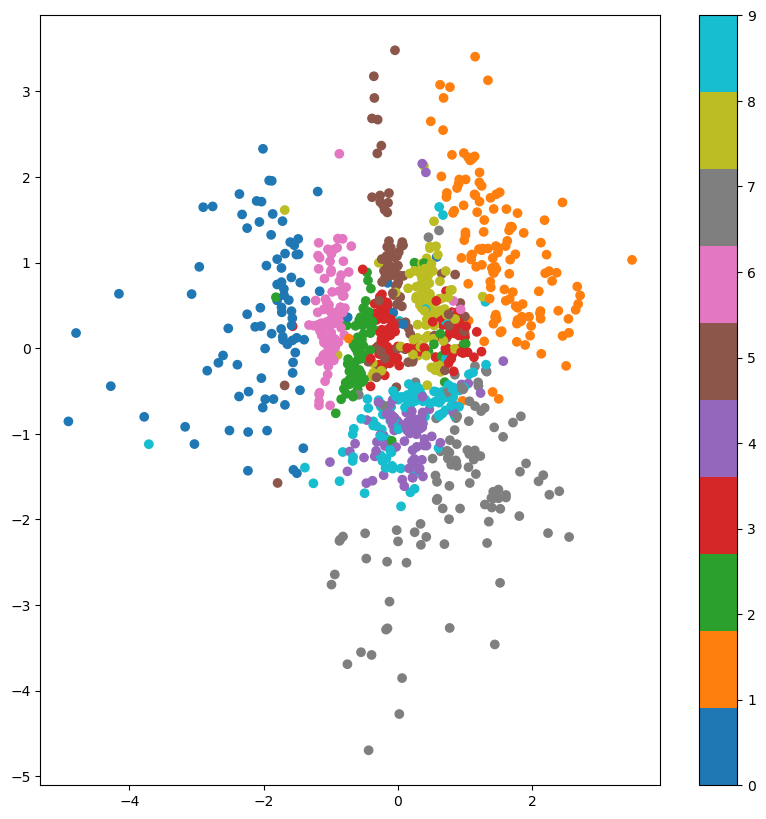

In [79]:
plt.figure(figsize=(10, 10))
plt.scatter(z_all[:, 1], z_all[:, 0], c=y_all, cmap='tab10')
plt.colorbar()
# plt.show()
plt.savefig('vae_mnist_2d_scatter.webp')

Encoding:   0%|          | 0/8 [00:00<?, ?it/s]

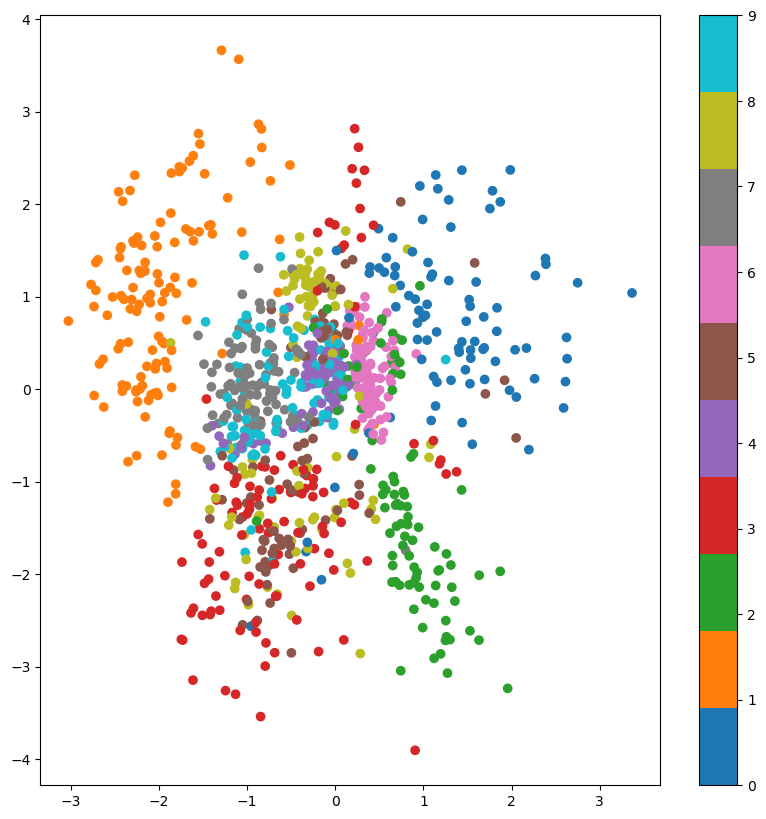

In [80]:
# encode and plot the z values for the train set 
model_2.eval()
z_all = []
y_all = []
with torch.no_grad():
    for data, target in tqdm(train_loader_4, desc='Encoding'):
        data = data.to(device)
        output = model_2(data, compute_loss=False)
        z_all.append(output.z_sample.cpu().numpy())
        y_all.append(target.numpy())
import numpy as np
z_all = np.concatenate(z_all, axis=0)
y_all = np.concatenate(y_all, axis=0)
plt.figure(figsize=(10, 10))
plt.scatter(z_all[:, 0], z_all[:, 1], c=y_all, cmap='tab10')
plt.colorbar()
# plt.show()
plt.savefig('vae_mnist_2d_scatter.webp')

Encoding:   0%|          | 0/8 [00:00<?, ?it/s]

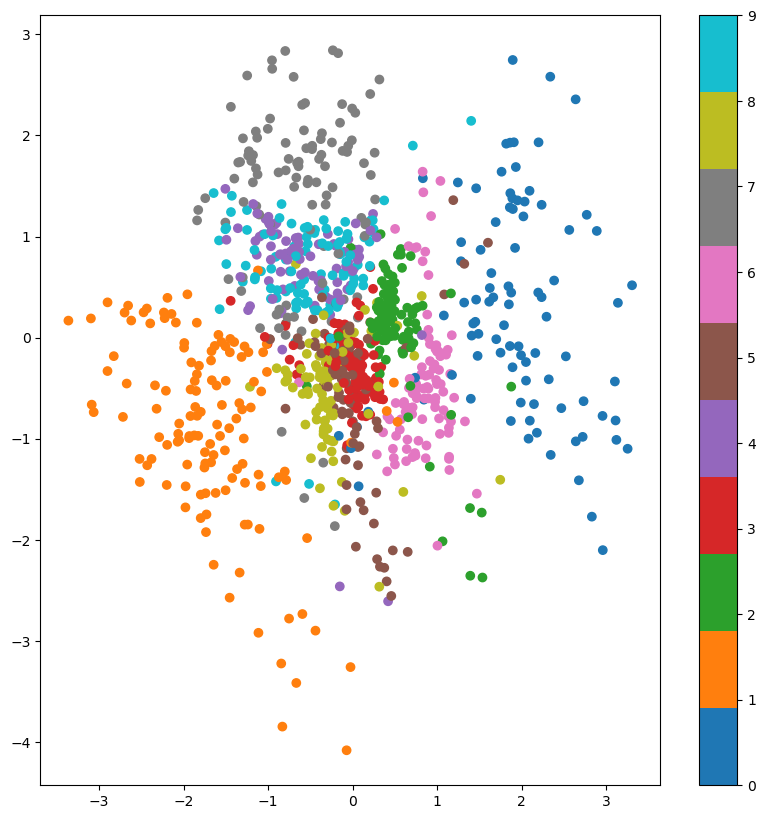

In [81]:
# encode and plot the z values for the train set 
model_3.eval()
z_all = []
y_all = []
with torch.no_grad():
    for data, target in tqdm(train_loader_4, desc='Encoding'):
        data = data.to(device)
        output = model_3(data, compute_loss=False)
        z_all.append(output.z_sample.cpu().numpy())
        y_all.append(target.numpy())
import numpy as np
z_all = np.concatenate(z_all, axis=0)
y_all = np.concatenate(y_all, axis=0)
plt.figure(figsize=(10, 10))
plt.scatter(z_all[:, 0], z_all[:, 1], c=y_all, cmap='tab10')
plt.colorbar()
# plt.show()
plt.savefig('vae_mnist_2d_scatter.webp')